# Chapter 2

In [1]:
## Datasets

### Cleanup

import pandas as pd

import urllib.request
import zipfile


url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
    'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'


def extract_zip(src, dst, member_name):
    """Extract a member file from a zip file and read it into a pandas 
    DataFrame.
    
    Parameters:
        src (str): URL of the zip file to be downloaded and extracted.
        dst (str): Local file path where the zip file will be written.
        member_name (str): Name of the member file inside the zip file 
            to be read into a DataFrame.
    
    Returns:
        pandas.DataFrame: DataFrame containing the contents of the 
            member file.
    """    
    url = src
    fname = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode='wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name))
        kag_questions = kag.iloc[0]
        raw = kag.iloc[1:]
        return raw

raw = extract_zip(url, fname, member_name)        

/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/489761158.py:38: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,42,44,54,56,64,81,83,85,87,105,107,109,121,123,125,148,150,157,172,174,192,194,210,218,219,221,223,246,247,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,302,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  kag = pd.read_csv(z.open(member_name))


In [2]:
### Cleanup Pipeline

def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.

    This function takes a Pandas DataFrame containing Kaggle 
    survey data as input and returns a new DataFrame. The 
    modifications include extracting and transforming certain 
    columns, renaming columns, and selecting a subset of columns.

    Parameters
    ----------
    df_ : pd.DataFrame
        The input DataFrame containing Kaggle survey data.

    Returns
    -------
    pd.DataFrame
        The new DataFrame with the modified and selected columns.
    """    
    return (df_
            .assign(age=df_.Q2.str.slice(0,2).astype(int),
                    education=df_.Q4.replace({'Master’s degree': 18,
                         'Bachelor’s degree': 16,
                         'Doctoral degree': 20,
'Some college/university study without earning a bachelor’s degree': 13,
                         'Professional degree': 19,
                         'I prefer not to answer': None,
                         'No formal education past high school': 12}),
                    major=(df_.Q5
                              .pipe(topn, n=3)
                              .replace({
                        'Computer science (software engineering, etc.)': 'cs',
                        'Engineering (non-computer focused)': 'eng',
                        'Mathematics or statistics': 'stat'})
                         ),
                    years_exp=(df_.Q8.str.replace('+','', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .astype(float)),
                    compensation=(df_.Q9.str.replace('+','', regex=False)
                           .str.replace(',','', regex=False)
                           .str.replace('500000', '500', regex=False)
  .str.replace('I do not wish to disclose my approximate yearly compensation',
             '0', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .fillna(0)
                           .astype(int)
                           .mul(1_000)
                                    ),
                    python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                    r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                    sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
               )#assign
        .rename(columns=lambda col:col.replace(' ', '_'))
        .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
                'python,r,sql'.split(',')]   
       )

        
def topn(ser, n=5, default='other'):
    """
    Replace all values in a Pandas Series that are not among 
    the top `n` most frequent values with a default value.

    This function takes a Pandas Series and returns a new 
    Series with the values replaced as described above. The 
    top `n` most frequent values are determined using the 
    `value_counts` method of the input Series.

    Parameters
    ----------
    ser : pd.Series
        The input Series.
    n : int, optional
        The number of most frequent values to keep. The 
        default value is 5.
    default : str, optional
        The default value to use for values that are not among 
        the top `n` most frequent values. The default value is 
        'other'.

    Returns
    -------
    pd.Series
        The modified Series with the values replaced.
    """    
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)


In [3]:
from feature_engine import encoding, imputation
from sklearn import base, pipeline


class TweakKagTransformer(base.BaseEstimator,
    base.TransformerMixin):
    """
    A transformer for tweaking Kaggle survey data.

    This transformer takes a Pandas DataFrame containing 
    Kaggle survey data as input and returns a new version of 
    the DataFrame. The modifications include extracting and 
    transforming certain columns, renaming columns, and 
    selecting a subset of columns.

    Parameters
    ----------
    ycol : str, optional
        The name of the column to be used as the target variable. 
        If not specified, the target variable will not be set.

    Attributes
    ----------
    ycol : str
        The name of the column to be used as the target variable.
    """
    
    def __init__(self, ycol=None):
        self.ycol = ycol
        
    def transform(self, X):
        return tweak_kag(X)
    
    def fit(self, X, y=None):
        return self

In [4]:
def get_rawX_y(df, y_col):
    raw = (df
            .query('Q3.isin(["United States of America", "China", "India"]) '
               'and Q6.isin(["Data Scientist", "Software Engineer"])')
          )
    return raw.drop(columns=[y_col]), raw[y_col]


## Create a pipeline
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
     ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True, 
           variables=['Q1', 'Q3', 'major'])),
     ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
          variables=['education', 'years_exp']))]
)


In [5]:
from sklearn import model_selection
kag_X, kag_y = get_rawX_y(raw, 'Q6')

kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
   model_selection.train_test_split(
       kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)
X_test = kag_pl.transform(kag_X_test)
print(X_train)

       age  education  years_exp  compensation  python  r  sql  Q1_Male  \
587     25       18.0        4.0             0       1  0    1        1   
3065    22       16.0        1.0         10000       1  0    0        1   
8435    22       18.0        1.0             0       1  0    0        1   
3110    40       20.0        3.0        125000       1  0    1        0   
16372   45       12.0        5.0        100000       1  0    1        1   
...    ...        ...        ...           ...     ... ..  ...      ...   
16608   25       16.0        2.0         10000       0  0    1        1   
7325    18       16.0        1.0         30000       1  0    1        1   
21810   18       16.0        2.0             0       0  0    0        1   
4917    25       18.0        1.0        100000       1  0    1        1   
639     25       18.0        1.0         10000       1  0    0        0   

       Q1_Female  Q1_Prefer not to say  Q1_Prefer to self-describe  \
587            0             

/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future 

In [6]:
kag_y_train

587      Software Engineer
3065        Data Scientist
8435        Data Scientist
3110        Data Scientist
16372    Software Engineer
               ...        
16608    Software Engineer
7325     Software Engineer
21810       Data Scientist
4917        Data Scientist
639         Data Scientist
Name: Q6, Length: 2110, dtype: object

# Chapter 3

<Axes: xlabel='years_exp', ylabel='compensation'>

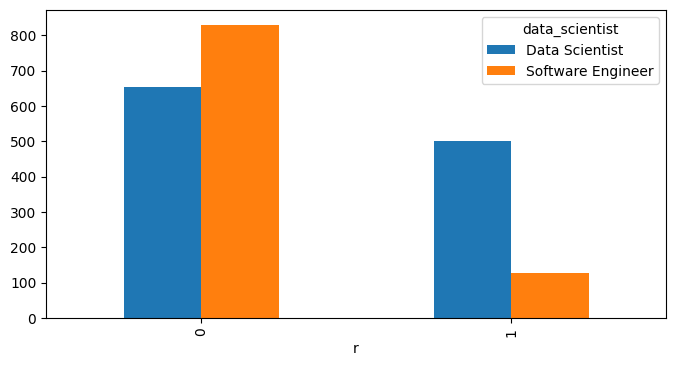

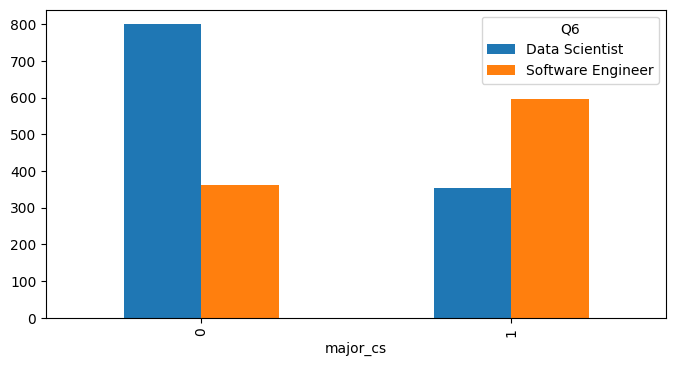

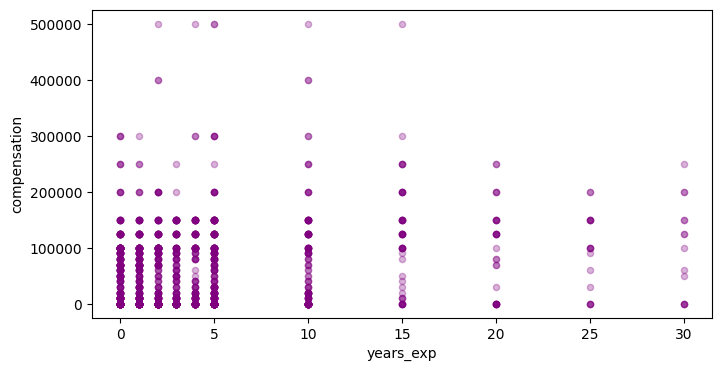

In [7]:
## Exploratory Data Analysis

### Correlations

(X_train
 .assign(data_scientist = kag_y_train == 'Data Scientist')
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
 .set_sticky(axis='index')
)

### Bar Plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
(X_train
 .assign(data_scientist = kag_y_train)
 .groupby('r')
 .data_scientist
 .value_counts()
 .unstack()
 .plot.bar(ax=ax)
)

fig, ax = plt.subplots(figsize=(8, 4))
(pd.crosstab(index=X_train['major_cs'], 
             columns=kag_y)
    .plot.bar(ax=ax)
)

fig, ax = plt.subplots(figsize=(8, 4))
(X_train
 .plot.scatter(x='years_exp', y='compensation', alpha=.3, ax=ax, c='purple')
)

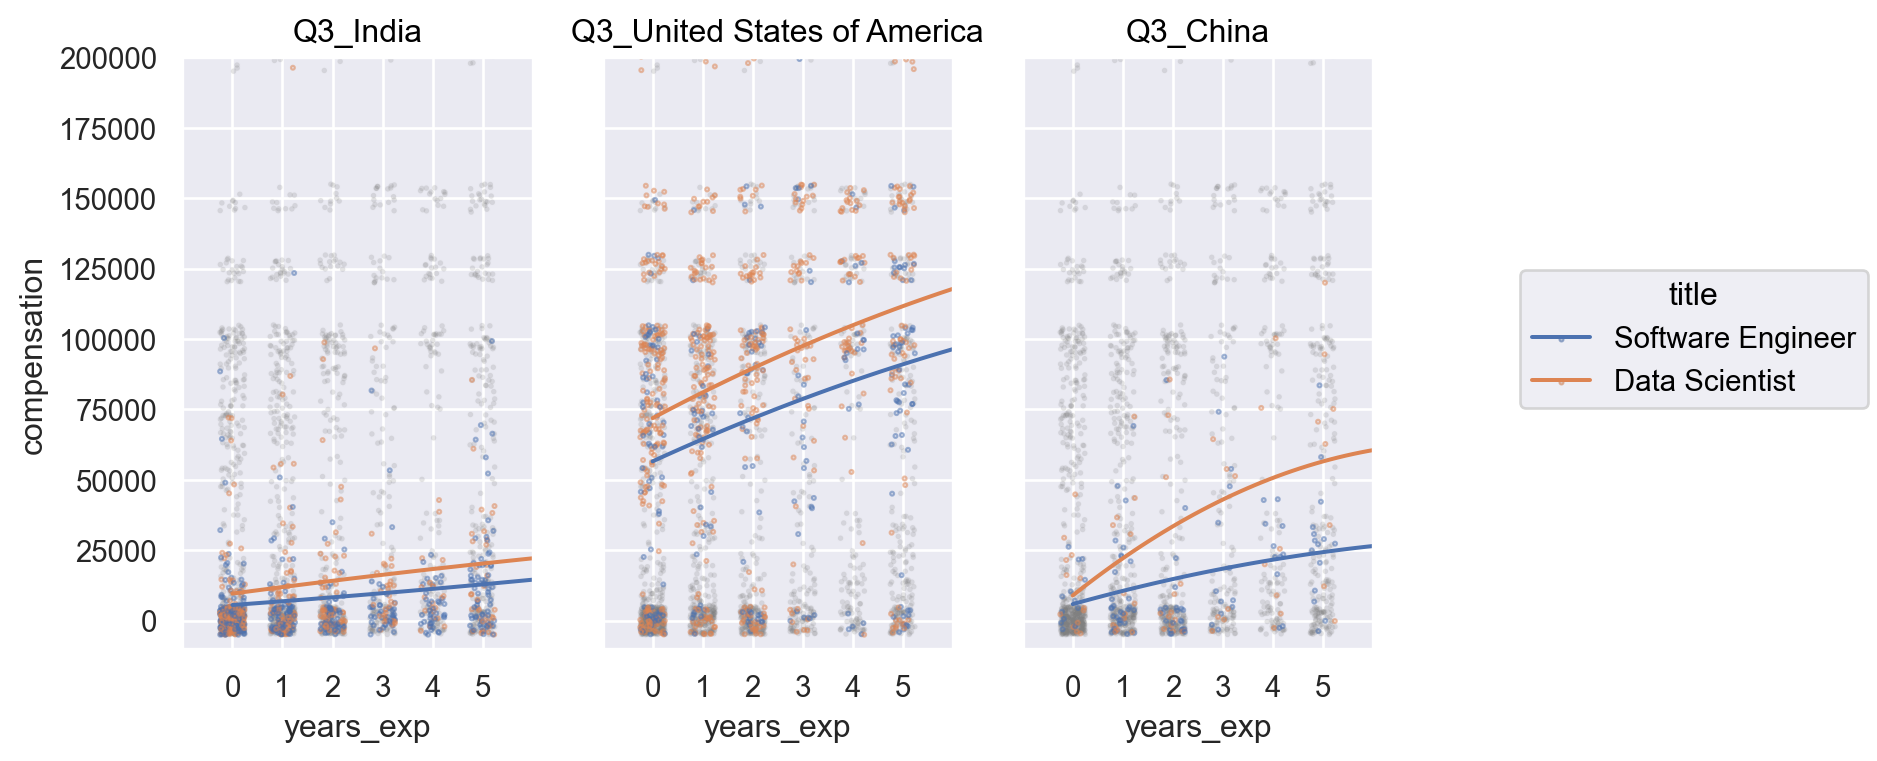

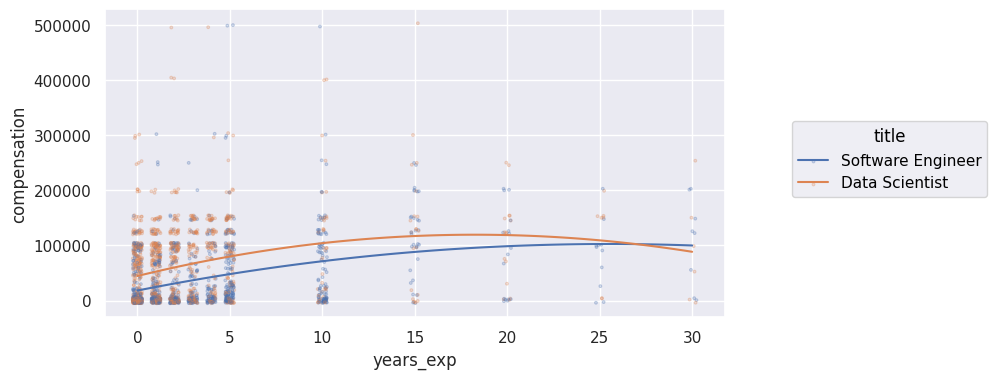

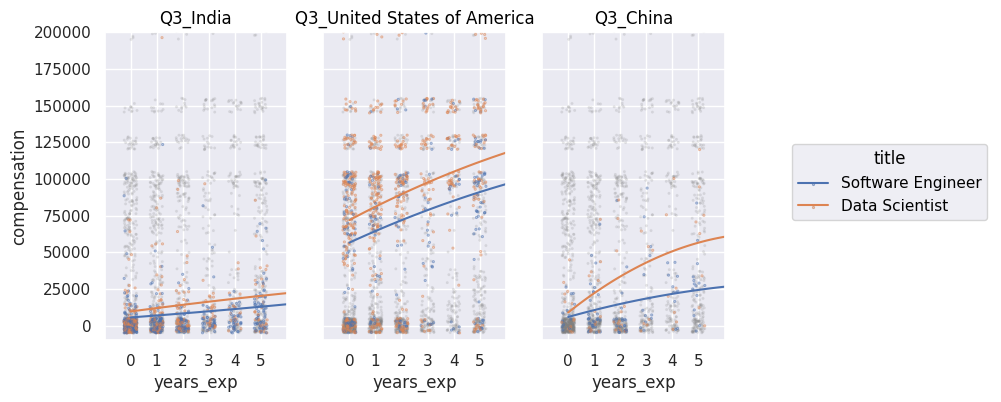

In [8]:
import seaborn.objects as so
fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_train.assign(title=kag_y_train), x='years_exp', y='compensation', color='title')
 .add(so.Dots(alpha=.3, pointsize=2), so.Jitter(x=.5, y=10_000))
 .add(so.Line(), so.PolyFit())
 .on(fig)  # not required unless saving to image
 .plot()   # ditto
)

fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_train
       #.query('compensation < 200_000 and years_exp < 16')
       .assign(
         title=kag_y_train,
         country=(X_train
             .loc[:, 'Q3_United States of America': 'Q3_China']
             .idxmax(axis='columns')
            )
       ), x='years_exp', y='compensation', color='title')
 .facet('country')
 .add(so.Dots(alpha=.01, pointsize=2, color='grey' ), so.Jitter(x=.5, y=10_000), col=None)
 .add(so.Dots(alpha=.5, pointsize=1.5), so.Jitter(x=.5, y=10_000))
 .add(so.Line(pointsize=1), so.PolyFit(order=2))
 .scale(x=so.Continuous().tick(at=[0,1,2,3,4,5]))
 .limit(y=(-10_000, 200_000), x=(-1, 6))  # zoom in with this not .query (above)
 .on(fig)  # not required unless saving to image
 .plot()   # ditto
)


# Chapter 4

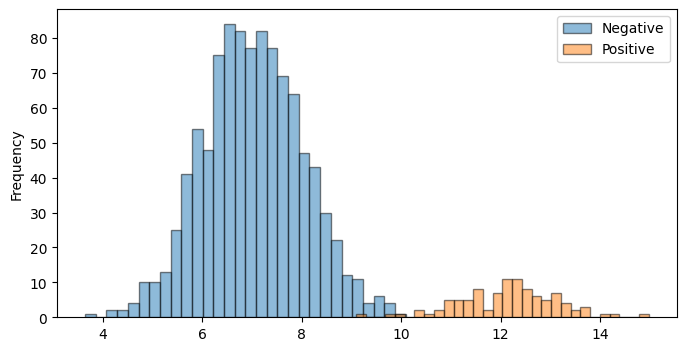

In [9]:
## Tree Creation

### The Gini Coefficient

import numpy as np
import numpy.random as rn

pos_center = 12
pos_count = 100
neg_center = 7
neg_count = 1000
rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))
gini = pd.DataFrame({'value':
    np.append((pos_center) + rs.randn(pos_count),
              (neg_center) + rs.randn(neg_count)),
                     'label':
    ['pos']* pos_count + ['neg'] * neg_count})

fig, ax = plt.subplots(figsize=(8, 4))
_ = (gini
 .groupby('label')
 [['value']]
     .plot.hist(bins=30, alpha=.5, ax=ax, edgecolor='black')
)
ax.legend(['Negative', 'Positive'])


In [10]:
def calc_gini(df, val_col, label_col, pos_val, split_point,
              debug=False):
    """
    This function calculates the Gini impurity of a dataset. Gini impurity 
    is a measure of the probability of a random sample being classified 
    incorrectly when a feature is used to split the data. The lower the 
    impurity, the better the split.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data
    val_col (str): The column name of the feature used to split the data
    label_col (str): The column name of the target variable
    pos_val (str or int): The value of the target variable that represents 
        the positive class
    split_point (float): The threshold used to split the data.
    debug (bool): optional, when set to True, prints the calculated Gini
        impurities and the final weighted average

    Returns:
    float: The weighted average of Gini impurity for the positive and 
        negative subsets.
    """    
    ge_split = df[val_col] >= split_point
    eq_pos = df[label_col] == pos_val
    tp = df[ge_split & eq_pos].shape[0]
    fp = df[ge_split & ~eq_pos].shape[0]
    tn = df[~ge_split & ~eq_pos].shape[0]
    fn = df[~ge_split & eq_pos].shape[0]
    pos_size = tp+fp
    neg_size = tn+fn
    total_size = len(df)
    if pos_size == 0:
        gini_pos = 0
    else:
        gini_pos = 1 - (tp/pos_size)**2 - (fp/pos_size)**2
    if neg_size == 0:
        gini_neg = 0
    else:
        gini_neg = 1 - (tn/neg_size)**2 - (fn/neg_size)**2
    weighted_avg = gini_pos * (pos_size/total_size) + \
                   gini_neg * (neg_size/total_size)
    if debug:
        print(f'{gini_pos=:.3} {gini_neg=:.3} {weighted_avg=:.3}')
    return weighted_avg

calc_gini(gini, val_col='value', label_col='label', pos_val='pos',
          split_point=9.24, debug=True)


gini_pos=0.217 gini_neg=0.00202 weighted_avg=0.0241


0.024117224644432264

Text(0.5, 0, 'Split Point')

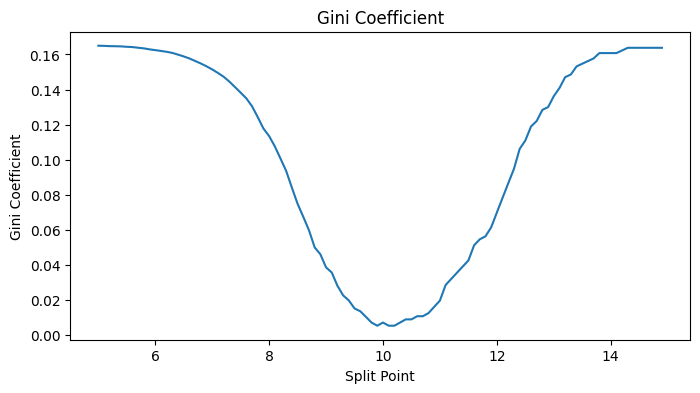

In [11]:
values = np.arange(5, 15, .1)
ginis = []
for v in values:
    ginis.append(calc_gini(gini, val_col='value', label_col='label',
                           pos_val='pos', split_point=v))
fig, ax = plt.subplots(figsize=(8, 4))    
ax.plot(values, ginis)
ax.set_title('Gini Coefficient')
ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('Split Point')


In [12]:
pd.Series(ginis, index=values).loc[9.5:10.5]

9.6     0.013703
9.7     0.010470
9.8     0.007193
9.9     0.005429
10.0    0.007238
10.1    0.005438
10.2    0.005438
10.3    0.007244
10.4    0.009046
10.5    0.009046
dtype: float64

In [13]:
print(pd.DataFrame({'gini':ginis, 'split':values}).query('gini <= gini.min()'))

        gini  split
49  0.005429    9.9


In [14]:
gini[['value']]

,value
0,14.210352
1,12.775662
2,12.346531
3,12.977911
4,13.146511
...,...
1095,6.633856
1096,6.116057
1097,6.586057
1098,6.990318


In [15]:
gini.label

0       pos
1       pos
2       pos
3       pos
4       pos
       ... 
1095    neg
1096    neg
1097    neg
1098    neg
1099    neg
Name: label, Length: 1100, dtype: object

[Text(0.5, 0.75, 'value <= 9.708\ngini = 0.165\nsamples = 1100\nvalue = [1000, 100]\nclass = neg'),
 Text(0.25, 0.25, 'gini = 0.002\nsamples = 999\nvalue = [998, 1]\nclass = neg'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.039\nsamples = 101\nvalue = [2, 99]\nclass = pos'),
 Text(0.625, 0.5, '  False')]

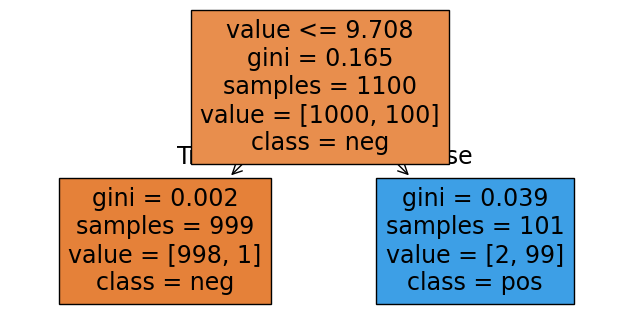

In [16]:
### Coefficients in Trees

from sklearn import tree
stump = tree.DecisionTreeClassifier(max_depth=1)
stump.fit(gini[['value']], gini.label)

fig, ax = plt.subplots(figsize=(8, 4))
tree.plot_tree(stump, feature_names=['value'],
               filled=True, 
               class_names=stump.classes_,
               ax=ax)


In [17]:
gini_pos = 0.039
gini_neg = 0.002
pos_size = 101
neg_size = 999
total_size = pos_size + neg_size
weighted_avg = gini_pos * (pos_size/total_size) + \
              gini_neg * (neg_size/total_size)
print(weighted_avg)


0.005397272727272727


<Axes: >

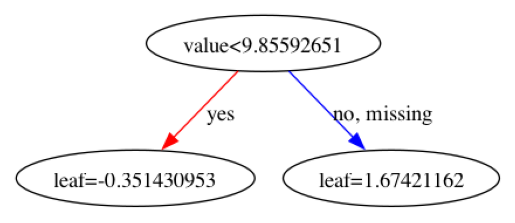

In [18]:
import xgboost as xgb
xg_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)                 
xg_stump.fit(gini[['value']], (gini.label== 'pos'))

xgb.plot_tree(xg_stump, num_trees=0)



In [19]:
import subprocess
def my_dot_export(xg, num_trees, filename, title='', direction='TB'):
    """Exports a specified number of trees from an XGBoost model as a graph 
    visualization in dot and png formats.

    Args:
        xg: An XGBoost model.
        num_trees: The number of tree to export.
        filename: The name of the file to save the exported visualization.
        title: The title to display on the graph visualization (optional).
        direction: The direction to lay out the graph, either 'TB' (top to 
            bottom) or 'LR' (left to right) (optional).
    """
    res = xgb.to_graphviz(xg, num_trees=num_trees)
    content = f'''    node [fontname = "Roboto Condensed"];
    edge [fontname = "Roboto Thin"];
    label = "{title}"
    fontname = "Roboto Condensed"
    '''
    out = res.source.replace('graph [ rankdir=TB ]', 
                             f'graph [ rankdir={direction} ];\n {content}')
    # dot -Gdpi=300 -Tpng -ocourseflow.png courseflow.dot 
    dot_filename = filename
    with open(dot_filename, 'w') as fout:
        fout.write(out)
    png_filename = dot_filename.replace('.dot', '.png')
    subprocess.run(f'dot -Gdpi=300 -Tpng -o{png_filename} {dot_filename}'.split())

my_dot_export(xg_stump, num_trees=0, filename='img/stump_xg.dot', title='A demo stump')    


(process:2510): Pango-WARNING **: 10:56:37.688: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


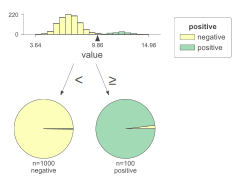

In [20]:
### Another Visualization Tool

import dtreeviz
viz = dtreeviz.model(xg_stump, X_train=gini[['value']], 
                     y_train=gini.label=='pos',
    target_name='positive',
    feature_names=['value'], class_names=['negative', 'positive'],
    tree_index=0)
viz.view()


# Chapter 5

/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the f

[Text(0.5, 0.75, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.25, 'gini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.322\nsamples = 626\nvalue = [500.0, 126.0]\nclass = Data Scientist'),
 Text(0.625, 0.5, '  False')]

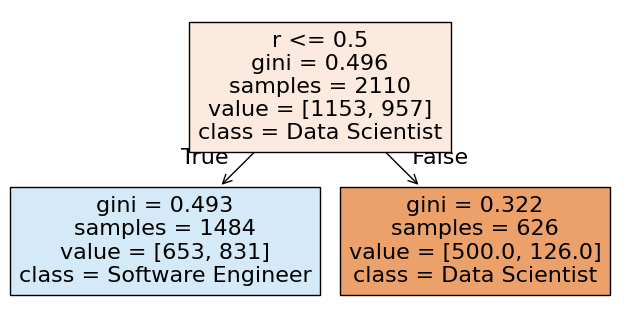

In [21]:
## Stumps on Real Data

### Scikit-learn stump on real data

stump_dt = tree.DecisionTreeClassifier(max_depth=1)
X_train = kag_pl.fit_transform(kag_X_train)
stump_dt.fit(X_train, kag_y_train)

fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(stump_dt, feature_names=features, 
               filled=True, 
               class_names=stump_dt.classes_,
               ax=ax)



In [22]:
X_test = kag_pl.transform(kag_X_test)
stump_dt.score(X_test, kag_y_test)

/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the f

0.6243093922651933

In [23]:
from sklearn import dummy
dummy_model = dummy.DummyClassifier()
dummy_model.fit(X_train, kag_y_train)
dummy_model.score(X_test, kag_y_test)


0.5458563535911602

In [24]:
### Decision Stump with XGBoost
import xgboost as xgb

try:
    kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
    kag_stump.fit(X_train, kag_y_train)
except Exception as e:
    print(e)

Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['Data Scientist' 'Software Engineer']


In [25]:
print(kag_y_train)
print(kag_y_train == 'Software Engineer')

587      Software Engineer
3065        Data Scientist
8435        Data Scientist
3110        Data Scientist
16372    Software Engineer
               ...        
16608    Software Engineer
7325     Software Engineer
21810       Data Scientist
4917        Data Scientist
639         Data Scientist
Name: Q6, Length: 2110, dtype: object
587       True
3065     False
8435     False
3110     False
16372     True
         ...  
16608     True
7325      True
21810    False
4917     False
639      False
Name: Q6, Length: 2110, dtype: bool


In [26]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
y_test[:5]


array([1, 0, 0, 1, 1])

In [27]:
label_encoder.classes_


array(['Data Scientist', 'Software Engineer'], dtype=object)

In [28]:
label_encoder.inverse_transform([0, 1])


array(['Data Scientist', 'Software Engineer'], dtype=object)

In [29]:
kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
kag_stump.fit(X_train, y_train)
kag_stump.score(X_test, y_test)


0.5458563535911602

In [30]:
my_dot_export(kag_stump, num_trees=0, filename='img/stump_xg_kag.dot', 
              title='XGBoost Stump')    


(process:2525): Pango-WARNING **: 10:56:40.540: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


In [31]:
### Values in the XGBoost Tree

kag_stump.classes_


array([0, 1])

In [32]:
import numpy as np
def inv_logit(p: float) -> float:
    """
    Compute the inverse logit function of a given value.

    The inverse logit function is defined as:
        f(p) = exp(p) / (1 + exp(p))

    Parameters
    ----------
    p : float
        The input value to the inverse logit function.

    Returns
    -------
    float
        The output of the inverse logit function.
    """
    return np.exp(p) / (1 + np.exp(p))

In [33]:
inv_logit(.0717741922)

np.float64(0.5179358489487103)

In [34]:
inv_logit(-.3592)

np.float64(0.41115323716754393)

Text(-3, 0.4, 'Predict Negative')

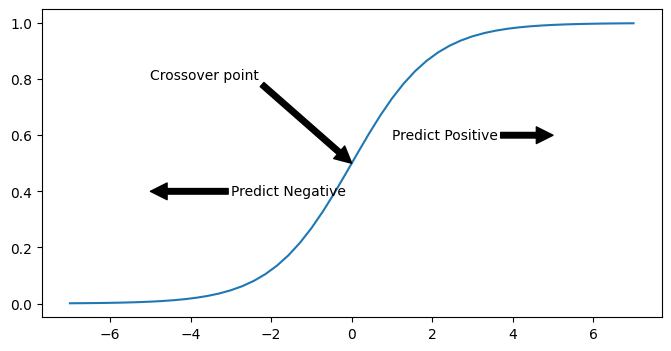

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
vals = np.linspace(-7, 7)
ax.plot(vals, inv_logit(vals))
ax.annotate('Crossover point', (0,.5), (-5,.8), arrowprops={'color':'k'}) 
ax.annotate('Predict Positive', (5,.6), (1,.6), va='center', arrowprops={'color':'k'}) 
ax.annotate('Predict Negative', (-5,.4), (-3,.4), va='center', arrowprops={'color':'k'}) 


# Chapter 6

In [36]:
## Model Complexity & Hyperparameters

### Underfit

underfit = tree.DecisionTreeClassifier(max_depth=1)
X_train = kag_pl.fit_transform(kag_X_train)
underfit.fit(X_train, kag_y_train)
underfit.score(X_test, kag_y_test)


/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the f

0.6243093922651933

In [37]:
### Growing a Tree

### Overfitting

### Overfitting with Decision Trees

hi_variance = tree.DecisionTreeClassifier(max_depth=None)
X_train = kag_pl.fit_transform(kag_X_train)
hi_variance.fit(X_train, kag_y_train)
hi_variance.score(X_test, kag_y_test)

/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/0h/k_rymqp55092cl3bncbmnwtm0000gp/T/ipykernel_2464/1833150870.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the f

0.6740331491712708

[Text(0.6609115813560232, 0.9772727272727273, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]'),
 Text(0.40152173475413355, 0.9318181818181818, 'major_cs <= 0.5\ngini = 0.493\nsamples = 1484\nvalue = [653, 831]'),
 Text(0.5312166580550783, 0.9545454545454546, 'True  '),
 Text(0.19585100386514923, 0.8863636363636364, 'Q3_United States of America <= 0.5\ngini = 0.49\nsamples = 718\nvalue = [410, 308]'),
 Text(0.08087958986471977, 0.8409090909090909, 'years_exp <= 0.5\ngini = 0.491\nsamples = 322\nvalue = [140, 182]'),
 Text(0.02619712261112304, 0.7954545454545454, 'education <= 17.0\ngini = 0.463\nsamples = 74\nvalue = [47, 27]'),
 Text(0.019755207214945242, 0.75, 'age <= 27.5\ngini = 0.499\nsamples = 40\nvalue = [21, 19]'),
 Text(0.018037363109297832, 0.7045454545454546, 'major_stat <= 0.5\ngini = 0.5\nsamples = 38\nvalue = [19, 19]'),
 Text(0.016319519003650418, 0.6590909090909091, 'compensation <= 55000.0\ngini = 0.498\nsamples = 36\nvalue = [17, 19]'),
 Text(0.0146016748

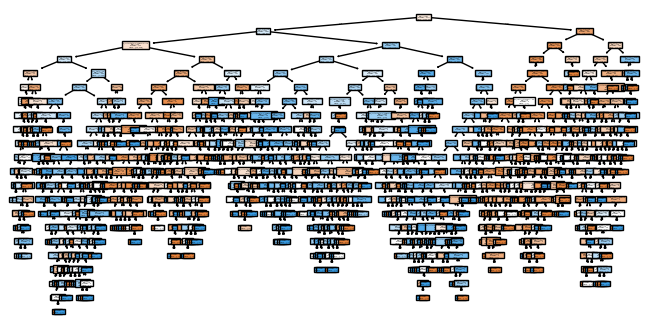

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(hi_variance, feature_names=features, filled=True)


[Text(0.5, 0.875, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.625, 'major_cs <= 0.5\ngini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Q3_United States of America <= 0.5\ngini = 0.49\nsamples = 718\nvalue = [410, 308]\nclass = Data Scientist'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'years_exp <= 2.5\ngini = 0.433\nsamples = 766\nvalue = [243.0, 523.0]\nclass = Software Engineer'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'major_cs <= 0.5\ngini = 0.322\nsamples = 626\nvalue = [500.0, 126.0]\nclass = Data Scientist'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'years_exp <= 22.5\ngini = 0.211\nsamples = 443\nvalue = [390, 53]\nclass = Data Scientist'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 

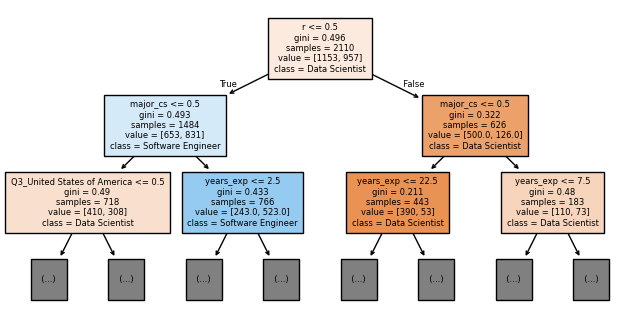

In [39]:

fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(hi_variance, feature_names=features, filled=True, 
                  class_names=hi_variance.classes_,
                max_depth=2, fontsize=6)

### Summary


# Chapter 7

In [40]:
## Tree Hyperparameters

### Decision Tree Hyperparameters

stump.get_params()


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

0.7348066298342542

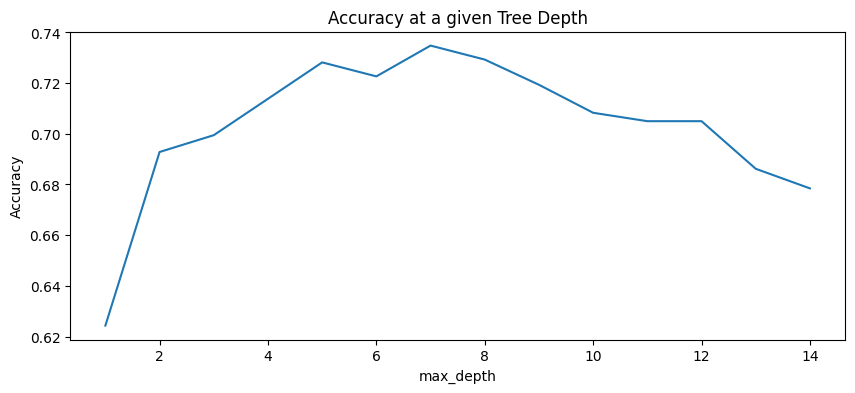

In [41]:
### Tracking changes with Validation Curves

accuracies = []
for depth in range(1, 15):
    between = tree.DecisionTreeClassifier(max_depth=depth)
    between.fit(X_train, kag_y_train)
    accuracies.append(between.score(X_test, kag_y_test))
fig, ax = plt.subplots(figsize=(10,4))    
(pd.Series(accuracies, name='Accuracy', index=range(1, len(accuracies)+1))
 .plot(ax=ax, title='Accuracy at a given Tree Depth'))
ax.set_ylabel('Accuracy')
ax.set_xlabel('max_depth')

between = tree.DecisionTreeClassifier(max_depth=7)
between.fit(X_train, kag_y_train)
between.score(X_test, kag_y_test)


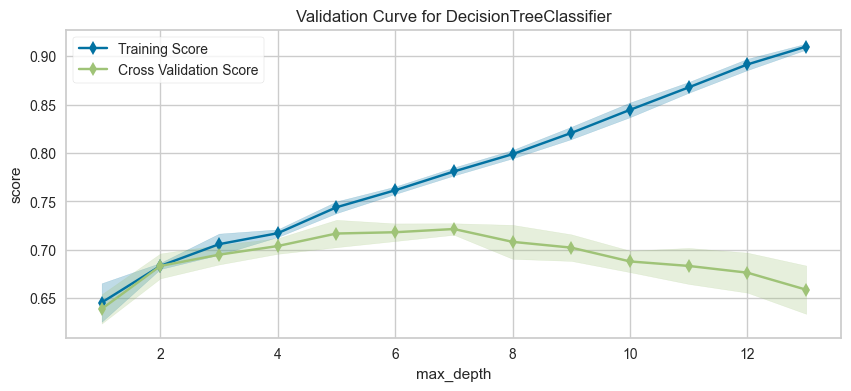

In [42]:
### Leveraging Yellowbrick

from yellowbrick.model_selection import validation_curve
fig, ax = plt.subplots(figsize=(10,4))    
viz = validation_curve(tree.DecisionTreeClassifier(),
    X=pd.concat([X_train, X_test]),
    y=pd.concat([kag_y_train, kag_y_test]),   
    param_name='max_depth', param_range=range(1,14),
    scoring='accuracy', cv=5, ax=ax, n_jobs=6)                           

In [43]:
### Grid Search

from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [3, 5, 7, 8],
    'min_samples_leaf': [1, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5, 6],
}
grid_search = GridSearchCV(estimator=tree.DecisionTreeClassifier(), 
                           param_grid=params, cv=4, n_jobs=-1, 
                           verbose=1, scoring="accuracy")
grid_search.fit(pd.concat([X_train, X_test]),
    pd.concat([kag_y_train, kag_y_test]))


Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8],
                         'min_samples_leaf': [1, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 6]},
             scoring='accuracy', verbose=1)

In [44]:
grid_search.best_params_

{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 3}

In [45]:
between2 = tree.DecisionTreeClassifier(**grid_search.best_params_)
between2.fit(X_train, kag_y_train)
between2.score(X_test, kag_y_test)

0.7259668508287292

In [46]:
# why is the score different than between_tree?
(pd.DataFrame(grid_search.cv_results_)
 .sort_values(by='rank_test_score')
 .style
 .background_gradient(axis='rows')
)

results = model_selection.cross_val_score(
   tree.DecisionTreeClassifier(max_depth=7),
   X=pd.concat([X_train, X_test], axis='index'),
   y=pd.concat([kag_y_train, kag_y_test], axis='index'),
   cv=4
)

results

array([0.69628647, 0.73740053, 0.70291777, 0.71580345])

In [47]:
results.mean()

np.float64(0.7131020568477637)

In [48]:
results = model_selection.cross_val_score(
   tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=5,
                               min_samples_split=2),
   X=pd.concat([X_train, X_test], axis='index'),
   y=pd.concat([kag_y_train, kag_y_test], axis='index'),
   cv=4
)

results


array([0.70689655, 0.73740053, 0.70954907, 0.71978752])

In [49]:
results.mean()

np.float64(0.7184084176116048)

In [50]:

### Summary

### Exercises



# Chapter 8

In [51]:
## Random Forest

### Ensembles with Bagging

### Scikit-learn Random Forest

from sklearn import ensemble
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, kag_y_train)
rf.score(X_test, kag_y_test)

0.7237569060773481

In [52]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [53]:
len(rf.estimators_)

100

In [54]:
print(rf.estimators_[0])

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)


[Text(0.5, 0.875, 'Q3_United States of America <= 0.5\ngini = 0.496\nsamples = 1354\nvalue = [1146.0, 964.0]\nclass = Data Scientist'),
 Text(0.25, 0.625, 'r <= 0.5\ngini = 0.496\nsamples = 681\nvalue = [496, 588]\nclass = Software Engineer'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'education <= 17.0\ngini = 0.469\nsamples = 530\nvalue = [317, 528]\nclass = Software Engineer'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'education <= 17.0\ngini = 0.376\nsamples = 151\nvalue = [179, 60]\nclass = Data Scientist'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'education <= 17.0\ngini = 0.464\nsamples = 673\nvalue = [650, 376]\nclass = Data Scientist'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'major_cs <= 0.5\ngini = 0.485\nsamples = 176\nvalue = [109, 154]\nclass = Software Engineer'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),

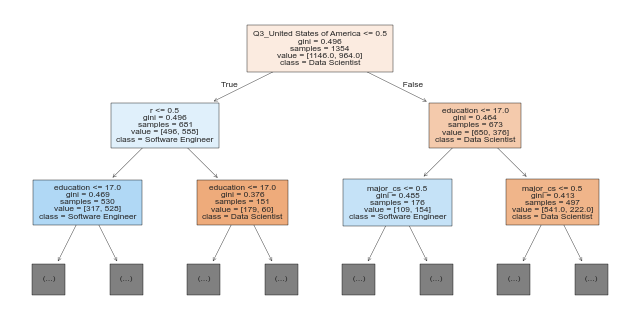

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(rf.estimators_[0], feature_names=features, 
               filled=True, class_names=rf.classes_, ax=ax,
               max_depth=2, fontsize=6)

In [56]:
### XGBoost Random Forest

import xgboost as xgb
rf_xg = xgb.XGBRFClassifier(random_state=42)
rf_xg.fit(X_train, y_train) 
rf_xg.score(X_test, y_test)

0.7502762430939226

In [57]:
rf_xg.get_params()

{'colsample_bynode': 0.8,
 'learning_rate': 1.0,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
 'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


(process:2669): Pango-WARNING **: 10:57:36.248: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


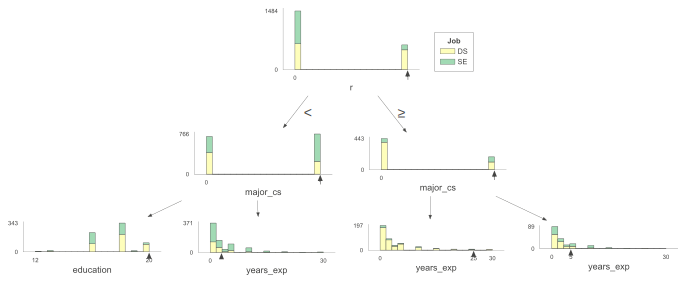

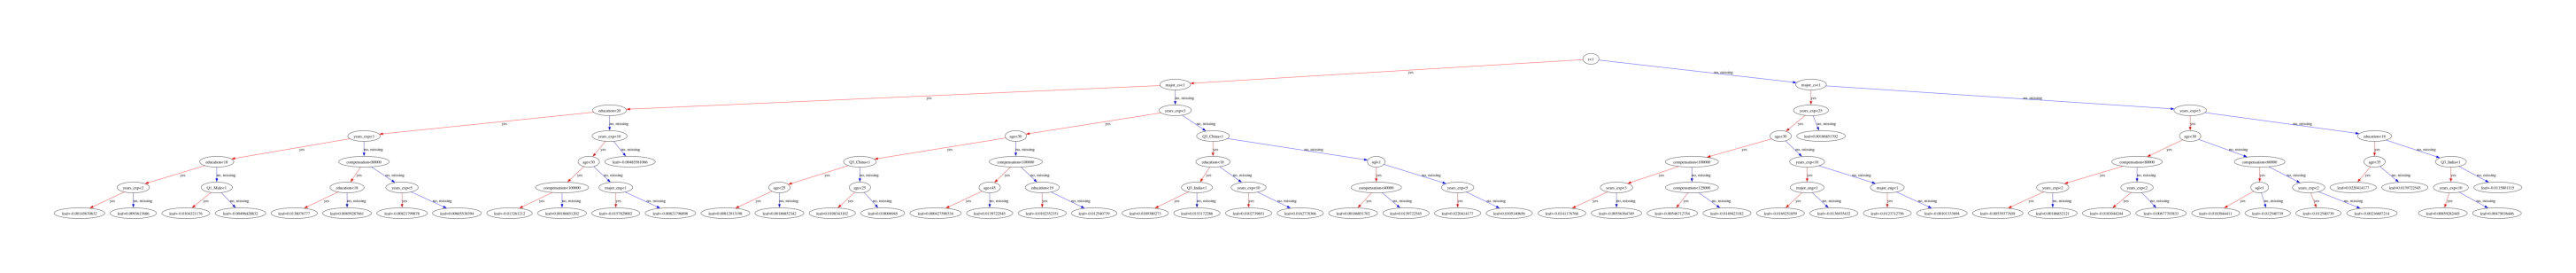

In [58]:
fig, ax = plt.subplots(figsize=(6,12), dpi=600)
xgb.plot_tree(rf_xg, num_trees=0, ax=ax, size='1,1')

my_dot_export(rf_xg, num_trees=0, filename='img/rf_xg_kag.dot', 
              title='First Random Forest Tree', direction='LR')    

viz = dtreeviz.model(rf_xg, X_train=X_train,
    y_train=y_train,
    target_name='Job', feature_names=list(X_train.columns), 
    class_names=['DS', 'SE'], tree_index=0)
viz.view(depth_range_to_display=[0,2])

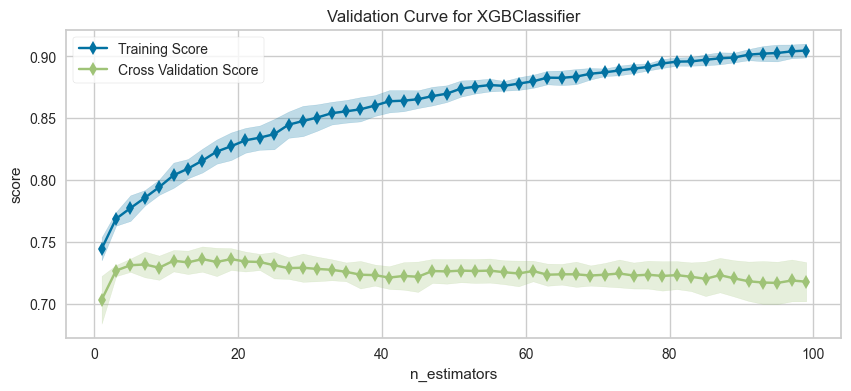

In [59]:
### Random Forest Hyperparameters

### Training the Number of Trees in the Forest

from yellowbrick.model_selection import validation_curve
fig, ax = plt.subplots(figsize=(10,4))    
viz = validation_curve(xgb.XGBClassifier(random_state=42),
    X=pd.concat([X_train, X_test], axis='index'),
    y=np.concatenate([y_train, y_test]),
    param_name='n_estimators', param_range=range(1, 100, 2),
    scoring='accuracy', cv=3, 
    ax=ax)                           

In [60]:
rf_xg29 = xgb.XGBRFClassifier(random_state=42, n_estimators=29)
rf_xg29.fit(X_train, y_train) 
rf_xg29.score(X_test, y_test)

0.7436464088397791

In [61]:
### Summary

### Exercises

# Chapter 9

In [1]:
## XGBoost

### Jargon

### Benefits of Boosting

### A Big Downside

### Creating an XGBoost Model

%matplotlib inline

import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp

In [2]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
    'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

raw = xhelp.extract_zip(url, fname, member_name)

/Users/yanick.chenard/Documents/dev/effective_xgboost_book/xg_helpers.py:32: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,42,44,54,56,64,81,83,85,87,105,107,109,121,123,125,148,150,157,172,174,192,194,210,218,219,221,223,246,247,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,302,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')
    
## Split data    
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
    model_selection.train_test_split(
        kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)    

## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)

## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

/Users/yanick.chenard/Documents/dev/effective_xgboost_book/xg_helpers.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/Users/yanick.chenard/Documents/dev/effective_xgboost_book/xg_helpers.py:109: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/Users/yanick.chenard/Documents/dev/effective_xgboost_book/xg_helpers.py:110: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavio

In [12]:
### A Boosted Model

xg_oob = xgb.XGBClassifier()
xg_oob.fit(X_train, y_train)
xg_oob.score(X_test, y_test)


0.7502762430939226

In [15]:
# Let's try w/ depth of 2 and 2 trees
xg2 = xgb.XGBClassifier(max_depth=2, n_estimators=2)
xg2.fit(X_train, y_train)
xg2.score(X_test, y_test)

/Users/yanick.chenard/Documents/dev/effective_xgboost_book/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:14:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "random_statexxx" } are not used.



0.6939226519337016

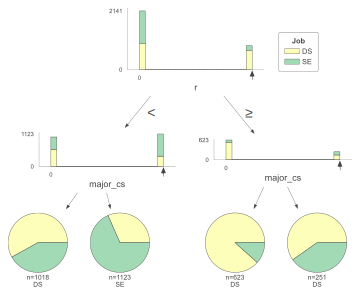

In [6]:
import dtreeviz

viz = dtreeviz.model(xg2, X_train=X, y_train=y, target_name='Job',
    feature_names=list(X_train.columns), 
    class_names=['DS', 'SE'], tree_index=0)
viz.view(depth_range_to_display=[0,2])


(process:4590): Pango-WARNING **: 11:11:11.879: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


<Axes: >

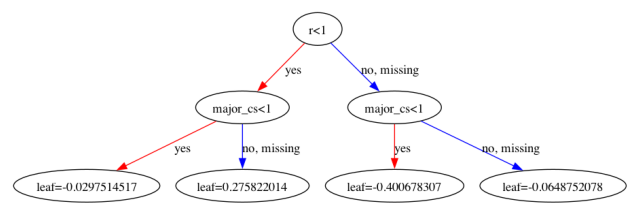

In [7]:
### Understanding the Output of the Trees

xhelp.my_dot_export(xg2, num_trees=0, filename='img/xgb_md2.dot', 
                    title='First Tree') 

xgb.plot_tree(xg2, num_trees=0)

In [8]:
# Predicts 1 - Software engineer
se7894 = pd.DataFrame({'age': {7894: 22},                                            
 'education': {7894: 16.0},
 'years_exp': {7894: 1.0},
 'compensation': {7894: 0},
 'python': {7894: 1},
 'r': {7894: 0},
 'sql': {7894: 0},
 'Q1_Male': {7894: 1},                                   
 'Q1_Female': {7894: 0},
 'Q1_Prefer not to say': {7894: 0},
 'Q1_Prefer to self-describe': {7894: 0},
 'Q3_United States of America': {7894: 0},
 'Q3_India': {7894: 1},
 'Q3_China': {7894: 0},
 'major_cs': {7894: 0},
 'major_other': {7894: 0},
 'major_eng': {7894: 0},
 'major_stat': {7894: 0}})
xg2.predict_proba(se7894)
#array([[0.4986236, 0.5013764]], dtype=float32)

array([[0.5216498 , 0.47835022]], dtype=float32)

In [9]:
# Predicts 1 - Software engineer
xg2.predict(pd.DataFrame(se7894))
#array([1])

array([0])


(process:4613): Pango-WARNING **: 11:11:20.142: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


<Axes: >

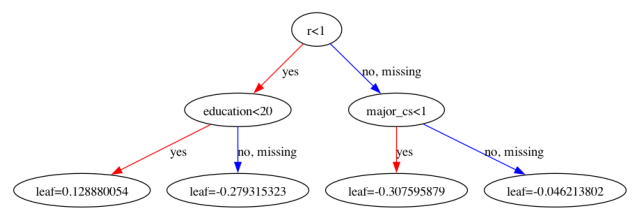

In [10]:
xhelp.my_dot_export(xg2, num_trees=1, filename='img/xgb_md2_tree1.dot', title='Second Tree') 
xgb.plot_tree(xg2, num_trees=1)

In [13]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

inv_logit(-0.08476+0.0902701)
#0.5013775215147345

### Summary

### Exercises



np.float64(0.5013775215147345)

# Chapter 10

In [16]:
## Early Stopping

### Early Stopping Rounds

# Defaults
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)
xg.score(X_test, y_test)
# 0.7458563535911602

0.7502762430939226

In [17]:
xg = xgb.XGBClassifier(early_stopping_rounds=20)
xg.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ]
      )
xg.score(X_test, y_test)
#0.7558011049723757

[0]	validation_0-logloss:0.61261	validation_1-logloss:0.61414
[1]	validation_0-logloss:0.56839	validation_1-logloss:0.57589
[2]	validation_0-logloss:0.54035	validation_1-logloss:0.55089
[3]	validation_0-logloss:0.52087	validation_1-logloss:0.53628
[4]	validation_0-logloss:0.50741	validation_1-logloss:0.52823
[5]	validation_0-logloss:0.49627	validation_1-logloss:0.52017
[6]	validation_0-logloss:0.48585	validation_1-logloss:0.51492
[7]	validation_0-logloss:0.47578	validation_1-logloss:0.51189
[8]	validation_0-logloss:0.46796	validation_1-logloss:0.50871
[9]	validation_0-logloss:0.45895	validation_1-logloss:0.50563
[10]	validation_0-logloss:0.45405	validation_1-logloss:0.50672
[11]	validation_0-logloss:0.44478	validation_1-logloss:0.50460
[12]	validation_0-logloss:0.44074	validation_1-logloss:0.50578
[13]	validation_0-logloss:0.43717	validation_1-logloss:0.50422
[14]	validation_0-logloss:0.42943	validation_1-logloss:0.50359
[15]	validation_0-logloss:0.42615	validation_1-logloss:0.50360
[1

0.7602209944751381

In [22]:
dir(xg)
#xg.best_ntree_limit  # deprecated
xg.best_iteration

14

In [24]:
### Plotting Tree Performance

# validation_0 is for training data
# validation_1 is for testing data
results = xg.evals_result()
results

{'validation_0': OrderedDict([('logloss',
               [0.6126067703510347,
                0.5683864496754244,
                0.5403504353069581,
                0.5208747812145129,
                0.507408839174639,
                0.496273056696659,
                0.4858474562447783,
                0.47578005612390867,
                0.4679583429636972,
                0.45894716372492755,
                0.45404571740495225,
                0.4447751731413165,
                0.440738029661478,
                0.4371716098347899,
                0.42943181938081276,
                0.4261539923909928,
                0.4211362665678017,
                0.4183049452866282,
                0.41321320152704677,
                0.41079201093649764,
                0.4082352261712236,
                0.40667582511464884,
                0.40573405726212497,
                0.40443159712752175,
                0.397458717046897,
                0.39506430675747906,
                

Text(0.5, 0, 'ntrees')

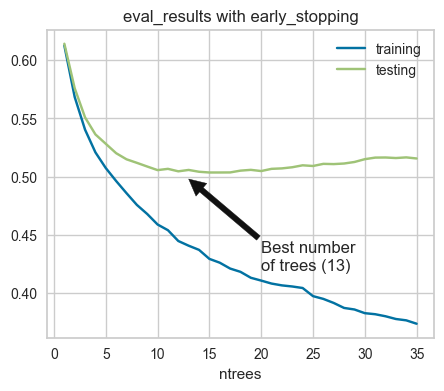

In [25]:
# Testing score is best at 13 trees
results = xg.evals_result()
fig, ax = plt.subplots(figsize=(8, 4))
ax = (pd.DataFrame({'training': results['validation_0']['logloss'],
                    'testing': results['validation_1']['logloss']})
  .assign(ntrees=lambda adf: range(1, len(adf)+1))      
  .set_index('ntrees')
  .plot(figsize=(5,4), ax=ax, 
        title='eval_results with early_stopping')
)
ax.annotate('Best number \nof trees (13)', xy=(13, .498),
           xytext=(20,.42), arrowprops={'color':'k'})
ax.set_xlabel('ntrees')

In [28]:
# Using value from early stopping gives same result
xg13 = xgb.XGBClassifier(n_estimators=13)
xg13.fit(X_train, y_train,
         eval_set=[(X_train, y_train),
                   (X_test, y_test)]
)
xg13.score(X_test, y_test)

[0]	validation_0-logloss:0.61261	validation_1-logloss:0.61414
[1]	validation_0-logloss:0.56839	validation_1-logloss:0.57589
[2]	validation_0-logloss:0.54035	validation_1-logloss:0.55089
[3]	validation_0-logloss:0.52087	validation_1-logloss:0.53628
[4]	validation_0-logloss:0.50741	validation_1-logloss:0.52823
[5]	validation_0-logloss:0.49627	validation_1-logloss:0.52017
[6]	validation_0-logloss:0.48585	validation_1-logloss:0.51492
[7]	validation_0-logloss:0.47578	validation_1-logloss:0.51189
[8]	validation_0-logloss:0.46796	validation_1-logloss:0.50871
[9]	validation_0-logloss:0.45895	validation_1-logloss:0.50563
[10]	validation_0-logloss:0.45405	validation_1-logloss:0.50672
[11]	validation_0-logloss:0.44478	validation_1-logloss:0.50460
[12]	validation_0-logloss:0.44074	validation_1-logloss:0.50578


0.7569060773480663

In [29]:
xg.score(X_test, y_test)
#0.7558011049723757

0.7602209944751381

In [30]:
# No early stopping, uses all estimators
xg_no_es = xgb.XGBClassifier()
xg_no_es.fit(X_train, y_train)
xg_no_es.score(X_test, y_test)
#0.7458563535911602

0.7502762430939226

In [43]:
### Different `eval_metrics`

xg_err = xgb.XGBClassifier(early_stopping_rounds=20, 
                            eval_metric='error')
xg_err.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ]
      )
xg_err.score(X_test, y_test)

[0]	validation_0-error:0.26919	validation_1-error:0.26630
[1]	validation_0-error:0.24028	validation_1-error:0.25746
[2]	validation_0-error:0.23744	validation_1-error:0.25635
[3]	validation_0-error:0.23649	validation_1-error:0.25525
[4]	validation_0-error:0.23318	validation_1-error:0.25635


[5]	validation_0-error:0.23081	validation_1-error:0.25414
[6]	validation_0-error:0.22227	validation_1-error:0.25414
[7]	validation_0-error:0.22180	validation_1-error:0.24530
[8]	validation_0-error:0.21564	validation_1-error:0.24751
[9]	validation_0-error:0.21185	validation_1-error:0.25304
[10]	validation_0-error:0.20806	validation_1-error:0.25525
[11]	validation_0-error:0.20379	validation_1-error:0.24088
[12]	validation_0-error:0.19953	validation_1-error:0.24309
[13]	validation_0-error:0.19905	validation_1-error:0.24309
[14]	validation_0-error:0.19384	validation_1-error:0.23978
[15]	validation_0-error:0.18910	validation_1-error:0.23425
[16]	validation_0-error:0.18863	validation_1-error:0.23646
[17]	validation_0-error:0.18341	validation_1-error:0.23867
[18]	validation_0-error:0.17820	validation_1-error:0.24199
[19]	validation_0-error:0.17678	validation_1-error:0.23978
[20]	validation_0-error:0.17536	validation_1-error:0.24199
[21]	validation_0-error:0.17393	validation_1-error:0.23867
[2

0.7657458563535912

In [33]:
# xg_err.best_ntree_limit
xg_err.best_iteration

### Summary

### Exercises



15

# Chapter 11

In [46]:
## XGBoost Hyperparameters

### Hyperparameters

### Examining Hyperparameters

xg = xgb.XGBClassifier() # set the hyperparamters in here
xg.fit(X_train, y_train)
xg.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

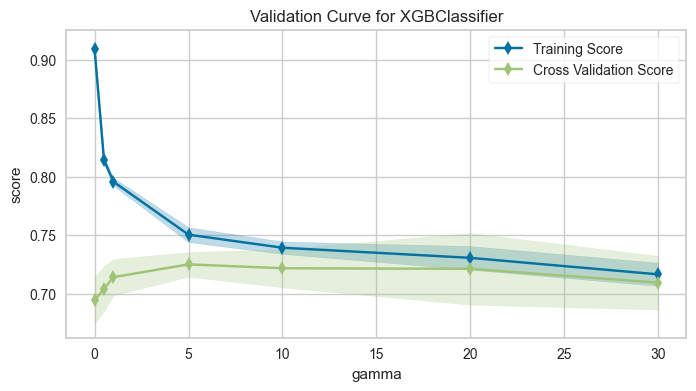

ValidationCurve(ax=<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='gamma', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=No...
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...),
                n_jobs=-1, param_name='gamma',
                param_range=array([ 0. ,  0.5,  1. ,  5. , 10. , 20. , 30. ]))

In [47]:
### Tuning Hyperparameters

fig, ax = plt.subplots(figsize=(8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train, param_name='gamma', 
    param_range=[0, .5, 1,5,10, 20, 30], n_jobs=-1, ax=ax)

In [48]:
### Intuitive Understanding of Learning Rate

# check impact of learning weight on scores
xg_lr1 = xgb.XGBClassifier(learning_rate=1, max_depth=2)
xg_lr1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


(process:37248): Pango-WARNING **: 13:47:09.599: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


<Axes: >

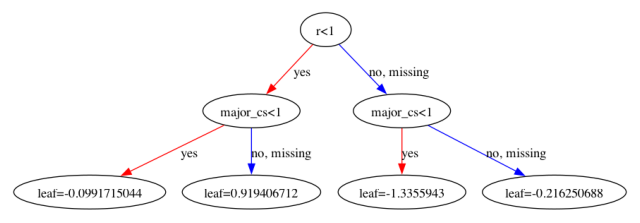

In [53]:
import xg_helpers as xhelp
xhelp.my_dot_export(xg_lr1, num_trees=0, filename='img/xg_depth2_tree0.dot', title='Learning Rate set to 1')    

xgb.plot_tree(xg_lr1, num_trees=0, title='Learning Rate set to 1')    

In [54]:
xg_lr001 = xgb.XGBClassifier(learning_rate=.001, max_depth=2)
xg_lr001.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


(process:37779): Pango-WARNING **: 13:51:15.554: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


<Axes: >

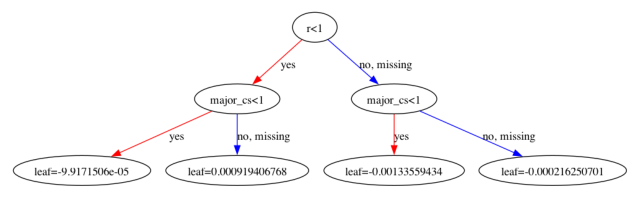

In [55]:

xhelp.my_dot_export(xg_lr001, num_trees=0, filename='img/xg_depth2_tree0_lr001.dot', title='Learning Rate set to .001')    
xgb.plot_tree(xg_lr001, num_trees=0, title='Learning Rate set to .001')    

In [56]:
### Grid Search

from sklearn import model_selection
params = {'reg_lambda': [0],  # No effect
          'learning_rate': [.1, .3], # makes each boost more conservative 
          'subsample': [.7, 1],
          'max_depth': [2, 3],
          'random_state': [42],
          'n_jobs': [-1],
          'n_estimators': [200]}

xgb2 = xgb.XGBClassifier(early_stopping_rounds=5) 
cv = (model_selection.GridSearchCV(xgb2, params, cv=3, n_jobs=-1)
    .fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         verbose=50
    )
)

[0]	validation_0-logloss:0.67119
[0]	validation_0-logloss:0.67126
[0]	validation_0-logloss:0.66821
[0]	validation_0-logloss:0.67129
[0]	validation_0-logloss:0.66710
[0]	validation_0-logloss:0.67111
[0]	validation_0-logloss:0.66826
[0]	validation_0-logloss:0.66773
[0]	validation_0-logloss:0.67271
[0]	validation_0-logloss:0.66727
[0]	validation_0-logloss:0.67266
[0]	validation_0-logloss:0.66852
[50]	validation_0-logloss:0.51911
[50]	validation_0-logloss:0.52347
[50]	validation_0-logloss:0.52728[50]	validation_0-logloss:0.50949

[50]	validation_0-logloss:0.53011
[50]	validation_0-logloss:0.52346
[50]	validation_0-logloss:0.51662
[50]	validation_0-logloss:0.52272
[50]	validation_0-logloss:0.51160
[50]	validation_0-logloss:0.52109
[50]	validation_0-logloss:0.50333
[50]	validation_0-logloss:0.51812
[59]	validation_0-logloss:0.51943
[63]	validation_0-logloss:0.51613
[73]	validation_0-logloss:0.52137
[73]	validation_0-logloss:0.51789
[74]	validation_0-logloss:0.51753
[71]	validation_0-logloss:

/Users/yanick.chenard/Documents/dev/effective_xgboost_book/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast


[100]	validation_0-logloss:0.51002
[127]	validation_0-logloss:0.50745


In [58]:
cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}

In [59]:
params = {'learning_rate': 0.3,
          'max_depth': 2,
          'n_estimators': 200,
          'n_jobs': -1,
          'random_state': 42,
          'reg_lambda': 0,
          'subsample': 1
}
xgb_grid = xgb.XGBClassifier(**params, early_stopping_rounds=50)
xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train),
 (X_test, y_test)],
 verbose=10
)

[0]	validation_0-logloss:0.64458	validation_1-logloss:0.64254
[10]	validation_0-logloss:0.54414	validation_1-logloss:0.53889
[20]	validation_0-logloss:0.52465	validation_1-logloss:0.52036
[30]	validation_0-logloss:0.51517	validation_1-logloss:0.51315
[40]	validation_0-logloss:0.50796	validation_1-logloss:0.51051
[50]	validation_0-logloss:0.50304	validation_1-logloss:0.50915
[60]	validation_0-logloss:0.50045	validation_1-logloss:0.50945
[70]	validation_0-logloss:0.49711	validation_1-logloss:0.50907
[80]	validation_0-logloss:0.49464	validation_1-logloss:0.50909
[90]	validation_0-logloss:0.49198	validation_1-logloss:0.51037
[100]	validation_0-logloss:0.48909	validation_1-logloss:0.50966
[110]	validation_0-logloss:0.48637	validation_1-logloss:0.50912
[120]	validation_0-logloss:0.48499	validation_1-logloss:0.51035
[128]	validation_0-logloss:0.48315	validation_1-logloss:0.51049


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [60]:
# vs default
xgb_def = xgb.XGBClassifier(early_stopping_rounds=50)
xgb_def.fit(X_train, y_train, eval_set=[(X_train, y_train),
 (X_test, y_test)],
 verbose=10
)

[0]	validation_0-logloss:0.61261	validation_1-logloss:0.61414
[10]	validation_0-logloss:0.45405	validation_1-logloss:0.50672
[20]	validation_0-logloss:0.40824	validation_1-logloss:0.50673
[30]	validation_0-logloss:0.38193	validation_1-logloss:0.51637
[40]	validation_0-logloss:0.36574	validation_1-logloss:0.51650
[50]	validation_0-logloss:0.34687	validation_1-logloss:0.52065
[60]	validation_0-logloss:0.33329	validation_1-logloss:0.52791
[63]	validation_0-logloss:0.32991	validation_1-logloss:0.53114


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:

``` pycon
>>> xgb_def.score(X_test, y_test), xgb_grid.score(X_test, y_test)
(0.7558011049723757, 0.7524861878453039)
```

``` pycon
>>> results_default = model_selection.cross_val_score(
...    xgb.XGBClassifier(),
...    X=X, y=y,
...    cv=4
... )
```

``` pycon
>>> results_default
array([0.71352785, 0.72413793, 0.69496021, 0.74501992])
```

``` pycon
>>> results_default.mean()
0.7194114787534214
```

``` pycon
>>> results_grid = model_selection.cross_val_score(
...    xgb.XGBClassifier(**params),
...    X=X, y=y,
...    cv=4
... )
```

``` pycon
>>> results_grid
array([0.74137931, 0.74137931, 0.74801061, 0.73572377])
```

``` pycon
>>> results_grid.mean()
0.7416232505873941
```

### Summary

### Exercises



# Chapter 12

In [45]:
## Hyperopt

### Bayesian Optimization

### Exhaustive Tuning with Hyperopt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, roc_auc_score  

from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]], 
                    X_train: pd.DataFrame, y_train: pd.Series, 
                    X_test: pd.DataFrame, y_test: pd.Series, 
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.

    This function takes a dictionary of hyperparameters, training 
    and test data, and an optional value for early stopping rounds, 
    and returns a dictionary with the loss and model resulting from 
    the tuning process. The model is trained using the training 
    data and evaluated on the test data. The loss is computed as 
    the negative of the accuracy score.

    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value 
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy

    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the 
        tuning process. The loss is a float, and the model is an 
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                  (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation, 
              verbose=False)    
         
    pred = model.predict(X_test)
    score = metric(y_test, pred)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

ModuleNotFoundError: No module named 'hyperopt'

In [ ]:

``` python
options = {'max_depth': hp.quniform('max_depth', 1, 8, 1),  # tree
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'gamma': hp.loguniform('gamma', -10, 10), # regularization
    'learning_rate': hp.loguniform('learning_rate', -7, 0),  # boosting
    'random_state': 42
}

trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, 
                                                   X_test, y_test),            
    space=options,           
    algo=tpe.suggest,            
    max_evals=2_000,            
    trials=trials,
    #timeout=60*5 # 5 minutes
)
```

``` python
# 2 hours of training (paste best in here)
long_params = {'colsample_bytree': 0.6874845219014455, 
               'gamma': 0.06936323554883501, 
               'learning_rate': 0.21439214284976907, 
               'max_depth': 6, 
               'min_child_weight': 0.6678357091609912, 
               'reg_alpha': 3.2979862933185546, 
               'reg_lambda': 7.850943400390477, 
               'subsample': 0.999767483950891}
```

``` python
xg_ex = xgb.XGBClassifier(**long_params, early_stopping_rounds=50,
                            n_estimators=500)
xg_ex.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ],
        verbose=100
      )
```

``` pycon
>>> xg_ex.score(X_test, y_test)
0.7580110497237569
```

### Defining Parameter Distributions

``` pycon
>>> from hyperopt import hp, pyll
>>> pyll.stochastic.sample(hp.choice('value', ['a', 'b', 'c']))
'a'
```

``` pycon
>>> pyll.stochastic.sample(hp.pchoice('value', [(.05, 'a'), (.9, 'b'), 
...     (.05, 'c')]))
'c'
```

``` pycon
>>> from hyperopt import hp, pyll

>>> pyll.stochastic.sample(hp.uniform('value', 0, 1))
0.7875384438202859
```

``` python
uniform_vals = [pyll.stochastic.sample(hp.uniform('value', 0, 1)) 
               for _ in range(10_000)]
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(uniform_vals)
```

``` python
loguniform_vals = [pyll.stochastic.sample(hp.loguniform('value', -5, 5)) 
               for _ in range(10_000)]
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(loguniform_vals)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(np.arange(-5, 5, step=.1))
 .rename('x')
 .to_frame()
 .assign(y=lambda adf:np.exp(adf.x))
 .plot(x='x', y='y', ax=ax)
)
```

``` pycon
>>> from hyperopt import hp, pyll
>>> from math import log
>>> pyll.stochastic.sample(hp.loguniform('value', log(.1), log(10)))
3.0090767867889174
```

``` python
quniform_vals = [pyll.stochastic.sample(hp.quniform('value', -5, 5, q=2)) 
               for _ in range(10_000)]
```

``` pycon
>>> pd.Series(quniform_vals).value_counts()
-0.0    2042
-2.0    2021
 2.0    2001
 4.0    2000
-4.0    1936
dtype: int64
```

### Exploring the Trials

``` python
from typing import Any, Dict, Sequence
def trial2df(trial: Sequence[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert a Trial object (sequence of trial dictionaries)
    to a Pandas DataFrame.

    Parameters
    ----------
    trial : List[Dict[str, Any]]
        A list of trial dictionaries.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns for the loss, trial id, and
        values from each trial dictionary.
    """
    vals = []
    for t in trial:
        result = t['result']
        misc = t['misc']
        val = {k:(v[0] if isinstance(v, list) else v)  
               for k,v in misc['vals'].items()
              }
        val['loss'] = result['loss']
        val['tid'] = t['tid']
        vals.append(val)
    return pd.DataFrame(vals)
```

``` pycon
>>> hyper2hr = trial2df(trials)
```

``` pycon
>>> hyper2hr
      colsample_bytree       gamma  learning_rate  ...  subsample      loss  \
0             0.854670    2.753933       0.042056  ...   0.913247 -0.744751   
1             0.512653    0.153628       0.611973  ...   0.550048 -0.746961   
2             0.552569    1.010561       0.002412  ...   0.508593 -0.735912   
3             0.604020  682.836185       0.005037  ...   0.536935 -0.545856   
4             0.785281    0.004130       0.015200  ...   0.691211 -0.739227   
...                ...         ...            ...  ...        ...       ...   
1995          0.717890    0.000543       0.141629  ...   0.893414 -0.765746   
1996          0.725305    0.000248       0.172854  ...   0.919415 -0.765746   
1997          0.698025    0.028484       0.162207  ...   0.952204 -0.770166   
1998          0.688053    0.068223       0.099814  ...   0.939489 -0.762431   
1999          0.666225    0.125253       0.203441  ...   0.980354 -0.767956   

       tid  
0        0  
1        1  
2        2  
3        3  
4        4  
...    ...  
1995  1995  
1996  1996  
1997  1997  
1998  1998  
1999  1999  

[2000 rows x 10 columns]
```

``` python
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(hyper2hr.corr(method='spearman'),
    cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='tid', y='loss', alpha=.1, color='purple', ax=ax)
)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='max_depth', y='loss', alpha=1, color='purple', ax=ax)
)
```

``` python
import numpy as np

def jitter(df: pd.DataFrame, col: str, amount: float=1) -> pd.Series:
    """
    Add random noise to the values in a Pandas DataFrame column.

    This function adds random noise to the values in a specified 
    column of a Pandas DataFrame. The noise is uniform random 
    noise with a range of `amount` centered around zero. The 
    function returns a Pandas Series with the jittered values.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    col : str
        The name of the column to jitter.
    amount : float, optional
        The range of the noise to add. The default value is 1.

    Returns
    -------
    pd.Series
        A Pandas Series with the jittered values.
    """
    vals = np.random.uniform(low=-amount/2, high=amount/2,
                            size=df.shape[0])
    return df[col] + vals
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .assign(max_depth=lambda df:jitter(df, 'max_depth', amount=.8))
  .plot.scatter(x='max_depth', y='loss', alpha=.1, color='purple', ax=ax)
)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .assign(max_depth=lambda df:jitter(df, 'max_depth', amount=.8))
  .plot.scatter(x='max_depth', y='loss', alpha=.5, 
               color='tid', cmap='viridis', ax=ax)
)
```

``` python
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(x='max_depth', y='loss', data=hyper2hr, kind='violin', ax=ax)
```

``` python

fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='reg_alpha', y='colsample_bytree', alpha=.8,
               color='tid', cmap='viridis', ax=ax)
)

ax.annotate('Min Loss (-0.77)', xy=(4.56, 0.692),
           xytext=(.7, .84), arrowprops={'color':'k'})
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='gamma', y='loss', alpha=.1, color='purple', ax=ax)
)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='gamma', y='loss', alpha=.5, color='tid', ax=ax, 
                logx=True, cmap='viridis')
)

ax.annotate('Min Loss (-0.77)', xy=(0.000581, -0.777),
           xytext=(1, -.6), arrowprops={'color':'k'})
```

### EDA with Plotly

``` python
import plotly.graph_objects as go

def plot_3d_mesh(df: pd.DataFrame, x_col: str, y_col: str, 
                 z_col: str) -> go.Figure:
    """
    Create a 3D mesh plot using Plotly.

    This function creates a 3D mesh plot using Plotly, with 
    the `x_col`, `y_col`, and `z_col` columns of the `df` 
    DataFrame as the x, y, and z values, respectively. The 
    plot has a title and axis labels that match the column 
    names, and the intensity of the mesh is proportional 
    to the values in the `z_col` column. The function returns 
    a Plotly Figure object that can be displayed or saved as 
    desired.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data to plot.
    x_col : str
        The name of the column to use as the x values.
    y_col : str
        The name of the column to use as the y values.
    z_col : str
        The name of the column to use as the z values.

    Returns
    -------
    go.Figure
        A Plotly Figure object with the 3D mesh plot.
    """
    fig = go.Figure(data=[go.Mesh3d(x=df[x_col], y=df[y_col], z=df[z_col],
        intensity=df[z_col]/ df[z_col].min(),
        hovertemplate=f"{z_col}: %{{z}}<br>{x_col}: %{{x}}<br>{y_col}: "
                                    "%{{y}}<extra></extra>")],
    )

    fig.update_layout( 
        title=dict(text=f'{y_col} vs {x_col}'),
        scene = dict(
          xaxis_title=x_col,
          yaxis_title=y_col,
          zaxis_title=z_col),
        width=700,
        margin=dict(r=20, b=10, l=10, t=50)
    )
    return fig
```

``` python
fig = plot_3d_mesh(hyper2hr.query('gamma < .2'),
    'reg_lambda', 'gamma', 'loss')
           
fig
```

``` python
import plotly.express as px
import plotly.graph_objects as go

def plot_3d_scatter(df: pd.DataFrame, x_col: str, y_col: str, 
                 z_col: str, color_col: str, 
                 opacity: float=1) -> go.Figure:
    """
    Create a 3D scatter plot using Plotly Express.

    This function creates a 3D scatter plot using Plotly Express, 
    with the `x_col`, `y_col`, and `z_col` columns of the `df` 
    DataFrame as the x, y, and z values, respectively. The points 
    in the plot are colored according to the values in the 
    `color_col` column, using a continuous color scale. The 
    function returns a Plotly Express scatter_3d object that 
    can be displayed or saved as desired.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data to plot.
    x_col : str
        The name of the column to use as the x values.
    y_col : str
        The name of the column to use as the y values.
    z_col : str
        The name of the column to use as the z values.
    color_col : str
        The name of the column to use for coloring.
    opacity : float
        The opacity (alpha) of the points.

    Returns
    -------
    go.Figure
        A Plotly Figure object with the 3D mesh plot.
    """
    fig = px.scatter_3d(data_frame=df, x=x_col,
                y=y_col, z=z_col, color=color_col,
                color_continuous_scale=px.colors.sequential.Viridis_r,
                opacity=opacity)
    return fig
```

``` python
plot_3d_scatter(hyper2hr.query('gamma < .2'), 
              'reg_lambda', 'gamma', 'tid', color_col='loss')
```

### Conclusion

### Exercises

## Step-wise Tuning with Hyperopt

### Groups of Hyperparameters

``` python
from hyperopt import fmin, tpe, hp, Trials
params = {'random_state': 42}

rounds = [{'max_depth': hp.quniform('max_depth', 1, 8, 1),  # tree
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
          {'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
          {'reg_alpha': hp.uniform('reg_alpha', 0, 10),
            'reg_lambda': hp.uniform('reg_lambda', 1, 10),},
          {'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
          {'learning_rate': hp.loguniform('learning_rate', -7, 0)} # boosting
]

all_trials = []
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: xhelp.hyperparameter_tuning(space, X_train, 
                                        y_train, X_test, y_test),            
        space=params,           
        algo=tpe.suggest,            
        max_evals=20,            
        trials=trials,
    )
    params = {**params, **best}
    all_trials.append(trials)
```

### Visualization Hyperparameter Scores

``` python
xhelp.plot_3d_mesh(xhelp.trial2df(all_trials[2]),
    'reg_alpha', 'reg_lambda', 'loss')    
```

### Training an Optimized Model

``` python
step_params = {'random_state': 42,
 'max_depth': 5,
 'min_child_weight': 0.6411044640540848,
 'subsample': 0.9492383155577023,
 'colsample_bytree': 0.6235721099295888,
 'gamma': 0.00011273797329538491,
 'learning_rate': 0.24399020050740935}
```

``` python
xg_step = xgb.XGBClassifier(**step_params, early_stopping_rounds=50,
                            n_estimators=500)
xg_step.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ],
        verbose=100
      )
```

``` pycon
>>> xg_step.score(X_test, y_test)
0.7613259668508288
```

``` pycon
>>> xg_def = xgb.XGBClassifier()
>>> xg_def.fit(X_train, y_train)
>>> xg_def.score(X_test, y_test)
0.7458563535911602
```

### Summary

### Exercises

## Do you have enough data?

### Learning Curves

``` python
params = {'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}
```

``` python
import yellowbrick.model_selection as ms
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(xgb.XGBClassifier(**params),
      X, y, ax=ax
)
ax.set_ylim(0.6, 1)
```

### Learning Curves for Decision Trees

``` python
# tuned tree
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(max_depth=7),
      X, y, ax=ax)
viz.ax.set_ylim(0.6, 1)
```

### Underfit Learning Curves

``` python
# underfit
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(max_depth=1),
      X, y, ax=ax
)
ax.set_ylim(0.6, 1)
```

### Overfit Learning Curves

``` python
# overfit
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(),
      X, y, ax=ax
)
ax.set_ylim(0.6, 1)
```

### Summary

### Exercises

## Model Evaluation

### Accuracy

``` python
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)
```

``` pycon
>>> xgb_def.score(X_test, y_test)
0.7458563535911602
```

``` pycon
>>> from sklearn import metrics
>>> metrics.accuracy_score(y_test, xgb_def.predict(X_test))
0.7458563535911602
```

### Confusion Matrix

``` python
fig, ax = plt.subplots(figsize=(8, 4))
classifier.confusion_matrix(xgb_def, X_train, y_train,
                            X_test, y_test,
                            classes=['DS', 'SE'], ax=ax
                           )
```

``` pycon
>>> from sklearn import metrics
>>> cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test))
>>> cm
array([[372, 122],
       [108, 303]])
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=['DS', 'SE'])
disp.plot(ax=ax, cmap='Blues')
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test), 
                             normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=['DS', 'SE'])                        
disp.plot(ax=ax, cmap='Blues')
```

### Precision and Recall

``` pycon
>>> metrics.precision_score(y_test, xgb_def.predict(X_test))
0.7129411764705882
```

``` pycon
>>> metrics.recall_score(y_test, xgb_def.predict(X_test))
0.7372262773722628
```

``` python
from yellowbrick import classifier
fig, ax = plt.subplots(figsize=(8, 4))
classifier.precision_recall_curve(xgb_def, X_train, y_train,
    X_test, y_test, micro=False, macro=False, ax=ax, per_class=True)
ax.set_ylim((0,1.05))
```

### F1 Score

``` pycon
>>> metrics.f1_score(y_test, xgb_def.predict(X_test))
0.7248803827751197
```

``` pycon
>>> print(metrics.classification_report(y_test, 
...     y_pred=xgb_def.predict(X_test), target_names=['DS', 'SE']))
              precision    recall  f1-score   support

          DS       0.78      0.75      0.76       494
          SE       0.71      0.74      0.72       411

    accuracy                           0.75       905
   macro avg       0.74      0.75      0.74       905
weighted avg       0.75      0.75      0.75       905
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
classifier.classification_report(xgb_def, X_train, y_train,
    X_test, y_test, classes=['DS', 'SE'],
    micro=False, macro=False, ax=ax)
```

### ROC Curve

``` python
fig, ax = plt.subplots(figsize=(8,8))
metrics.RocCurveDisplay.from_estimator(xgb_def,
                       X_test, y_test,ax=ax, label='default')
metrics.RocCurveDisplay.from_estimator(xg_step,
                       X_test, y_test,ax=ax)
```

``` python
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
metrics.RocCurveDisplay.from_estimator(xgb_def,
                       X_train, y_train,ax=axes[0], label='detault train')
metrics.RocCurveDisplay.from_estimator(xgb_def,
                       X_test, y_test,ax=axes[0])
axes[0].set(title='ROC plots for default model')

metrics.RocCurveDisplay.from_estimator(xg_step,
                       X_train, y_train,ax=axes[1], label='step train')
metrics.RocCurveDisplay.from_estimator(xg_step,
                       X_test, y_test,ax=axes[1])
axes[1].set(title='ROC plots for stepwise model')
```

### Threshold Metrics

``` python
class ThresholdXGBClassifier(xgb.XGBClassifier):
    def __init__(self, threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold

    def predict(self, X, *args, **kwargs):
        """Predict with `threshold` applied to predicted class probabilities.
        """
        proba = self.predict_proba(X, *args, **kwargs)
        return (proba[:, 1] > self.threshold).astype(int)
```

``` pycon
>>> xgb_def = xgb.XGBClassifier()
>>> xgb_def.fit(X_train, y_train)
>>> xgb_def.predict_proba(X_test.iloc[[0]])
array([[0.14253652, 0.8574635 ]], dtype=float32)
```

``` pycon
>>> xgb_def.predict(X_test.iloc[[0]])
array([1])
```

``` pycon
>>> xgb90 = ThresholdXGBClassifier(threshold=.9, verbosity=0)
>>> xgb90.fit(X_train, y_train)
>>> xgb90.predict(X_test.iloc[[0]])
array([0])
```

``` python
def get_tpr_fpr(probs, y_truth):
    """
    Calculates true positive rate (TPR) and false positive rate
    (FPR) given predicted probabilities and ground truth labels.

    Parameters:
    probs (np.array): predicted probabilities of positive class
    y_truth (np.array): ground truth labels

    Returns:
    tuple: (tpr, fpr)
    """
    tp = (probs == 1) & (y_truth == 1)
    tn = (probs < 1) & (y_truth == 0)
    fp = (probs == 1) & (y_truth == 0)
    fn = (probs < 1) & (y_truth == 1)
    tpr = tp.sum() / (tp.sum() + fn.sum())
    fpr = fp.sum() / (fp.sum() + tn.sum())
    return tpr, fpr


vals = []
for thresh in np.arange(0, 1, step=.05):
    probs = xg_step.predict_proba(X_test)[:, 1]
    tpr, fpr = get_tpr_fpr(probs > thresh, y_test)
    val = [thresh, tpr, fpr]
    for metric in [metrics.accuracy_score, metrics.precision_score,
                   metrics.recall_score, metrics.f1_score, 
                   metrics.roc_auc_score]:
        val.append(metric(y_test, probs > thresh))
    vals.append(val)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.DataFrame(vals, columns=['thresh', 'tpr/rec', 'fpr', 'acc', 
                             'prec', 'rec', 'f1', 'auc'])
 .drop(columns='rec')
 .set_index('thresh')
 .plot(ax=ax, title='Threshold Metrics')
)
```

### Cumulative Gains Curve

``` python
import scikitplot
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = xgb_def.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(y_test, y_probs, ax=ax)
ax.plot([0, (y_test == 1).mean(), 1], [0, 1, 1], label='Optimal Class 1')
ax.set_ylim(0, 1.05)
ax.annotate('Reach 60% of\nClass 1\nby contacting top 35%', xy=(.35, .6),
           xytext=(.55,.25), arrowprops={'color':'k'})
ax.legend()
```

### Lift Curves

``` python
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = xgb_def.predict_proba(X_test)
scikitplot.metrics.plot_lift_curve(y_test, y_probs, ax=ax)
mean = (y_test == 1).mean()
ax.plot([0, mean, 1], [1/mean, 1/mean, 1], label='Optimal Class 1')
ax.legend()
```

### Summary

### Exercises

## Training For Different Metrics

### Metric overview

### Training with Validation Curves

``` python
from yellowbrick import model_selection as ms
fig, ax = plt.subplots(figsize=(8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train,
    scoring='accuracy', param_name='learning_rate', 
    param_range=[0.001, .01, .05, .1, .2, .5, .9, 1], ax=ax
)
ax.set_xlabel('Accuracy')
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train,
    scoring='roc_auc', param_name='learning_rate',
    param_range=[0.001, .01, .05, .1, .2, .5, .9, 1], ax=ax
    )
ax.set_xlabel('roc_auc')
```

### Step-wise Recall Tuning

``` python
from sklearn.metrics import roc_auc_score
from hyperopt import hp, Trials, fmin, tpe
params = {'random_state': 42}

rounds = [{'max_depth': hp.quniform('max_depth', 1, 9, 1),  # tree
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
          {'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
          {'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
          {'learning_rate': hp.loguniform('learning_rate', -7, 0)} # boosting
]

for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: xhelp.hyperparameter_tuning(
        space, X_train, y_train, X_test, y_test, metric=roc_auc_score),
        space=params,           
        algo=tpe.suggest,            
        max_evals=40,            
        trials=trials,
    )
    params = {**params, **best}
```

``` pycon
>>> xgb_def = xgb.XGBClassifier()
>>> xgb_def.fit(X_train, y_train)
>>> metrics.roc_auc_score(y_test, xgb_def.predict(X_test))
0.7451313573096131
```

``` pycon
>>> # the values from above training
>>> params = {'random_state': 42,
...  'max_depth': 4,
...  'min_child_weight': 4.808561584650579,
...  'subsample': 0.9265505972233746,
...  'colsample_bytree': 0.9870944989347749,
...  'gamma': 0.1383762861356536,
...  'learning_rate': 0.13664139307301595}
```

``` pycon
>>> xgb_tuned = xgb.XGBClassifier(**params, early_stopping_rounds=50,
...    n_estimators=500)
>>> xgb_tuned.fit(X_train, y_train, eval_set=[(X_train, y_train), 
...     (X_test, y_test)], verbose=100)
[0] validation_0-logloss:0.66207    validation_1-logloss:0.66289
[100]   validation_0-logloss:0.44945    validation_1-logloss:0.49416
[150]   validation_0-logloss:0.43196    validation_1-logloss:0.49833
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9870944989347749, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1383762861356536, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.13664139307301595, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=4.808561584650579,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)
```

``` pycon
>>> metrics.roc_auc_score(y_test, xgb_tuned.predict(X_test))
0.7629510328319394
```

### Summary

### Exercises

## Model Interpretation

### Logistic Regression Interpretation

``` pycon
>>> from sklearn import linear_model, preprocessing
>>> std = preprocessing.StandardScaler()
>>> lr = linear_model.LogisticRegression(penalty=None)
>>> lr.fit(std.fit_transform(X_train), y_train)
>>> lr.score(std.transform(X_test), y_test)
0.7337016574585635
```

``` pycon
>>> lr.coef_
array([[-1.56018160e-01, -4.01817103e-01,  6.01542610e-01,
        -1.45213121e-01, -8.13849902e-02, -6.03727624e-01,
         3.11683777e-02,  3.16120596e-02, -3.14510213e-02,
        -4.59272439e-04, -8.21683100e-03, -5.27737710e-02,
        -4.48524110e-03,  1.01853988e-01,  3.49376790e-01,
        -1.79149729e-01,  2.41389081e-02, -3.37424750e-01]])
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(lr.coef_[0], index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)
```

### Decision Tree Interpretation

``` pycon
>>> tree7 = tree.DecisionTreeClassifier(max_depth=7)
>>> tree7.fit(X_train, y_train)
>>> tree7.score(X_test, y_test)
0.7337016574585635
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(tree7.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)
```

``` python
import dtreeviz
dt3 = tree.DecisionTreeClassifier(max_depth=3)
dt3.fit(X_train, y_train)

viz = dtreeviz.model(dt3, X_train=X_train, y_train=y_train, 
    feature_names=list(X_train.columns), target_name='Job',
    class_names=['DS', 'SE'])
viz.view()
```

### XGBoost Feature Importance

``` python
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(xgb_def.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
xgb.plot_importance(xgb_def, importance_type='cover', ax=ax)
```

### Surrogate Models

``` python
from sklearn import tree

sur_reg_sk = tree.DecisionTreeRegressor(max_depth=4)
sur_reg_sk.fit(X_train, xgb_def.predict_proba(X_train)[:,-1])
```

``` python
```

### Summary

### Exercises



# Chapter 18

In [ ]:
## xgbfir (Feature Interactions Reshaped)

### Feature Interactions

### xgbfir

``` python
import xgbfir
xgbfir.saveXgbFI(xgb_def, feature_names=X_train.columns, OutputXlsxFile='fir.xlsx')
```

``` pycon
>>> fir = pd.read_excel('fir.xlsx')
>>> print(fir
...  .sort_values(by='Average Rank')
...  .head()
...  .round(1)
... )
    Interaction   Gain  FScore  ...  Average Rank  Average Tree Index  \
2             r  517.8      84  ...           3.3                44.6   
0     years_exp  597.0     627  ...           4.5                45.1   
5     education  296.0     254  ...           4.5                45.2   
1  compensation  518.5     702  ...           4.8                47.5   
4      major_cs  327.1      96  ...           5.5                48.9   

   Average Tree Depth  
2                 2.6  
0                 3.7  
5                 3.3  
1                 3.7  
4                 3.6  

[5 rows x 16 columns]
```

``` pycon
>>> print(pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 1').iloc[:20]
...    .sort_values(by='Average Rank')     
...    .head(10)          
...    .round(1)          
... )          
               Interaction    Gain  FScore  wFScore  Average wFScore  \
1      education|years_exp   523.8     106     14.8              0.1   
0               major_cs|r  1210.8      15      5.4              0.4   
6   compensation|education   207.2     103     18.8              0.2   
11           age|education   133.2      80     27.2              0.3   
3       major_cs|years_exp   441.3      36      4.8              0.1   
5            age|years_exp   316.3     216     43.9              0.2   
4         age|compensation   344.7     219     38.8              0.2   
15    major_stat|years_exp    97.7      32      6.7              0.2   
14             education|r   116.5      14      4.6              0.3   
18                 age|age    90.5      66     24.7              0.4   

    Average Gain  Expected Gain  Gain Rank  FScore Rank  wFScore Rank  \
1            4.9           77.9          2            5             8   
0           80.7          607.6          1           45            20   
6            2.0           34.0          7            6             7   
11           1.7           25.6         12            8             4   
3           12.3          108.2          4           20            25   
5            1.5           44.0          6            3             1   
4            1.6           30.6          5            2             2   
15           3.1           20.4         16           25            15   
14           8.3           72.3         15           52            27   
18           1.4           16.6         19           11             6   

    Avg wFScore Rank  Avg Gain Rank  Expected Gain Rank  Average Rank  \
1                 43              8                   3          11.5   
0                  8              1                   1          12.7   
6                 32             25                   9          14.3   
11                12             40                  13          14.8   
3                 46              3                   2          16.7   
5                 26             57                   7          16.7   
4                 34             48                  11          17.0   
15                24             14                  14          18.0   
14                13              5                   4          19.3   
18                 7             62                  16          20.2   

    Average Tree Index  Average Tree Depth  
1                 38.0                 3.5  
0                 12.3                 1.6  
6                 50.6                 3.7  
11                38.8                 3.6  
3                 29.2                 3.2  
5                 45.6                 3.9  
4                 48.9                 3.9  
15                25.5                 3.1  
14                40.4                 2.4  
18                48.0                 3.6  
```

``` python
(X_train
 .assign(software_eng=y_train)
 .corr(method='spearman')
 .loc[:, ['education', 'years_exp', 'major_cs', 'r', 'compensation', 'age']]
 .style
 .background_gradient(cmap='RdBu', vmin=-1, vmax=1)
 .format('{:.2f}')
)
```

``` python
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(X_train       
            .assign(software_eng=y_train)
            .corr(method='spearman')
            .loc[:, ['age','education', 'years_exp', 'compensation', 'r', 
                     'major_cs', 'software_eng']],
            cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)
```

``` python
import seaborn.objects as so
fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_train.assign(software_eng=y_train), x='years_exp', y='education', 
       color='software_eng')
 .add(so.Dots(alpha=.9, pointsize=2), so.Jitter(x=.7, y=1))
 .add(so.Line(), so.PolyFit())
 .scale(color='viridis')
 .on(fig)  # not required unless saving to image
 .plot()   # ditto
)
```

``` pycon
>>> print(X_train
...  .assign(software_eng=y_train)
...  .groupby(['software_eng', 'r', 'major_cs'])
...  .age
...  .count()
...  .unstack()
...  .unstack()
... )
major_cs        0         1     
r               0    1    0    1
software_eng                    
0             410  390  243  110
1             308   53  523   73
```

``` pycon
>>> both = (X_train
...  .assign(software_eng=y_train)
... )
>>> print(pd.crosstab(index=both.software_eng, columns=[both.major_cs, both.r]))
major_cs        0         1     
r               0    1    0    1
software_eng                    
0             410  390  243  110
1             308   53  523   73
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
grey = '#999999'
blue = '#16a2c6'
font = 'Roboto'

data = (X_train
 .assign(software_eng=y_train)
 .groupby(['software_eng', 'r', 'major_cs'])
 .age
 .count()
 .unstack()
 .unstack())

(data
 .pipe(lambda adf: adf.iloc[:,-2:].plot(color=[grey,blue], linewidth=4, ax=ax, 
                                        legend=None) and adf)
 .plot(color=[grey, blue, grey, blue], ax=ax, legend=None)
)

ax.set_xticks([0, 1], ['Data Scientist', 'Software Engineer'], font=font, size=12, 
              weight=600)
ax.set_yticks([])
ax.set_xlabel('')
ax.text(x=0, y=.93, s="Count Data Scientist or Software Engineer by R/CS", 
        transform=fig.transFigure, ha='left', font=font, fontsize=10, weight=1000)
ax.text(x=0, y=.83, s="(Studied CS) Thick lines\n(R) Blue", transform=fig.transFigure, 
        ha='left', font=font, fontsize=10, weight=300)
for side in 'left,top,right,bottom'.split(','):
    ax.spines[side].set_visible(False)  
# labels
for left,txt in zip(data.iloc[0], ['Other/No R', 'Other/R', 'CS/No R', 'CS/R']):
    ax.text(x=-.02, y=left, s=f'{txt} ({left})', ha='right', va='center', 
            font=font, weight=300)
for right,txt in zip(data.iloc[1], ['Other/No R', 'Other/R', 'CS/No R', 'CS/R']):
    ax.text(x=1.02, y=right, s=f'{txt} ({right})', ha='left', va='center', 
            font=font, weight=300)
```

### Deeper Interactions

``` pycon
>>> print(pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 2').iloc[:20]
...   .sort_values(by='Average Rank')          
...   .head(5)          
... )          
                         Interaction         Gain  FScore  ...  Average Rank  \
0               major_cs|r|years_exp  1842.711375      17  ...     12.000000   
7            age|education|years_exp   267.537987      53  ...     15.666667   
13        age|compensation|education   154.313245      55  ...     15.833333   
2   compensation|education|years_exp   431.541357      91  ...     17.166667   
14             education|r|years_exp   145.534591      17  ...     19.000000   

    Average Tree Index  Average Tree Depth  
0             2.588235            2.117647  
7            31.452830            3.981132  
13           47.381818            3.800000  
2            47.175824            4.010989  
14           34.352941            2.588235  

[5 rows x 16 columns]
```

### Specifying Feature Interactions

``` python
constraints = [['education', 'years_exp'], ['major_cs', 'r'],
   ['compensation', 'education'], ['age', 'education'],
   ['major_cs', 'years_exp'], ['age', 'years_exp'],
   ['age', 'compensation'], ['major_stat', 'years_exp'],
]
```

``` python
def flatten(seq):
    res = []
    for sub in seq:
        res.extend(sub)
    return res


small_cols = sorted(set(flatten(constraints)))
```

``` pycon
>>> print(small_cols)
['age', 'compensation', 'education', 'major_cs', 'major_stat', 'r', 'years_exp']
```

``` pycon
>>> xg_constraints = xgb.XGBClassifier(interaction_constraints=constraints)
>>> xg_constraints.fit(X_train.loc[:, small_cols], y_train)
>>> xg_constraints.score(X_test.loc[:, small_cols], y_test)

0.7259668508287292
```

``` python
my_dot_export(xg_constraints, num_trees=0, filename='img/constrains0_xg.dot', 
              title='First Constrained Tree')    
```

### Summary

### Exercises

## Exploring SHAP

### SHAP

``` python
step_params = {'random_state': 42,
 'max_depth': 5,
 'min_child_weight': 0.6411044640540848,
 'subsample': 0.9492383155577023,
 'colsample_bytree': 0.6235721099295888,
 'gamma': 0.00011273797329538491,
 'learning_rate': 0.24399020050740935}
xg_step = xgb.XGBClassifier(**step_params, early_stopping_rounds=50,
                            n_estimators=500)
xg_step.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ]
      )
```

``` python
import shap
shap.initjs()

shap_ex = shap.TreeExplainer(xg_step)
vals = shap_ex(X_test)
```

``` pycon
>>> shap_df = pd.DataFrame(vals.values, columns=X_test.columns)
>>> print(shap_df)
          age  education  years_exp  compensation    python         r  \
0    0.426614   0.390184  -0.246353      0.145825 -0.034680  0.379261   
1    0.011164  -0.131144  -0.292135     -0.014521  0.016003 -1.043464   
2   -0.218063  -0.140705  -0.411293      0.048281  0.424516  0.487451   
3   -0.015227  -0.299068  -0.426323     -0.205840 -0.125867  0.320594   
4   -0.468785  -0.200953  -0.230639      0.064272  0.021362  0.355619   
..        ...        ...        ...           ...       ...       ...   
900  0.268237  -0.112710   0.330096     -0.209942  0.012074 -1.144335   
901  0.154642   0.572190  -0.227121      0.448253 -0.057847  0.290381   
902  0.079129  -0.095771   1.136799      0.150705  0.133260  0.484103   
903 -0.206584   0.430074  -0.385100     -0.078808 -0.083052 -0.992487   
904  0.007351   0.589351   1.485712      0.056398 -0.047231  0.373149   

          sql   Q1_Male  Q1_Female  Q1_Prefer not to say  \
0   -0.019017  0.004868   0.000877              0.002111   
1    0.020524  0.039019   0.047712              0.001010   
2   -0.098703 -0.004710   0.063545              0.000258   
3   -0.062712  0.019110   0.012257              0.002184   
4   -0.083344 -0.017202   0.002754              0.001432   
..        ...       ...        ...                   ...   
900 -0.065815  0.028274   0.032291              0.001012   
901 -0.069114  0.006243   0.007443              0.002198   
902 -0.120819  0.012034   0.057516              0.000266   
903 -0.088811  0.080561   0.028648              0.000876   
904 -0.105290  0.029283   0.074762              0.001406   

     Q1_Prefer to self-describe  Q3_United States of America  Q3_India  \
0                           0.0                     0.033738 -0.117918   
1                           0.0                     0.068171  0.086444   
2                           0.0                     0.005533 -0.105534   
3                           0.0                    -0.000044  0.042814   
4                           0.0                     0.035772 -0.073206   
..                          ...                          ...       ...   
900                         0.0                    -0.086408  0.136677   
901                         0.0                    -0.074364  0.115520   
902                         0.0                     0.103810 -0.097848   
903                         0.0                     0.045213  0.066553   
904                         0.0                    -0.031587  0.117050   

     Q3_China  major_cs  major_other  major_eng  major_stat  
0   -0.018271  0.369876     0.014006  -0.013465    0.104177  
1   -0.026271 -0.428484    -0.064157  -0.026041    0.069931  
2   -0.010548 -0.333695     0.016919  -0.026932   -0.591922  
3   -0.024099  0.486864     0.038438  -0.013727    0.047564  
4   -0.022188  0.324419     0.012664  -0.019550    0.093926  
..        ...       ...          ...        ...         ...  
900  0.310404 -0.407444    -0.013195  -0.026412   -0.484734  
901 -0.008244  0.602087     0.039680  -0.012820    0.083934  
902  0.003234 -0.313785    -0.080046  -0.066032    0.101975  
903 -0.031448 -0.524141    -0.048108  -0.007185    0.093196  
904  0.008734 -0.505613    -0.159411  -0.067388    0.126560  

[905 rows x 18 columns]
          age  education  years_exp  compensation    python         r  \
0    0.426614   0.390184  -0.246353      0.145825 -0.034680  0.379261   
1    0.011164  -0.131144  -0.292135     -0.014521  0.016003 -1.043464   
2   -0.218063  -0.140705  -0.411293      0.048281  0.424516  0.487451   
3   -0.015227  -0.299068  -0.426323     -0.205840 -0.125867  0.320594   
4   -0.468785  -0.200953  -0.230639      0.064272  0.021362  0.355619   
..        ...        ...        ...           ...       ...       ...   
900  0.268237  -0.112710   0.330096     -0.209942  0.012074 -1.144335   
901  0.154642   0.572190  -0.227121      0.448253 -0.057847  0.290381   
902  0.079129  -0.095771   1.136799      0.150705  0.133260  0.484103   
903 -0.206584   0.430074  -0.385100     -0.078808 -0.083052 -0.992487   
904  0.007351   0.589351   1.485712      0.056398 -0.047231  0.373149   

          sql   Q1_Male  Q1_Female  Q1_Prefer not to say  \
0   -0.019017  0.004868   0.000877              0.002111   
1    0.020524  0.039019   0.047712              0.001010   
2   -0.098703 -0.004710   0.063545              0.000258   
3   -0.062712  0.019110   0.012257              0.002184   
4   -0.083344 -0.017202   0.002754              0.001432   
..        ...       ...        ...                   ...   
900 -0.065815  0.028274   0.032291              0.001012   
901 -0.069114  0.006243   0.007443              0.002198   
902 -0.120819  0.012034   0.057516              0.000266   
903 -0.088811  0.080561   0.028648              0.000876   
904 -0.105290  0.029283   0.074762              0.001406   

     Q1_Prefer to self-describe  Q3_United States of America  Q3_India  \
0                           0.0                     0.033738 -0.117918   
1                           0.0                     0.068171  0.086444   
2                           0.0                     0.005533 -0.105534   
3                           0.0                    -0.000044  0.042814   
4                           0.0                     0.035772 -0.073206   
..                          ...                          ...       ...   
900                         0.0                    -0.086408  0.136677   
901                         0.0                    -0.074364  0.115520   
902                         0.0                     0.103810 -0.097848   
903                         0.0                     0.045213  0.066553   
904                         0.0                    -0.031587  0.117050   

     Q3_China  major_cs  major_other  major_eng  major_stat  
0   -0.018271  0.369876     0.014006  -0.013465    0.104177  
1   -0.026271 -0.428484    -0.064157  -0.026041    0.069931  
2   -0.010548 -0.333695     0.016919  -0.026932   -0.591922  
3   -0.024099  0.486864     0.038438  -0.013727    0.047564  
4   -0.022188  0.324419     0.012664  -0.019550    0.093926  
..        ...       ...          ...        ...         ...  
900  0.310404 -0.407444    -0.013195  -0.026412   -0.484734  
901 -0.008244  0.602087     0.039680  -0.012820    0.083934  
902  0.003234 -0.313785    -0.080046  -0.066032    0.101975  
903 -0.031448 -0.524141    -0.048108  -0.007185    0.093196  
904  0.008734 -0.505613    -0.159411  -0.067388    0.126560  

[905 rows x 18 columns]
```

``` pycon
>>> print(pd.concat([shap_df.sum(axis='columns')
...                        .rename('pred') + vals.base_values,
...    pd.Series(y_test, name='true')], axis='columns')
...    .assign(prob=lambda adf: (np.exp(adf.pred) / 
...                              (1 + np.exp(adf.pred))))
... )     
         pred  true      prob
0    1.204692     1  0.769358
1   -2.493559     0  0.076311
2   -2.205473     0  0.099260
3   -0.843847     1  0.300725
4   -0.168726     1  0.457918
..        ...   ...       ...
900 -1.698727     0  0.154632
901  1.957872     0  0.876302
902  0.786588     0  0.687098
903 -2.299702     0  0.091148
904  1.497035     1  0.817132

[905 rows x 3 columns]
```

### Examining a Single Prediction

``` pycon
>>> X_test.iloc[0]
age                            22.0
education                      16.0
years_exp                       1.0
compensation                    0.0
python                          1.0
r                               0.0
sql                             0.0
Q1_Male                         1.0
Q1_Female                       0.0
Q1_Prefer not to say            0.0
Q1_Prefer to self-describe      0.0
Q3_United States of America     0.0
Q3_India                        1.0
Q3_China                        0.0
major_cs                        1.0
major_other                     0.0
major_eng                       0.0
major_stat                      0.0
Name: 7894, dtype: float64
```

``` pycon
>>> # predicts software engineer... why?
>>> xg_step.predict(X_test.iloc[[0]])  
array([1])
```

``` pycon
>>> # ground truth
>>> y_test[0]
1
```

``` pycon
>>> # Since this is below zero, the default is Data Scientist
>>> shap_ex.expected_value
-0.2166416
```

``` pycon
>>> # > 0 therefore ... Software Engineer
>>> shap_ex.expected_value + vals.values[0].sum()
1.2046916
```

### Waterfall Plots

``` python
fig = plt.figure(figsize=(8, 4))
shap.plots.waterfall(vals[0], show=False)
```

``` python
def plot_histograms(df, columns, row=None, title='', color='shap'):
    """
    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to plot histograms for.
    columns : list of str
        The names of the columns to plot histograms for.
    row : pandas.Series, optional
        A row of data to plot a vertical line for.
    title : str, optional
        The title to use for the figure.
    color : str, optional
        'shap' - color positive values red. Negative blue
        'mean' - above mean red. Below blue.
        None - black

    Returns
    -------
    matplotlib.figure.Figure
        The figure object containing the histogram plots.    
    """
    red = '#ff0051'
    blue = '#008bfb'

    fig, ax = plt.subplots(figsize=(8, 4))
    hist = (df
     [columns]
     .hist(ax=ax, color='#bbb')
    )
    fig = hist[0][0].get_figure()
    if row is not None:
        name2ax = {ax.get_title():ax for ax in fig.axes}
        pos, neg = red, blue
        if color is None:
            pos, neg = 'black', 'black'
        for column in columns:
            if color == 'mean':
                mid = df[column].mean()
            else:
                mid = 0
            if row[column] > mid:
                c = pos
            else:
                c = neg
            name2ax[column].axvline(row[column], c=c)
    fig.tight_layout()
    fig.suptitle(title)
    return fig    
```

``` python
features = ['education', 'r', 'major_cs', 'age', 'years_exp', 
           'compensation']
fig = plot_histograms(shap_df, features, shap_df.iloc[0], 
                      title='SHAP values for row 0')
```

``` python
fig = plot_histograms(X_test, features, X_test.iloc[0], 
                      title='Values for row 0', color='mean')
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(vals.values[0], index=X_test.columns)
 .sort_values(key=np.abs)
 .plot.barh(ax=ax)
)
```

### A Force Plot

``` python
# use matplotlib if having js issues
# blue - DS
# red - Software Engineer
# to save need both matplotlib=True, show=False
res = shap.plots.force(base_value=vals.base_values, 
                      shap_values=vals.values[0,:], features=X_test.iloc[0], 
                      matplotlib=True, show=False
)
res.savefig('img/shap_forceplot0.png', dpi=600, bbox_inches='tight')
```

### Force Plot with Multiple Predictions

``` python
# First n values
n = 100
# blue - DS
# red - Software Engineer
shap.plots.force(base_value=vals.base_values, 
               shap_values=vals.values[:n,:], features=X_test.iloc[:n], 
               )
```

### Understanding Features with Dependence Plots

``` python
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'education'], ax=ax, color=vals, 
                   x_jitter=0, hist=False)
```

### Jittering a Dependence Plot

``` python
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'education'], ax=ax, color=vals[:, 'years_exp'], x_jitter=1,
                   alpha=.5)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'major_cs'], ax=ax, color=vals[:, 'r'], alpha=.5)
```

### Heatmaps and Correlations

``` python
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(X_test       
            .assign(software_eng=y_test)
            .corr(method='spearman')
            .loc[:, ['age', 'education', 'years_exp',
                     'compensation', 'r', 'major_cs', 
                     'software_eng']],
            cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)
```

``` python
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(shap_df       
            .assign(software_eng=y_test)
            .corr(method='spearman')
            .loc[:, ['age', 'education', 'years_exp',  'compensation', 'r', 'major_cs',
                     'software_eng']],
            cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)
```

### Beeswarm Plots of Global Behavior

``` python
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals)
```

``` python
from matplotlib import cm
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals, max_display=len(X_test.columns), color=cm.autumn_r)
```

### SHAP with No Interaction

``` python
no_int_params = {'random_state': 42,
                 'max_depth': 1
}
xg_no_int = xgb.XGBClassifier(**no_int_params, early_stopping_rounds=50,
                              n_estimators=500)
xg_no_int.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ]
)
```

``` pycon
>>> xg_no_int.score(X_test, y_test)
0.7370165745856354
```

``` python
shap_ind = shap.TreeExplainer(xg_no_int)
shap_ind_vals = shap_ind(X_test)
```

``` python
from matplotlib import cm
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(shap_ind_vals, max_display=len(X_test.columns))
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'years_exp'], ax=ax, 
                   color=vals[:, 'age'], alpha=.5,
                   x_jitter=1)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(shap_ind_vals[:, 'years_exp'], ax=ax,
                   color=shap_ind_vals[:, 'age'], alpha=.5,
                   x_jitter=1)
```

### Summary

### Exercises



# Chapter 20

In [ ]:
## Better Models with ICE, Partial Dependence, Monotonic Constraints, and Calibration

### ICE Plots

``` python
xgb_def = xgb.XGBClassifier(random_state=42)
xgb_def.fit(X_train, y_train)
xgb_def.score(X_test, y_test)
```

``` python
from sklearn.inspection import PartialDependenceDisplay
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
                                       kind='individual', ax=axes)
```

``` python
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
                                       centered=True,
                                       kind='individual', ax=axes)
```

``` python
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
ax_h0 = axes[0].twinx()
ax_h0.hist(X_train.r, zorder=0)

ax_h1 = axes[1].twinx()
ax_h1.hist(X_train.education, zorder=0)

PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
                                        centered=True,
                                        ice_lines_kw={'zorder':10},
                                        kind='individual', ax=axes)
fig.tight_layout()
```

``` python
def quantile_ice(clf, X, col, center=True, q=10, color='k', alpha=.5, legend=True,
                add_hist=False, title='', val_limit=10, ax=None):
  """
    Generate an ICE plot for a binary classifier's predicted probabilities split 
    by quantiles.

    Parameters:
    ----------
    clf : binary classifier
        A binary classifier with a `predict_proba` method.
    X : DataFrame
        Feature matrix to predict on with shape (n_samples, n_features).
    col : str
        Name of column in `X` to plot against the quantiles of predicted probabilities.
    center : bool, default=True
        Whether to center the plot on 0.5.
    q : int, default=10
        Number of quantiles to split the predicted probabilities into.
    color : str or array-like, default='k'
        Color(s) of the lines in the plot.
    alpha : float, default=0.5
        Opacity of the lines in the plot.
    legend : bool, default=True
        Whether to show the plot legend.
    add_hist : bool, default=False
        Whether to add a histogram of the `col` variable to the plot.
    title : str, default=''
        Title of the plot.
    val_limit : num, default=10
        Maximum number of values to test for col.
    ax : Matplotlib Axis, deafault=None
        Axis to plot on.

    Returns:
    -------
    results : DataFrame
        A DataFrame with the same columns as `X`, as well as a `prob` column with 
        the predicted probabilities of `clf` for each row in `X`, and a `group` 
        column indicating which quantile group the row belongs to.
  """                  
  probs = clf.predict_proba(X)
  df = (X
        .assign(probs=probs[:,-1],
               p_bin=lambda df_:pd.qcut(df_.probs, q=q, 
                                        labels=[f'q{n}' for n in range(1,q+1)])
               )
       )
  groups = df.groupby('p_bin')

  vals = X.loc[:,col].unique()
  if len(vals) > val_limit:
    vals = np.linspace(min(vals), max(vals), num=val_limit)
  res = []
  for name,g in groups:
    for val in vals:
      this_X = g.loc[:,X.columns].assign(**{col:val})
      q_prob = clf.predict_proba(this_X)[:,-1]
      res.append(this_X.assign(prob=q_prob, group=name))
  results = pd.concat(res, axis='index')     
  if ax is None:
    fig, ax = plt.subplots(figsize=(8,4))
  if add_hist:
    back_ax = ax.twinx()
    back_ax.hist(X[col], density=True, alpha=.2) 
  for name, g in results.groupby('group'):
    g.groupby(col).prob.mean().plot(ax=ax, label=name, color=color, alpha=alpha)
  if legend:
    ax.legend()
  if title:
    ax.set_title(title)
  return results
```

``` python
fig, ax = plt.subplots(figsize=(8,4))
quantile_ice(xgb_def, X_train, 'education', q=10, legend=False, add_hist=True, ax=ax,
            title='ICE plot for Age')
```

### ICE Plots with SHAP

``` python
import shap

fig, ax = plt.subplots(figsize=(8,4))
  
shap.plots.partial_dependence_plot(ind='education', 
    model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
    data=X_train.iloc[0:1000], ice=True, 
    npoints=(X_train.education.nunique()),
    pd_linewidth=0, show=False, ax=ax)
ax.set_title('ICE plot (from SHAP)')
```

### Partial Dependence Plots

``` python
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
                                        kind='average', ax=axes)
fig.tight_layout()
```

``` python
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
                                        centered=True, kind='both',
                                        ax=axes)
fig.tight_layout()
```

``` python
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['years_exp', 'Q1_Male'],
                                        centered=True, kind='both',
                                        ax=axes)
fig.tight_layout()
```

### PDP with SHAP

``` python
import shap

fig, ax = plt.subplots(figsize=(8,4))

col = 'years_exp'  
shap.plots.partial_dependence_plot(ind=col,
                             model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
                             data=X_train.iloc[0:1000], ice=False, 
                             npoints=(X_train[col].nunique()),
                             pd_linewidth=2, show=False, ax=ax)
ax.set_title('PDP plot (from SHAP)')
```

``` python
fig, ax = plt.subplots(figsize=(8,4))

col = 'years_exp'  
shap.plots.partial_dependence_plot(ind=col, 
                             model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
                             data=X_train.iloc[0:1000], ice=True, 
                             npoints=(X_train[col].nunique()),
                             model_expected_value=True,
                             feature_expected_value=True,
                             pd_linewidth=2, show=False, ax=ax)
ax.set_title('PDP plot (from SHAP) with ICE Plots')
```

### Monotonic Constraints

``` python

fig, ax = plt.subplots(figsize=(8,4))

(X_test
 .assign(target=y_test)
 .corr(method='spearman')
 .iloc[:-1]
 .loc[:,'target']
 .sort_values(key=np.abs)
 .plot.barh(title='Spearman Correlation with Target', ax=ax)
)
```

``` pycon
>>> print(X_train
... .assign(target=y_train)
... .groupby('education')
... .mean()
... .loc[:, ['age', 'years_exp', 'target']]
... )

                 age  years_exp    target
education                                
12.0       30.428571   2.857143  0.714286
13.0       30.369565   6.760870  0.652174
16.0       25.720867   2.849593  0.605691
18.0       28.913628   3.225528  0.393474
19.0       27.642857   4.166667  0.571429
20.0       35.310638   4.834043  0.174468
```

``` pycon
>>> X_train.education.value_counts()
18.0    1042
16.0     738
20.0     235
13.0      46
19.0      42
12.0       7
Name: education, dtype: int64
```

``` pycon
>>> print(raw
... .query('Q3.isin(["United States of America", "China", "India"]) '
...        'and Q6.isin(["Data Scientist", "Software Engineer"])') 
... .query('Q4 == "Professional degree"')
... .pipe(lambda df_:pd.crosstab(index=df_.Q5, columns=df_.Q6))
... )
 
Q6                                                  Data Scientist  \
Q5                                                                   
A business discipline (accounting, economics, f...               0   
Computer science (software engineering, etc.)                   12   
Engineering (non-computer focused)                               6   
Humanities (history, literature, philosophy, etc.)               2   
I never declared a major                                         0   
Mathematics or statistics                                        2   
Other                                                            2   
Physics or astronomy                                             2   

Q6                                                  Software Engineer  
Q5                                                                     
A business discipline (accounting, economics, f...                  1  
Computer science (software engineering, etc.)                      19  
Engineering (non-computer focused)                                 10  
Humanities (history, literature, philosophy, etc.)                  0  
I never declared a major                                            1  
Mathematics or statistics                                           1  
Other                                                               1  
Physics or astronomy                                                1  
```

``` python
xgb_const = xgb.XGBClassifier(random_state=42,
          monotone_constraints={'years_exp':1, 'education':-1})
xgb_const.fit(X_train, y_train)
xgb_const.score(X_test, y_test)
```

``` python
small_cols = ['age', 'education', 'years_exp', 'compensation', 'python', 'r', 'sql',
              #'Q1_Male', 'Q1_Female', 'Q1_Prefer not to say',
              #'Q1_Prefer to self-describe', 
              'Q3_United States of America', 'Q3_India',
              'Q3_China', 'major_cs', 'major_other', 'major_eng', 'major_stat']
xgb_const2 = xgb.XGBClassifier(random_state=42,
          monotone_constraints={'years_exp':1, 'education':-1})
xgb_const2.fit(X_train[small_cols], y_train)
```

``` pycon
>>> xgb_const2.score(X_test[small_cols], y_test)
0.7569060773480663
```

``` python
fig, ax = plt.subplots(figsize=(8,4))
(pd.Series(xgb_def.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)
```

``` python
fig, ax = plt.subplots(figsize=(8,4))
(pd.Series(xgb_const2.feature_importances_, index=small_cols)
 .sort_values()
 .plot.barh(ax=ax)
)
```

### Calibrating a Model

``` python
from sklearn.calibration import CalibratedClassifierCV

xgb_cal = CalibratedClassifierCV(xgb_def, method='sigmoid', cv='prefit')
xgb_cal.fit(X_test, y_test)

xgb_cal_iso = CalibratedClassifierCV(xgb_def, method='isotonic', cv='prefit')
xgb_cal_iso.fit(X_test, y_test)
```

### Calibration Curves

``` python
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8,6))
gs = GridSpec(4, 3)
axes = fig.add_subplot(gs[:2, :3])
display = CalibrationDisplay.from_estimator(xgb_def, X_test, y_test, 
                                            n_bins=10, ax=axes)
disp_cal = CalibrationDisplay.from_estimator(xgb_cal, X_test, y_test, 
                                      n_bins=10,ax=axes, name='sigmoid')
disp_cal_iso = CalibrationDisplay.from_estimator(xgb_cal_iso, X_test, y_test, 
                                      n_bins=10, ax=axes, name='isotonic')
row = 2
col = 0
ax = fig.add_subplot(gs[row, col])
ax.hist(display.y_prob, range=(0,1), bins=20)
ax.set(title='Default', xlabel='Predicted Prob')
ax2 = fig.add_subplot(gs[row, 1])
ax2.hist(disp_cal.y_prob, range=(0,1), bins=20)
ax2.set(title='Sigmoid', xlabel='Predicted Prob')
ax3 = fig.add_subplot(gs[row, 2])
ax3.hist(disp_cal_iso.y_prob, range=(0,1), bins=20)
ax3.set(title='Isotonic', xlabel='Predicted Prob')
fig.tight_layout()
```

``` pycon
>>> xgb_cal.score(X_test, y_test)
0.7480662983425415
```

``` pycon
>>> xgb_cal_iso.score(X_test, y_test)
0.7491712707182321
```

``` pycon
>>> xgb_def.score(X_test, y_test)
0.7458563535911602
```

### Summary

### Exercises

## Serving Models with MLFlow

### Installation and Setup

``` python
%matplotlib inline

from feature_engine import encoding, imputation
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from sklearn import base, metrics, model_selection, \
   pipeline, preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score  
import xgboost as xgb


import urllib
import zipfile
```

``` python
import pandas as pd
from sklearn import model_selection, preprocessing
import xg_helpers as xhelp


url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
    'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')
    
## Split data    
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
    model_selection.train_test_split(
        kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)    

## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)

## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)
```

``` python
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import mlflow
from sklearn import metrics
import xgboost as xgb

ex_id = mlflow.create_experiment(name='ex3', artifact_location='ex2path')
mlflow.set_experiment(experiment_name='ex3')
with mlflow.start_run():
    params = {'random_state': 42}
    rounds = [{'max_depth': hp.quniform('max_depth', 1, 12, 1),  # tree
               'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
              {'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
               'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
              {'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
              {'learning_rate': hp.loguniform('learning_rate', -7, 0)} # boosting
    ]

    for round in rounds:
        params = {**params, **round}
        trials = Trials()
        best = fmin(fn=lambda space: xhelp.hyperparameter_tuning(
                space, X_train, y_train, X_test, y_test),            
            space=params,           
            algo=tpe.suggest,            
            max_evals=10,            
            trials=trials,
            timeout=60*5 # 5 minutes
        )
        params = {**params, **best}
        for param, val in params.items():
            mlflow.log_param(param, val)
        params['max_depth'] = int(params['max_depth'])
        xg = xgb.XGBClassifier(eval_metric='logloss', early_stopping_rounds=50, **params)
        xg.fit(X_train, y_train,
               eval_set=[(X_train, y_train),
                         (X_test, y_test)
                        ]
              )     
        for metric in [metrics.accuracy_score, metrics.precision_score, metrics.recall_score, 
                       metrics.f1_score]:
            mlflow.log_metric(metric.__name__, metric(y_test, xg.predict(X_test)))

    model_info = mlflow.xgboost.log_model(xg, artifact_path='model')
    
```

``` pycon
>>> ex_id
'172212630951564101'
```

``` pycon
>>> model_info.run_id
'263b3e793f584251a4e4cd1a2d494110'
```

### Inspecting Model Artifacts

### Running A Model From Code

``` python
import mlflow
logged_model = 'runs:/ecc05fedb5c942598741816a1c6d76e2/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
```

``` pycon
>>> loaded_model.predict(X_test.iloc[[0]])
array([1])
```

### Serving Predictions

### Querying from the Command Line

``` pycon
>>> X_test.head(2).to_json(orient='split', index=False)
'{"columns":["age","education","years_exp","compensation",
"python","r","sql","Q1_Male","Q1_Female","Q1_Prefer not to say",
"Q1_Prefer to self-describe","Q3_United States of America",
"Q3_India","Q3_China","major_cs","major_other","major_eng",
"major_stat"],"data":[[22,16.0,1.0,0,1,0,0,1,0,0,0,0,1,0,1,0,
0,0],[25,18.0,1.0,70000,1,1,0,1,0,0,0,1,0,0,0,1,0,0]]}'
```

``` pycon
>>> import json
>>> json.loads(X_test.head(2).to_json(orient='split', index=False))
{'columns': ['age',
  'education',
  'years_exp',
  'compensation',
  'python',
  'r',
  'sql',
  'Q1_Male',
  'Q1_Female',
  'Q1_Prefer not to say',
  'Q1_Prefer to self-describe',
  'Q3_United States of America',
  'Q3_India',
  'Q3_China',
  'major_cs',
  'major_other',
  'major_eng',
  'major_stat'],
 'data': [[22, 16.0, 1.0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
  [25, 18.0, 1.0, 70000, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]]}
```

``` pycon
>>> {'dataframe_split': json.loads(X_test.head(2).to_json(orient='split', 
...                                                       index=False))}
{'dataframe_split': {'columns': ['age',
   'education',
   'years_exp',
   'compensation',
   'python',
   'r',
   'sql',
   'Q1_Male',
   'Q1_Female',
   'Q1_Prefer not to say',
   'Q1_Prefer to self-describe',
   'Q3_United States of America',
   'Q3_India',
   'Q3_China',
   'major_cs',
   'major_other',
   'major_eng',
   'major_stat'],
  'data': [[22, 16.0, 1.0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
   [25, 18.0, 1.0, 70000, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]]}}
```

``` python
def create_post_data(df):
    dictionary = json.loads(df
       .to_json(orient='split', index=False))
    return json.dumps({'dataframe_split': dictionary})
```

``` pycon
>>> post_data = create_post_data(X_test.head(2))
>>> print(post_data)
{"dataframe_split": {"columns": ["age", "education", "years_exp", "compensation", 
   "python", "r", "sql", "Q1_Male", "Q1_Female", "Q1_Prefer not to say", 
   "Q1_Prefer to self-describe", "Q3_United States of America", "Q3_India", "Q3_China", 
   "major_cs", "major_other", "major_eng", "major_stat"], 
 "data": [[22, 16.0, 1.0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], 
          [25, 18.0, 1.0, 70000, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]]}}
```

``` python
!curl http://127.0.0.1:1234/invocations -X POST -H \
    "Content-Type:application/json" --data $post_data 
```

``` pycon
>>> quoted = f"'{post_data}'"
>>> quoted
'\'{"dataframe_split": {"columns": ["age", "education", 
"years_exp", "compensation", "python", "r", "sql", "Q1_Male", 
"Q1_Female", "Q1_Prefer not to say", "Q1_Prefer to self-describe",
"Q3_United States of America", "Q3_India", "Q3_China", "major_cs",
"major_other", "major_eng", "major_stat"], "data": [[22, 16.0, 1.0,
0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [25, 18.0, 1.0, 
70000, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]]}}\''
```

``` python
def create_post_data(df, quote=True):
    dictionary = {'dataframe_split': json.loads(df
       .to_json(orient='split', index=False))}
    if quote:
        return f"'{dictionary}'"
    else:
        return dictionary

quoted = create_post_data(X_test.head(2))
```

``` python
!curl http://127.0.0.1:1234/invocations -x post -h \
        "content-type:application/json" --data $quoted 
```

### Querying with the Requests Library

``` pycon
>>> import requests as req
>>> import json

>>> r = req.post('http://127.0.0.1:1234/invocations', 
...     json=create_post_data(x_test.head(2), quote=False))
>>> print(r.text)
{"predictions": [1, 0]}
```

### Building with Docker

### Conclusion

### Exercises

In [ ]:
rs

### Decision Tree Hyperparameters

``` pycon
>>> stump.get_params()
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}
```

### Tracking changes with Validation Curves

``` python
accuracies = []
for depth in range(1, 15):
    between = tree.DecisionTreeClassifier(max_depth=depth)
    between.fit(X_train, kag_y_train)
    accuracies.append(between.score(X_test, kag_y_test))
fig, ax = plt.subplots(figsize=(10,4))    
(pd.Series(accuracies, name='Accuracy', index=range(1, len(accuracies)+1))
 .plot(ax=ax, title='Accuracy at a given Tree Depth'))
ax.set_ylabel('Accuracy')
ax.set_xlabel('max_depth')
```

``` pycon
>>> between = tree.DecisionTreeClassifier(max_depth=7)
>>> between.fit(X_train, kag_y_train)
>>> between.score(X_test, kag_y_test)
0.7359116022099448
```

### Leveraging Yellowbrick

``` python
from yellowbrick.model_selection import validation_curve
fig, ax = plt.subplots(figsize=(10,4))    
viz = validation_curve(tree.DecisionTreeClassifier(),
    X=pd.concat([X_train, X_test]),
    y=pd.concat([kag_y_train, kag_y_test]),   
    param_name='max_depth', param_range=range(1,14),
    scoring='accuracy', cv=5, ax=ax, n_jobs=6)                           
```

### Grid Search

``` python
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [3, 5, 7, 8],
    'min_samples_leaf': [1, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5, 6],
}
grid_search = GridSearchCV(estimator=tree.DecisionTreeClassifier(), 
                           param_grid=params, cv=4, n_jobs=-1, 
                           verbose=1, scoring="accuracy")
grid_search.fit(pd.concat([X_train, X_test]),
    pd.concat([kag_y_train, kag_y_test]))
```

``` pycon
>>> grid_search.best_params_
{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 6}
```

``` pycon
>>> between2 = tree.DecisionTreeClassifier(**grid_search.best_params_)
>>> between2.fit(X_train, kag_y_train)
>>> between2.score(X_test, kag_y_test)
0.7259668508287292
```

``` python
# why is the score different than between_tree?
(pd.DataFrame(grid_search.cv_results_)
 .sort_values(by='rank_test_score')
 .style
 .background_gradient(axis='rows')
)
```

``` pycon
>>> results = model_selection.cross_val_score(
...    tree.DecisionTreeClassifier(max_depth=7),
...    X=pd.concat([X_train, X_test], axis='index'),
...    y=pd.concat([kag_y_train, kag_y_test], axis='index'),
...    cv=4
... )

>>> results
array([0.69628647, 0.73607427, 0.70291777, 0.7184595 ])
```

``` pycon
>>> results.mean()
0.7134345024851962
```

``` pycon
>>> results = model_selection.cross_val_score(
...    tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=5,
...                                min_samples_split=2),
...    X=pd.concat([X_train, X_test], axis='index'),
...    y=pd.concat([kag_y_train, kag_y_test], axis='index'),
...    cv=4
... )

>>> results
array([0.70822281, 0.73740053, 0.70689655, 0.71580345])
```

``` pycon
>>> results.mean()
0.7170808366886126
```

### Summary

### Exercises

## Random Forest

### Ensembles with Bagging

### Scikit-learn Random Forest

``` pycon
>>> from sklearn import ensemble
>>> rf = ensemble.RandomForestClassifier(random_state=42)
>>> rf.fit(X_train, kag_y_train)
>>> rf.score(X_test, kag_y_test)
0.7237569060773481
```

``` pycon
>>> rf.get_params()
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
```

``` pycon
>>> len(rf.estimators_)
100
```

``` pycon
>>> print(rf.estimators_[0])
DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(rf.estimators_[0], feature_names=features, 
               filled=True, class_names=rf.classes_, ax=ax,
               max_depth=2, fontsize=6)
```

### XGBoost Random Forest

``` pycon
>>> import xgboost as xgb
>>> rf_xg = xgb.XGBRFClassifier(random_state=42)
>>> rf_xg.fit(X_train, y_train) 
>>> rf_xg.score(X_test, y_test)
0.7447513812154696
```

``` pycon
>>> rf_xg.get_params()
{'colsample_bynode': 0.8,
 'learning_rate': 1.0,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
 'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 100,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}
```

``` python
fig, ax = plt.subplots(figsize=(6,12), dpi=600)
xgb.plot_tree(rf_xg, num_trees=0, ax=ax, size='1,1')
```

``` python
my_dot_export(rf_xg, num_trees=0, filename='img/rf_xg_kag.dot', 
              title='First Random Forest Tree', direction='LR')    
```

``` python
viz = dtreeviz.model(rf_xg, X_train=X_train,
    y_train=y_train,
    target_name='Job', feature_names=list(X_train.columns), 
    class_names=['DS', 'SE'], tree_index=0)
viz.view(depth_range_to_display=[0,2])
```

### Random Forest Hyperparameters

### Training the Number of Trees in the Forest

``` python
from yellowbrick.model_selection import validation_curve
fig, ax = plt.subplots(figsize=(10,4))    
viz = validation_curve(xgb.XGBClassifier(random_state=42),
    x=pd.concat([X_train, X_test], axis='index'),
    y=np.concatenate([y_train, y_test]),
    param_name='n_estimators', param_range=range(1, 100, 2),
    scoring='accuracy', cv=3, 
    ax=ax)                           
```

``` pycon
>>> rf_xg29 = xgb.XGBRFClassifier(random_state=42, n_estimators=29)
>>> rf_xg29.fit(X_train, y_train) 
>>> rf_xg29.score(X_test, y_test)
0.7480662983425415
```

### Summary

### Exercises

## XGBoost

### Jargon

### Benefits of Boosting

### A Big Downside

### Creating an XGBoost Model

``` python
%matplotlib inline

import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp
```

``` python
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
    'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

raw = xhelp.extract_zip(url, fname, member_name)
```

``` python
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')
    
## Split data    
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
    model_selection.train_test_split(
        kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)    

## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)

## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)
```

### A Boosted Model

``` pycon
>>> xg_oob = xgb.XGBClassifier()
>>> xg_oob.fit(X_train, y_train)
>>> xg_oob.score(X_test, y_test)
0.7458563535911602
```

``` pycon
>>> # Let's try w/ depth of 2 and 2 trees
>>> xg2 = xgb.XGBClassifier(max_depth=2, n_estimators=2)
>>> xg2.fit(X_train, y_train)
>>> xg2.score(X_test, y_test)
0.6685082872928176
```

``` python
import dtreeviz

viz = dtreeviz.model(xg2, X_train=X, y_train=y, target_name='Job',
    feature_names=list(X_train.columns), 
    class_names=['DS', 'SE'], tree_index=0)
viz.view(depth_range_to_display=[0,2])
```

### Understanding the Output of the Trees

``` python
xhelp.my_dot_export(xg2, num_trees=0, filename='img/xgb_md2.dot', 
                    title='First Tree') 
```

``` pycon
>>> # Predicts 1 - Software engineer
>>> se7894 = pd.DataFrame({'age': {7894: 22},                                            
... 'education': {7894: 16.0},
... 'years_exp': {7894: 1.0},
... 'compensation': {7894: 0},
... 'python': {7894: 1},
... 'r': {7894: 0},
... 'sql': {7894: 0},
... 'Q1_Male': {7894: 1},                                   
... 'Q1_Female': {7894: 0},
... 'Q1_Prefer not to say': {7894: 0},
... 'Q1_Prefer to self-describe': {7894: 0},
... 'Q3_United States of America': {7894: 0},
... 'Q3_India': {7894: 1},
... 'Q3_China': {7894: 0},
... 'major_cs': {7894: 0},
... 'major_other': {7894: 0},
... 'major_eng': {7894: 0},
... 'major_stat': {7894: 0}})
>>> xg2.predict_proba(se7894)
array([[0.4986236, 0.5013764]], dtype=float32)
```

``` pycon
>>> # Predicts 1 - Software engineer
>>> xg2.predict(pd.DataFrame(se7894))
array([1])
```

``` python
xhelp.my_dot_export(xg2, num_trees=1, filename='img/xgb_md2_tree1.dot', title='Second Tree') 
```

``` python
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
```

``` pycon
>>> inv_logit(-0.08476+0.0902701)
0.5013775215147345
```

### Summary

### Exercises

## Early Stopping

### Early Stopping Rounds

``` pycon
>>> # Defaults
>>> xg = xgb.XGBClassifier()
>>> xg.fit(X_train, y_train)
>>> xg.score(X_test, y_test)
0.7458563535911602
```

``` pycon
>>> xg = xgb.XGBClassifier(early_stopping_rounds=20)
>>> xg.fit(X_train, y_train,
...        eval_set=[(X_train, y_train),
...                  (X_test, y_test)
...                 ]
...       )
>>> xg.score(X_test, y_test)
[0] validation_0-logloss:0.61534    validation_1-logloss:0.61775
[1] validation_0-logloss:0.57046    validation_1-logloss:0.57623
[2] validation_0-logloss:0.54011    validation_1-logloss:0.55333
[3] validation_0-logloss:0.51965    validation_1-logloss:0.53711
[4] validation_0-logloss:0.50419    validation_1-logloss:0.52511
[5] validation_0-logloss:0.49176    validation_1-logloss:0.51741
[6] validation_0-logloss:0.48159    validation_1-logloss:0.51277
[7] validation_0-logloss:0.47221    validation_1-logloss:0.51040
[8] validation_0-logloss:0.46221    validation_1-logloss:0.50713
[9] validation_0-logloss:0.45700    validation_1-logloss:0.50583
[10]    validation_0-logloss:0.45062    validation_1-logloss:0.50430
[11]    validation_0-logloss:0.44533    validation_1-logloss:0.50338
[12]    validation_0-logloss:0.43736    validation_1-logloss:0.50033
[13]    validation_0-logloss:0.43399    validation_1-logloss:0.50034
[14]    validation_0-logloss:0.43004    validation_1-logloss:0.50192
[15]    validation_0-logloss:0.42550    validation_1-logloss:0.50268
[16]    validation_0-logloss:0.42169    validation_1-logloss:0.50196
[17]    validation_0-logloss:0.41854    validation_1-logloss:0.50223
[18]    validation_0-logloss:0.41485    validation_1-logloss:0.50360
[19]    validation_0-logloss:0.41228    validation_1-logloss:0.50527
[20]    validation_0-logloss:0.40872    validation_1-logloss:0.50839
[21]    validation_0-logloss:0.40490    validation_1-logloss:0.50623
[22]    validation_0-logloss:0.40280    validation_1-logloss:0.50806
[23]    validation_0-logloss:0.39942    validation_1-logloss:0.51007
[24]    validation_0-logloss:0.39807    validation_1-logloss:0.50987
[25]    validation_0-logloss:0.39473    validation_1-logloss:0.51189
[26]    validation_0-logloss:0.39389    validation_1-logloss:0.51170
[27]    validation_0-logloss:0.39040    validation_1-logloss:0.51218
[28]    validation_0-logloss:0.38837    validation_1-logloss:0.51135
[29]    validation_0-logloss:0.38569    validation_1-logloss:0.51202
[30]    validation_0-logloss:0.37945    validation_1-logloss:0.51352
[31]    validation_0-logloss:0.37840    validation_1-logloss:0.51545
0.7558011049723757
```

``` pycon
>>> xg.best_ntree_limit
13
```

### Plotting Tree Performance

``` pycon
>>> # validation_0 is for training data
>>> # validation_1 is for testing data
>>> results = xg.evals_result()
>>> results
{'validation_0': OrderedDict([('logloss',
               [0.6153406503923696,
                0.5704566627034644,
                0.5401074953836288,
                0.519646179894983,
                0.5041859194071372,
                0.49175883369140716,
                0.4815858465553177,
                0.4722135672319274,
                0.46221246084118905,
                0.4570046103131291,
                0.45062119092139025,
                0.44533101600634545,
                0.4373589513231934,
                0.4339914069003403,
                0.4300442738158372,
                0.42550266018419824,
                0.42168949383456633,
                0.41853931894949614,
                0.41485192559138645,
                0.4122836278413833,
                0.4087179538231096,
                0.404898268053467,
                0.4027963532207719,
                0.39941699938733854,
                0.3980718078477953,
                0.39473153180519993,
                0.39388538948800944,
                0.39039599470886893,
                0.38837148147752126,
                0.38569152626668,
                0.3794510693344513,
                0.37840359436957194,
                0.37538466192241227])]),
 'validation_1': OrderedDict([('logloss',
               [0.6177459120091813,
                0.5762297115602546,
                0.5533292921537852,
                0.5371078260695736,
                0.5251118483299708,
                0.5174100387491574,
                0.5127666981510036,
                0.5103968678752362,
                0.5071349115538004,
                0.5058257413585542,
                0.5043005662687247,
                0.5033770955193438,
                0.5003349146419797,
                0.5003436393562437,
                0.5019165392779843,
                0.502677517614806,
                0.501961292550791,
                0.5022262006329157,
                0.5035970173261607,
                0.5052709663297096,
                0.508388655664636,
                0.5062287504923689,
                0.5080608455824424,
                0.5100736726054829,
                0.5098673969229365,
                0.5118910041889845,
                0.5117007332982608,
                0.5121825202836434,
                0.5113475993625531,
                0.5120185821281118,
                0.5135189292720874,
                0.5154504034915188,
                0.5158137131755071])])}
```

``` python
# Testing score is best at 13 trees
results = xg.evals_result()
fig, ax = plt.subplots(figsize=(8, 4))
ax = (pd.DataFrame({'training': results['validation_0']['logloss'],
                    'testing': results['validation_1']['logloss']})
  .assign(ntrees=lambda adf: range(1, len(adf)+1))      
  .set_index('ntrees')
  .plot(figsize=(5,4), ax=ax, 
        title='eval_results with early_stopping')
)
ax.annotate('Best number \nof trees (13)', xy=(13, .498),
           xytext=(20,.42), arrowprops={'color':'k'})
ax.set_xlabel('ntrees')
```

``` python
# Using value from early stopping gives same result
>>> xg13 = xgb.XGBClassifier(n_estimators=13)
>>> xg13.fit(X_train, y_train,
...          eval_set=[(X_train, y_train),
...                    (X_test, y_test)]
... )
>>> xg13.score(X_test, y_test)
```

``` pycon
>>> xg.score(X_test, y_test)
0.7558011049723757
```

``` pycon
>>> # No early stopping, uses all estimators
>>> xg_no_es = xgb.XGBClassifier()
>>> xg_no_es.fit(X_train, y_train)
>>> xg_no_es.score(X_test, y_test)
0.7458563535911602
```

### Different `eval_metrics`

``` pycon
>>> xg_err = xgb.XGBClassifier(early_stopping_rounds=20, 
...                            eval_metric='error')
>>> xg_err.fit(X_train, y_train,
...        eval_set=[(X_train, y_train),
...                  (X_test, y_test)
...                 ]
...       )
>>> xg_err.score(X_test, y_test)
[0] validation_0-error:0.24739  validation_1-error:0.27072
[1] validation_0-error:0.24218  validation_1-error:0.26188
[2] validation_0-error:0.23839  validation_1-error:0.24751
[3] validation_0-error:0.23697  validation_1-error:0.25193
[4] validation_0-error:0.23081  validation_1-error:0.24530
[5] validation_0-error:0.22607  validation_1-error:0.24420
[6] validation_0-error:0.22180  validation_1-error:0.24862
[7] validation_0-error:0.21801  validation_1-error:0.24862
[8] validation_0-error:0.21280  validation_1-error:0.25304
[9] validation_0-error:0.21043  validation_1-error:0.25304
[10]    validation_0-error:0.20806  validation_1-error:0.24641
[11]    validation_0-error:0.20284  validation_1-error:0.25193
[12]    validation_0-error:0.20047  validation_1-error:0.24420
[13]    validation_0-error:0.19668  validation_1-error:0.24420
[14]    validation_0-error:0.19384  validation_1-error:0.24530
[15]    validation_0-error:0.18815  validation_1-error:0.24199
[16]    validation_0-error:0.18531  validation_1-error:0.24199
[17]    validation_0-error:0.18389  validation_1-error:0.23867
[18]    validation_0-error:0.18531  validation_1-error:0.23757
[19]    validation_0-error:0.18815  validation_1-error:0.23867
[20]    validation_0-error:0.18246  validation_1-error:0.24199
[21]    validation_0-error:0.17915  validation_1-error:0.24862
[22]    validation_0-error:0.17867  validation_1-error:0.24751
[23]    validation_0-error:0.17630  validation_1-error:0.24199
[24]    validation_0-error:0.17488  validation_1-error:0.24309
[25]    validation_0-error:0.17251  validation_1-error:0.24530
[26]    validation_0-error:0.17204  validation_1-error:0.24309
[27]    validation_0-error:0.16825  validation_1-error:0.24199
[28]    validation_0-error:0.16730  validation_1-error:0.24088
[29]    validation_0-error:0.16019  validation_1-error:0.24199
[30]    validation_0-error:0.15782  validation_1-error:0.24972
[31]    validation_0-error:0.15972  validation_1-error:0.24862
[32]    validation_0-error:0.15924  validation_1-error:0.24641
[33]    validation_0-error:0.15403  validation_1-error:0.25635
[34]    validation_0-error:0.15261  validation_1-error:0.25525
[35]    validation_0-error:0.15213  validation_1-error:0.25525
[36]    validation_0-error:0.15166  validation_1-error:0.25525
[37]    validation_0-error:0.14550  validation_1-error:0.25525
[38]    validation_0-error:0.14597  validation_1-error:0.25083
0.7624309392265194
```

``` pycon
>>> xg_err.best_ntree_limit
19
```

### Summary

### Exercises

## XGBoost Hyperparameters

### Hyperparameters

### Examining Hyperparameters

``` pycon
>>> xg = xgb.XGBClassifier() # set the hyperparamters in here
>>> xg.fit(X_train, y_train)
>>> xg.get_params()
{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}
```

### Tuning Hyperparameters

``` python
fig, ax = plt.subplots(figsize=(8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train, param_name='gamma', 
    param_range=[0, .5, 1,5,10, 20, 30], n_jobs=-1, ax=ax)
```

### Intuitive Understanding of Learning Rate

``` python
# check impact of learning weight on scores
xg_lr1 = xgb.XGBClassifier(learning_rate=1, max_depth=2)
xg_lr1.fit(X_train, y_train)
```

``` python
my_dot_export(xg_lr1, num_trees=0, filename='img/xg_depth2_tree0.dot', 
              title='Learning Rate set to 1')    
```

``` python
# check impact of learning weight on scores
xg_lr001 = xgb.XGBClassifier(learning_rate=.001, max_depth=2)
xg_lr001.fit(X_train, y_train)
```

``` python
my_dot_export(xg_lr001, num_trees=0, filename='img/xg_depth2_tree0_lr001.dot',
              title='Learning Rate set to .001')    
```

### Grid Search

``` python
from sklearn import model_selection
params = {'reg_lambda': [0],  # No effect
          'learning_rate': [.1, .3], # makes each boost more conservative 
          'subsample': [.7, 1],
          'max_depth': [2, 3],
          'random_state': [42],
          'n_jobs': [-1],
          'n_estimators': [200]}

xgb2 = xgb.XGBClassifier(early_stopping_rounds=5) 
cv = (model_selection.GridSearchCV(xgb2, params, cv=3, n_jobs=-1)
    .fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         verbose=50
    )
)
```

``` pycon
>>> cv.best_params_
{'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}
```

``` python
params = {'learning_rate': 0.3,
          'max_depth': 2,
          'n_estimators': 200,
          'n_jobs': -1,
          'random_state': 42,
          'reg_lambda': 0,
          'subsample': 1
}
xgb_grid = xgb.XGBClassifier(**params, early_stopping_rounds=50)
xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train),
 (X_test, y_test)],
 verbose=10
)
```

``` python
# vs default
xgb_def = xgb.XGBClassifier(early_stopping_rounds=50)
xgb_def.fit(X_train, y_train, eval_set=[(X_train, y_train),
 (X_test, y_test)],
 verbose=10
)
```

``` pycon
>>> xgb_def.score(X_test, y_test), xgb_grid.score(X_test, y_test)
(0.7558011049723757, 0.7524861878453039)
```

``` pycon
>>> results_default = model_selection.cross_val_score(
...    xgb.XGBClassifier(),
...    X=X, y=y,
...    cv=4
... )
```

``` pycon
>>> results_default
array([0.71352785, 0.72413793, 0.69496021, 0.74501992])
```

``` pycon
>>> results_default.mean()
0.7194114787534214
```

``` pycon
>>> results_grid = model_selection.cross_val_score(
...    xgb.XGBClassifier(**params),
...    X=X, y=y,
...    cv=4
... )
```

``` pycon
>>> results_grid
array([0.74137931, 0.74137931, 0.74801061, 0.73572377])
```

``` pycon
>>> results_grid.mean()
0.7416232505873941
```

### Summary

### Exercises

## Hyperopt

### Bayesian Optimization

### Exhaustive Tuning with Hyperopt

``` python
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, roc_auc_score  

from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]], 
                    X_train: pd.DataFrame, y_train: pd.Series, 
                    X_test: pd.DataFrame, y_test: pd.Series, 
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.

    This function takes a dictionary of hyperparameters, training 
    and test data, and an optional value for early stopping rounds, 
    and returns a dictionary with the loss and model resulting from 
    the tuning process. The model is trained using the training 
    data and evaluated on the test data. The loss is computed as 
    the negative of the accuracy score.

    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value 
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy

    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the 
        tuning process. The loss is a float, and the model is an 
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                  (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation, 
              verbose=False)    
         
    pred = model.predict(X_test)
    score = metric(y_test, pred)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}
```

``` python
options = {'max_depth': hp.quniform('max_depth', 1, 8, 1),  # tree
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'gamma': hp.loguniform('gamma', -10, 10), # regularization
    'learning_rate': hp.loguniform('learning_rate', -7, 0),  # boosting
    'random_state': 42
}

trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, 
                                                   X_test, y_test),            
    space=options,           
    algo=tpe.suggest,            
    max_evals=2_000,            
    trials=trials,
    #timeout=60*5 # 5 minutes
)
```

``` python
# 2 hours of training (paste best in here)
long_params = {'colsample_bytree': 0.6874845219014455, 
               'gamma': 0.06936323554883501, 
               'learning_rate': 0.21439214284976907, 
               'max_depth': 6, 
               'min_child_weight': 0.6678357091609912, 
               'reg_alpha': 3.2979862933185546, 
               'reg_lambda': 7.850943400390477, 
               'subsample': 0.999767483950891}
```

``` python
xg_ex = xgb.XGBClassifier(**long_params, early_stopping_rounds=50,
                            n_estimators=500)
xg_ex.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ],
        verbose=100
      )
```

``` pycon
>>> xg_ex.score(X_test, y_test)
0.7580110497237569
```

### Defining Parameter Distributions

``` pycon
>>> from hyperopt import hp, pyll
>>> pyll.stochastic.sample(hp.choice('value', ['a', 'b', 'c']))
'a'
```

``` pycon
>>> pyll.stochastic.sample(hp.pchoice('value', [(.05, 'a'), (.9, 'b'), 
...     (.05, 'c')]))
'c'
```

``` pycon
>>> from hyperopt import hp, pyll

>>> pyll.stochastic.sample(hp.uniform('value', 0, 1))
0.7875384438202859
```

``` python
uniform_vals = [pyll.stochastic.sample(hp.uniform('value', 0, 1)) 
               for _ in range(10_000)]
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(uniform_vals)
```

``` python
loguniform_vals = [pyll.stochastic.sample(hp.loguniform('value', -5, 5)) 
               for _ in range(10_000)]
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(loguniform_vals)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(np.arange(-5, 5, step=.1))
 .rename('x')
 .to_frame()
 .assign(y=lambda adf:np.exp(adf.x))
 .plot(x='x', y='y', ax=ax)
)
```

``` pycon
>>> from hyperopt import hp, pyll
>>> from math import log
>>> pyll.stochastic.sample(hp.loguniform('value', log(.1), log(10)))
3.0090767867889174
```

``` python
quniform_vals = [pyll.stochastic.sample(hp.quniform('value', -5, 5, q=2)) 
               for _ in range(10_000)]
```

``` pycon
>>> pd.Series(quniform_vals).value_counts()
-0.0    2042
-2.0    2021
 2.0    2001
 4.0    2000
-4.0    1936
dtype: int64
```

### Exploring the Trials

``` python
from typing import Any, Dict, Sequence
def trial2df(trial: Sequence[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert a Trial object (sequence of trial dictionaries)
    to a Pandas DataFrame.

    Parameters
    ----------
    trial : List[Dict[str, Any]]
        A list of trial dictionaries.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns for the loss, trial id, and
        values from each trial dictionary.
    """
    vals = []
    for t in trial:
        result = t['result']
        misc = t['misc']
        val = {k:(v[0] if isinstance(v, list) else v)  
               for k,v in misc['vals'].items()
              }
        val['loss'] = result['loss']
        val['tid'] = t['tid']
        vals.append(val)
    return pd.DataFrame(vals)
```

``` pycon
>>> hyper2hr = trial2df(trials)
```

``` pycon
>>> hyper2hr
      colsample_bytree       gamma  learning_rate  ...  subsample      loss  \
0             0.854670    2.753933       0.042056  ...   0.913247 -0.744751   
1             0.512653    0.153628       0.611973  ...   0.550048 -0.746961   
2             0.552569    1.010561       0.002412  ...   0.508593 -0.735912   
3             0.604020  682.836185       0.005037  ...   0.536935 -0.545856   
4             0.785281    0.004130       0.015200  ...   0.691211 -0.739227   
...                ...         ...            ...  ...        ...       ...   
1995          0.717890    0.000543       0.141629  ...   0.893414 -0.765746   
1996          0.725305    0.000248       0.172854  ...   0.919415 -0.765746   
1997          0.698025    0.028484       0.162207  ...   0.952204 -0.770166   
1998          0.688053    0.068223       0.099814  ...   0.939489 -0.762431   
1999          0.666225    0.125253       0.203441  ...   0.980354 -0.767956   

       tid  
0        0  
1        1  
2        2  
3        3  
4        4  
...    ...  
1995  1995  
1996  1996  
1997  1997  
1998  1998  
1999  1999  

[2000 rows x 10 columns]
```

``` python
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(hyper2hr.corr(method='spearman'),
    cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='tid', y='loss', alpha=.1, color='purple', ax=ax)
)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='max_depth', y='loss', alpha=1, color='purple', ax=ax)
)
```

``` python
import numpy as np

def jitter(df: pd.DataFrame, col: str, amount: float=1) -> pd.Series:
    """
    Add random noise to the values in a Pandas DataFrame column.

    This function adds random noise to the values in a specified 
    column of a Pandas DataFrame. The noise is uniform random 
    noise with a range of `amount` centered around zero. The 
    function returns a Pandas Series with the jittered values.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    col : str
        The name of the column to jitter.
    amount : float, optional
        The range of the noise to add. The default value is 1.

    Returns
    -------
    pd.Series
        A Pandas Series with the jittered values.
    """
    vals = np.random.uniform(low=-amount/2, high=amount/2,
                            size=df.shape[0])
    return df[col] + vals
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .assign(max_depth=lambda df:jitter(df, 'max_depth', amount=.8))
  .plot.scatter(x='max_depth', y='loss', alpha=.1, color='purple', ax=ax)
)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .assign(max_depth=lambda df:jitter(df, 'max_depth', amount=.8))
  .plot.scatter(x='max_depth', y='loss', alpha=.5, 
               color='tid', cmap='viridis', ax=ax)
)
```

``` python
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(x='max_depth', y='loss', data=hyper2hr, kind='violin', ax=ax)
```

``` python

fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='reg_alpha', y='colsample_bytree', alpha=.8,
               color='tid', cmap='viridis', ax=ax)
)

ax.annotate('Min Loss (-0.77)', xy=(4.56, 0.692),
           xytext=(.7, .84), arrowprops={'color':'k'})
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='gamma', y='loss', alpha=.1, color='purple', ax=ax)
)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='gamma', y='loss', alpha=.5, color='tid', ax=ax, 
                logx=True, cmap='viridis')
)

ax.annotate('Min Loss (-0.77)', xy=(0.000581, -0.777),
           xytext=(1, -.6), arrowprops={'color':'k'})
```

### EDA with Plotly

``` python
import plotly.graph_objects as go

def plot_3d_mesh(df: pd.DataFrame, x_col: str, y_col: str, 
                 z_col: str) -> go.Figure:
    """
    Create a 3D mesh plot using Plotly.

    This function creates a 3D mesh plot using Plotly, with 
    the `x_col`, `y_col`, and `z_col` columns of the `df` 
    DataFrame as the x, y, and z values, respectively. The 
    plot has a title and axis labels that match the column 
    names, and the intensity of the mesh is proportional 
    to the values in the `z_col` column. The function returns 
    a Plotly Figure object that can be displayed or saved as 
    desired.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data to plot.
    x_col : str
        The name of the column to use as the x values.
    y_col : str
        The name of the column to use as the y values.
    z_col : str
        The name of the column to use as the z values.

    Returns
    -------
    go.Figure
        A Plotly Figure object with the 3D mesh plot.
    """
    fig = go.Figure(data=[go.Mesh3d(x=df[x_col], y=df[y_col], z=df[z_col],
        intensity=df[z_col]/ df[z_col].min(),
        hovertemplate=f"{z_col}: %{{z}}<br>{x_col}: %{{x}}<br>{y_col}: "
                                    "%{{y}}<extra></extra>")],
    )

    fig.update_layout( 
        title=dict(text=f'{y_col} vs {x_col}'),
        scene = dict(
          xaxis_title=x_col,
          yaxis_title=y_col,
          zaxis_title=z_col),
        width=700,
        margin=dict(r=20, b=10, l=10, t=50)
    )
    return fig
```

``` python
fig = plot_3d_mesh(hyper2hr.query('gamma < .2'),
    'reg_lambda', 'gamma', 'loss')
           
fig
```

``` python
import plotly.express as px
import plotly.graph_objects as go

def plot_3d_scatter(df: pd.DataFrame, x_col: str, y_col: str, 
                 z_col: str, color_col: str, 
                 opacity: float=1) -> go.Figure:
    """
    Create a 3D scatter plot using Plotly Express.

    This function creates a 3D scatter plot using Plotly Express, 
    with the `x_col`, `y_col`, and `z_col` columns of the `df` 
    DataFrame as the x, y, and z values, respectively. The points 
    in the plot are colored according to the values in the 
    `color_col` column, using a continuous color scale. The 
    function returns a Plotly Express scatter_3d object that 
    can be displayed or saved as desired.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data to plot.
    x_col : str
        The name of the column to use as the x values.
    y_col : str
        The name of the column to use as the y values.
    z_col : str
        The name of the column to use as the z values.
    color_col : str
        The name of the column to use for coloring.
    opacity : float
        The opacity (alpha) of the points.

    Returns
    -------
    go.Figure
        A Plotly Figure object with the 3D mesh plot.
    """
    fig = px.scatter_3d(data_frame=df, x=x_col,
                y=y_col, z=z_col, color=color_col,
                color_continuous_scale=px.colors.sequential.Viridis_r,
                opacity=opacity)
    return fig
```

``` python
plot_3d_scatter(hyper2hr.query('gamma < .2'), 
              'reg_lambda', 'gamma', 'tid', color_col='loss')
```

### Conclusion

### Exercises



# Chapter 13

In [ ]:
## Step-wise Tuning with Hyperopt

### Groups of Hyperparameters

``` python
from hyperopt import fmin, tpe, hp, Trials
params = {'random_state': 42}

rounds = [{'max_depth': hp.quniform('max_depth', 1, 8, 1),  # tree
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
          {'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
          {'reg_alpha': hp.uniform('reg_alpha', 0, 10),
            'reg_lambda': hp.uniform('reg_lambda', 1, 10),},
          {'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
          {'learning_rate': hp.loguniform('learning_rate', -7, 0)} # boosting
]

all_trials = []
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: xhelp.hyperparameter_tuning(space, X_train, 
                                        y_train, X_test, y_test),            
        space=params,           
        algo=tpe.suggest,            
        max_evals=20,            
        trials=trials,
    )
    params = {**params, **best}
    all_trials.append(trials)
```

### Visualization Hyperparameter Scores

``` python
xhelp.plot_3d_mesh(xhelp.trial2df(all_trials[2]),
    'reg_alpha', 'reg_lambda', 'loss')    
```

### Training an Optimized Model

``` python
step_params = {'random_state': 42,
 'max_depth': 5,
 'min_child_weight': 0.6411044640540848,
 'subsample': 0.9492383155577023,
 'colsample_bytree': 0.6235721099295888,
 'gamma': 0.00011273797329538491,
 'learning_rate': 0.24399020050740935}
```

``` python
xg_step = xgb.XGBClassifier(**step_params, early_stopping_rounds=50,
                            n_estimators=500)
xg_step.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ],
        verbose=100
      )
```

``` pycon
>>> xg_step.score(X_test, y_test)
0.7613259668508288
```

``` pycon
>>> xg_def = xgb.XGBClassifier()
>>> xg_def.fit(X_train, y_train)
>>> xg_def.score(X_test, y_test)
0.7458563535911602
```

### Summary

### Exercises



# Chapter 14

In [ ]:
## Do you have enough data?

### Learning Curves

``` python
params = {'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}
```

``` python
import yellowbrick.model_selection as ms
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(xgb.XGBClassifier(**params),
      X, y, ax=ax
)
ax.set_ylim(0.6, 1)
```

### Learning Curves for Decision Trees

``` python
# tuned tree
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(max_depth=7),
      X, y, ax=ax)
viz.ax.set_ylim(0.6, 1)
```

### Underfit Learning Curves

``` python
# underfit
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(max_depth=1),
      X, y, ax=ax
)
ax.set_ylim(0.6, 1)
```

### Overfit Learning Curves

``` python
# overfit
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(),
      X, y, ax=ax
)
ax.set_ylim(0.6, 1)
```

### Summary

### Exercises



# Chapter 15

In [ ]:
## Model Evaluation

### Accuracy

``` python
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)
```

``` pycon
>>> xgb_def.score(X_test, y_test)
0.7458563535911602
```

``` pycon
>>> from sklearn import metrics
>>> metrics.accuracy_score(y_test, xgb_def.predict(X_test))
0.7458563535911602
```

### Confusion Matrix

``` python
fig, ax = plt.subplots(figsize=(8, 4))
classifier.confusion_matrix(xgb_def, X_train, y_train,
                            X_test, y_test,
                            classes=['DS', 'SE'], ax=ax
                           )
```

``` pycon
>>> from sklearn import metrics
>>> cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test))
>>> cm
array([[372, 122],
       [108, 303]])
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=['DS', 'SE'])
disp.plot(ax=ax, cmap='Blues')
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test), 
                             normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=['DS', 'SE'])                        
disp.plot(ax=ax, cmap='Blues')
```

### Precision and Recall

``` pycon
>>> metrics.precision_score(y_test, xgb_def.predict(X_test))
0.7129411764705882
```

``` pycon
>>> metrics.recall_score(y_test, xgb_def.predict(X_test))
0.7372262773722628
```

``` python
from yellowbrick import classifier
fig, ax = plt.subplots(figsize=(8, 4))
classifier.precision_recall_curve(xgb_def, X_train, y_train,
    X_test, y_test, micro=False, macro=False, ax=ax, per_class=True)
ax.set_ylim((0,1.05))
```

### F1 Score

``` pycon
>>> metrics.f1_score(y_test, xgb_def.predict(X_test))
0.7248803827751197
```

``` pycon
>>> print(metrics.classification_report(y_test, 
...     y_pred=xgb_def.predict(X_test), target_names=['DS', 'SE']))
              precision    recall  f1-score   support

          DS       0.78      0.75      0.76       494
          SE       0.71      0.74      0.72       411

    accuracy                           0.75       905
   macro avg       0.74      0.75      0.74       905
weighted avg       0.75      0.75      0.75       905
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
classifier.classification_report(xgb_def, X_train, y_train,
    X_test, y_test, classes=['DS', 'SE'],
    micro=False, macro=False, ax=ax)
```

### ROC Curve

``` python
fig, ax = plt.subplots(figsize=(8,8))
metrics.RocCurveDisplay.from_estimator(xgb_def,
                       X_test, y_test,ax=ax, label='default')
metrics.RocCurveDisplay.from_estimator(xg_step,
                       X_test, y_test,ax=ax)
```

``` python
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
metrics.RocCurveDisplay.from_estimator(xgb_def,
                       X_train, y_train,ax=axes[0], label='detault train')
metrics.RocCurveDisplay.from_estimator(xgb_def,
                       X_test, y_test,ax=axes[0])
axes[0].set(title='ROC plots for default model')

metrics.RocCurveDisplay.from_estimator(xg_step,
                       X_train, y_train,ax=axes[1], label='step train')
metrics.RocCurveDisplay.from_estimator(xg_step,
                       X_test, y_test,ax=axes[1])
axes[1].set(title='ROC plots for stepwise model')
```

### Threshold Metrics

``` python
class ThresholdXGBClassifier(xgb.XGBClassifier):
    def __init__(self, threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold

    def predict(self, X, *args, **kwargs):
        """Predict with `threshold` applied to predicted class probabilities.
        """
        proba = self.predict_proba(X, *args, **kwargs)
        return (proba[:, 1] > self.threshold).astype(int)
```

``` pycon
>>> xgb_def = xgb.XGBClassifier()
>>> xgb_def.fit(X_train, y_train)
>>> xgb_def.predict_proba(X_test.iloc[[0]])
array([[0.14253652, 0.8574635 ]], dtype=float32)
```

``` pycon
>>> xgb_def.predict(X_test.iloc[[0]])
array([1])
```

``` pycon
>>> xgb90 = ThresholdXGBClassifier(threshold=.9, verbosity=0)
>>> xgb90.fit(X_train, y_train)
>>> xgb90.predict(X_test.iloc[[0]])
array([0])
```

``` python
def get_tpr_fpr(probs, y_truth):
    """
    Calculates true positive rate (TPR) and false positive rate
    (FPR) given predicted probabilities and ground truth labels.

    Parameters:
    probs (np.array): predicted probabilities of positive class
    y_truth (np.array): ground truth labels

    Returns:
    tuple: (tpr, fpr)
    """
    tp = (probs == 1) & (y_truth == 1)
    tn = (probs < 1) & (y_truth == 0)
    fp = (probs == 1) & (y_truth == 0)
    fn = (probs < 1) & (y_truth == 1)
    tpr = tp.sum() / (tp.sum() + fn.sum())
    fpr = fp.sum() / (fp.sum() + tn.sum())
    return tpr, fpr


vals = []
for thresh in np.arange(0, 1, step=.05):
    probs = xg_step.predict_proba(X_test)[:, 1]
    tpr, fpr = get_tpr_fpr(probs > thresh, y_test)
    val = [thresh, tpr, fpr]
    for metric in [metrics.accuracy_score, metrics.precision_score,
                   metrics.recall_score, metrics.f1_score, 
                   metrics.roc_auc_score]:
        val.append(metric(y_test, probs > thresh))
    vals.append(val)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.DataFrame(vals, columns=['thresh', 'tpr/rec', 'fpr', 'acc', 
                             'prec', 'rec', 'f1', 'auc'])
 .drop(columns='rec')
 .set_index('thresh')
 .plot(ax=ax, title='Threshold Metrics')
)
```

### Cumulative Gains Curve

``` python
import scikitplot
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = xgb_def.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(y_test, y_probs, ax=ax)
ax.plot([0, (y_test == 1).mean(), 1], [0, 1, 1], label='Optimal Class 1')
ax.set_ylim(0, 1.05)
ax.annotate('Reach 60% of\nClass 1\nby contacting top 35%', xy=(.35, .6),
           xytext=(.55,.25), arrowprops={'color':'k'})
ax.legend()
```

### Lift Curves

``` python
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = xgb_def.predict_proba(X_test)
scikitplot.metrics.plot_lift_curve(y_test, y_probs, ax=ax)
mean = (y_test == 1).mean()
ax.plot([0, mean, 1], [1/mean, 1/mean, 1], label='Optimal Class 1')
ax.legend()
```

### Summary

### Exercises



# Chapter 16

In [ ]:
## Training For Different Metrics

### Metric overview

### Training with Validation Curves

``` python
from yellowbrick import model_selection as ms
fig, ax = plt.subplots(figsize=(8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train,
    scoring='accuracy', param_name='learning_rate', 
    param_range=[0.001, .01, .05, .1, .2, .5, .9, 1], ax=ax
)
ax.set_xlabel('Accuracy')
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train,
    scoring='roc_auc', param_name='learning_rate',
    param_range=[0.001, .01, .05, .1, .2, .5, .9, 1], ax=ax
    )
ax.set_xlabel('roc_auc')
```

### Step-wise Recall Tuning

``` python
from sklearn.metrics import roc_auc_score
from hyperopt import hp, Trials, fmin, tpe
params = {'random_state': 42}

rounds = [{'max_depth': hp.quniform('max_depth', 1, 9, 1),  # tree
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
          {'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
          {'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
          {'learning_rate': hp.loguniform('learning_rate', -7, 0)} # boosting
]

for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: xhelp.hyperparameter_tuning(
        space, X_train, y_train, X_test, y_test, metric=roc_auc_score),
        space=params,           
        algo=tpe.suggest,            
        max_evals=40,            
        trials=trials,
    )
    params = {**params, **best}
```

``` pycon
>>> xgb_def = xgb.XGBClassifier()
>>> xgb_def.fit(X_train, y_train)
>>> metrics.roc_auc_score(y_test, xgb_def.predict(X_test))
0.7451313573096131
```

``` pycon
>>> # the values from above training
>>> params = {'random_state': 42,
...  'max_depth': 4,
...  'min_child_weight': 4.808561584650579,
...  'subsample': 0.9265505972233746,
...  'colsample_bytree': 0.9870944989347749,
...  'gamma': 0.1383762861356536,
...  'learning_rate': 0.13664139307301595}
```

``` pycon
>>> xgb_tuned = xgb.XGBClassifier(**params, early_stopping_rounds=50,
...    n_estimators=500)
>>> xgb_tuned.fit(X_train, y_train, eval_set=[(X_train, y_train), 
...     (X_test, y_test)], verbose=100)
[0] validation_0-logloss:0.66207    validation_1-logloss:0.66289
[100]   validation_0-logloss:0.44945    validation_1-logloss:0.49416
[150]   validation_0-logloss:0.43196    validation_1-logloss:0.49833
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9870944989347749, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1383762861356536, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.13664139307301595, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=4.808561584650579,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)
```

``` pycon
>>> metrics.roc_auc_score(y_test, xgb_tuned.predict(X_test))
0.7629510328319394
```

### Summary

### Exercises



# Chapter 17

In [ ]:
## Model Interpretation

### Logistic Regression Interpretation

``` pycon
>>> from sklearn import linear_model, preprocessing
>>> std = preprocessing.StandardScaler()
>>> lr = linear_model.LogisticRegression(penalty=None)
>>> lr.fit(std.fit_transform(X_train), y_train)
>>> lr.score(std.transform(X_test), y_test)
0.7337016574585635
```

``` pycon
>>> lr.coef_
array([[-1.56018160e-01, -4.01817103e-01,  6.01542610e-01,
        -1.45213121e-01, -8.13849902e-02, -6.03727624e-01,
         3.11683777e-02,  3.16120596e-02, -3.14510213e-02,
        -4.59272439e-04, -8.21683100e-03, -5.27737710e-02,
        -4.48524110e-03,  1.01853988e-01,  3.49376790e-01,
        -1.79149729e-01,  2.41389081e-02, -3.37424750e-01]])
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(lr.coef_[0], index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)
```

### Decision Tree Interpretation

``` pycon
>>> tree7 = tree.DecisionTreeClassifier(max_depth=7)
>>> tree7.fit(X_train, y_train)
>>> tree7.score(X_test, y_test)
0.7337016574585635
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(tree7.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)
```

``` python
import dtreeviz
dt3 = tree.DecisionTreeClassifier(max_depth=3)
dt3.fit(X_train, y_train)

viz = dtreeviz.model(dt3, X_train=X_train, y_train=y_train, 
    feature_names=list(X_train.columns), target_name='Job',
    class_names=['DS', 'SE'])
viz.view()
```

### XGBoost Feature Importance

``` python
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(xgb_def.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
xgb.plot_importance(xgb_def, importance_type='cover', ax=ax)
```

### Surrogate Models

``` python
from sklearn import tree

sur_reg_sk = tree.DecisionTreeRegressor(max_depth=4)
sur_reg_sk.fit(X_train, xgb_def.predict_proba(X_train)[:,-1])
```

``` python
```

### Summary

### Exercises

## xgbfir (Feature Interactions Reshaped)

### Feature Interactions

### xgbfir

``` python
import xgbfir
xgbfir.saveXgbFI(xgb_def, feature_names=X_train.columns, OutputXlsxFile='fir.xlsx')
```

``` pycon
>>> fir = pd.read_excel('fir.xlsx')
>>> print(fir
...  .sort_values(by='Average Rank')
...  .head()
...  .round(1)
... )
    Interaction   Gain  FScore  ...  Average Rank  Average Tree Index  \
2             r  517.8      84  ...           3.3                44.6   
0     years_exp  597.0     627  ...           4.5                45.1   
5     education  296.0     254  ...           4.5                45.2   
1  compensation  518.5     702  ...           4.8                47.5   
4      major_cs  327.1      96  ...           5.5                48.9   

   Average Tree Depth  
2                 2.6  
0                 3.7  
5                 3.3  
1                 3.7  
4                 3.6  

[5 rows x 16 columns]
```

``` pycon
>>> print(pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 1').iloc[:20]
...    .sort_values(by='Average Rank')     
...    .head(10)          
...    .round(1)          
... )          
               Interaction    Gain  FScore  wFScore  Average wFScore  \
1      education|years_exp   523.8     106     14.8              0.1   
0               major_cs|r  1210.8      15      5.4              0.4   
6   compensation|education   207.2     103     18.8              0.2   
11           age|education   133.2      80     27.2              0.3   
3       major_cs|years_exp   441.3      36      4.8              0.1   
5            age|years_exp   316.3     216     43.9              0.2   
4         age|compensation   344.7     219     38.8              0.2   
15    major_stat|years_exp    97.7      32      6.7              0.2   
14             education|r   116.5      14      4.6              0.3   
18                 age|age    90.5      66     24.7              0.4   

    Average Gain  Expected Gain  Gain Rank  FScore Rank  wFScore Rank  \
1            4.9           77.9          2            5             8   
0           80.7          607.6          1           45            20   
6            2.0           34.0          7            6             7   
11           1.7           25.6         12            8             4   
3           12.3          108.2          4           20            25   
5            1.5           44.0          6            3             1   
4            1.6           30.6          5            2             2   
15           3.1           20.4         16           25            15   
14           8.3           72.3         15           52            27   
18           1.4           16.6         19           11             6   

    Avg wFScore Rank  Avg Gain Rank  Expected Gain Rank  Average Rank  \
1                 43              8                   3          11.5   
0                  8              1                   1          12.7   
6                 32             25                   9          14.3   
11                12             40                  13          14.8   
3                 46              3                   2          16.7   
5                 26             57                   7          16.7   
4                 34             48                  11          17.0   
15                24             14                  14          18.0   
14                13              5                   4          19.3   
18                 7             62                  16          20.2   

    Average Tree Index  Average Tree Depth  
1                 38.0                 3.5  
0                 12.3                 1.6  
6                 50.6                 3.7  
11                38.8                 3.6  
3                 29.2                 3.2  
5                 45.6                 3.9  
4                 48.9                 3.9  
15                25.5                 3.1  
14                40.4                 2.4  
18                48.0                 3.6  
```

``` python
(X_train
 .assign(software_eng=y_train)
 .corr(method='spearman')
 .loc[:, ['education', 'years_exp', 'major_cs', 'r', 'compensation', 'age']]
 .style
 .background_gradient(cmap='RdBu', vmin=-1, vmax=1)
 .format('{:.2f}')
)
```

``` python
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(X_train       
            .assign(software_eng=y_train)
            .corr(method='spearman')
            .loc[:, ['age','education', 'years_exp', 'compensation', 'r', 
                     'major_cs', 'software_eng']],
            cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)
```

``` python
import seaborn.objects as so
fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_train.assign(software_eng=y_train), x='years_exp', y='education', 
       color='software_eng')
 .add(so.Dots(alpha=.9, pointsize=2), so.Jitter(x=.7, y=1))
 .add(so.Line(), so.PolyFit())
 .scale(color='viridis')
 .on(fig)  # not required unless saving to image
 .plot()   # ditto
)
```

``` pycon
>>> print(X_train
...  .assign(software_eng=y_train)
...  .groupby(['software_eng', 'r', 'major_cs'])
...  .age
...  .count()
...  .unstack()
...  .unstack()
... )
major_cs        0         1     
r               0    1    0    1
software_eng                    
0             410  390  243  110
1             308   53  523   73
```

``` pycon
>>> both = (X_train
...  .assign(software_eng=y_train)
... )
>>> print(pd.crosstab(index=both.software_eng, columns=[both.major_cs, both.r]))
major_cs        0         1     
r               0    1    0    1
software_eng                    
0             410  390  243  110
1             308   53  523   73
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
grey = '#999999'
blue = '#16a2c6'
font = 'Roboto'

data = (X_train
 .assign(software_eng=y_train)
 .groupby(['software_eng', 'r', 'major_cs'])
 .age
 .count()
 .unstack()
 .unstack())

(data
 .pipe(lambda adf: adf.iloc[:,-2:].plot(color=[grey,blue], linewidth=4, ax=ax, 
                                        legend=None) and adf)
 .plot(color=[grey, blue, grey, blue], ax=ax, legend=None)
)

ax.set_xticks([0, 1], ['Data Scientist', 'Software Engineer'], font=font, size=12, 
              weight=600)
ax.set_yticks([])
ax.set_xlabel('')
ax.text(x=0, y=.93, s="Count Data Scientist or Software Engineer by R/CS", 
        transform=fig.transFigure, ha='left', font=font, fontsize=10, weight=1000)
ax.text(x=0, y=.83, s="(Studied CS) Thick lines\n(R) Blue", transform=fig.transFigure, 
        ha='left', font=font, fontsize=10, weight=300)
for side in 'left,top,right,bottom'.split(','):
    ax.spines[side].set_visible(False)  
# labels
for left,txt in zip(data.iloc[0], ['Other/No R', 'Other/R', 'CS/No R', 'CS/R']):
    ax.text(x=-.02, y=left, s=f'{txt} ({left})', ha='right', va='center', 
            font=font, weight=300)
for right,txt in zip(data.iloc[1], ['Other/No R', 'Other/R', 'CS/No R', 'CS/R']):
    ax.text(x=1.02, y=right, s=f'{txt} ({right})', ha='left', va='center', 
            font=font, weight=300)
```

### Deeper Interactions

``` pycon
>>> print(pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 2').iloc[:20]
...   .sort_values(by='Average Rank')          
...   .head(5)          
... )          
                         Interaction         Gain  FScore  ...  Average Rank  \
0               major_cs|r|years_exp  1842.711375      17  ...     12.000000   
7            age|education|years_exp   267.537987      53  ...     15.666667   
13        age|compensation|education   154.313245      55  ...     15.833333   
2   compensation|education|years_exp   431.541357      91  ...     17.166667   
14             education|r|years_exp   145.534591      17  ...     19.000000   

    Average Tree Index  Average Tree Depth  
0             2.588235            2.117647  
7            31.452830            3.981132  
13           47.381818            3.800000  
2            47.175824            4.010989  
14           34.352941            2.588235  

[5 rows x 16 columns]
```

### Specifying Feature Interactions

``` python
constraints = [['education', 'years_exp'], ['major_cs', 'r'],
   ['compensation', 'education'], ['age', 'education'],
   ['major_cs', 'years_exp'], ['age', 'years_exp'],
   ['age', 'compensation'], ['major_stat', 'years_exp'],
]
```

``` python
def flatten(seq):
    res = []
    for sub in seq:
        res.extend(sub)
    return res


small_cols = sorted(set(flatten(constraints)))
```

``` pycon
>>> print(small_cols)
['age', 'compensation', 'education', 'major_cs', 'major_stat', 'r', 'years_exp']
```

``` pycon
>>> xg_constraints = xgb.XGBClassifier(interaction_constraints=constraints)
>>> xg_constraints.fit(X_train.loc[:, small_cols], y_train)
>>> xg_constraints.score(X_test.loc[:, small_cols], y_test)

0.7259668508287292
```

``` python
my_dot_export(xg_constraints, num_trees=0, filename='img/constrains0_xg.dot', 
              title='First Constrained Tree')    
```

### Summary

### Exercises



# Chapter 19

In [ ]:
## Exploring SHAP

### SHAP

``` python
step_params = {'random_state': 42,
 'max_depth': 5,
 'min_child_weight': 0.6411044640540848,
 'subsample': 0.9492383155577023,
 'colsample_bytree': 0.6235721099295888,
 'gamma': 0.00011273797329538491,
 'learning_rate': 0.24399020050740935}
xg_step = xgb.XGBClassifier(**step_params, early_stopping_rounds=50,
                            n_estimators=500)
xg_step.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ]
      )
```

``` python
import shap
shap.initjs()

shap_ex = shap.TreeExplainer(xg_step)
vals = shap_ex(X_test)
```

``` pycon
>>> shap_df = pd.DataFrame(vals.values, columns=X_test.columns)
>>> print(shap_df)
          age  education  years_exp  compensation    python         r  \
0    0.426614   0.390184  -0.246353      0.145825 -0.034680  0.379261   
1    0.011164  -0.131144  -0.292135     -0.014521  0.016003 -1.043464   
2   -0.218063  -0.140705  -0.411293      0.048281  0.424516  0.487451   
3   -0.015227  -0.299068  -0.426323     -0.205840 -0.125867  0.320594   
4   -0.468785  -0.200953  -0.230639      0.064272  0.021362  0.355619   
..        ...        ...        ...           ...       ...       ...   
900  0.268237  -0.112710   0.330096     -0.209942  0.012074 -1.144335   
901  0.154642   0.572190  -0.227121      0.448253 -0.057847  0.290381   
902  0.079129  -0.095771   1.136799      0.150705  0.133260  0.484103   
903 -0.206584   0.430074  -0.385100     -0.078808 -0.083052 -0.992487   
904  0.007351   0.589351   1.485712      0.056398 -0.047231  0.373149   

          sql   Q1_Male  Q1_Female  Q1_Prefer not to say  \
0   -0.019017  0.004868   0.000877              0.002111   
1    0.020524  0.039019   0.047712              0.001010   
2   -0.098703 -0.004710   0.063545              0.000258   
3   -0.062712  0.019110   0.012257              0.002184   
4   -0.083344 -0.017202   0.002754              0.001432   
..        ...       ...        ...                   ...   
900 -0.065815  0.028274   0.032291              0.001012   
901 -0.069114  0.006243   0.007443              0.002198   
902 -0.120819  0.012034   0.057516              0.000266   
903 -0.088811  0.080561   0.028648              0.000876   
904 -0.105290  0.029283   0.074762              0.001406   

     Q1_Prefer to self-describe  Q3_United States of America  Q3_India  \
0                           0.0                     0.033738 -0.117918   
1                           0.0                     0.068171  0.086444   
2                           0.0                     0.005533 -0.105534   
3                           0.0                    -0.000044  0.042814   
4                           0.0                     0.035772 -0.073206   
..                          ...                          ...       ...   
900                         0.0                    -0.086408  0.136677   
901                         0.0                    -0.074364  0.115520   
902                         0.0                     0.103810 -0.097848   
903                         0.0                     0.045213  0.066553   
904                         0.0                    -0.031587  0.117050   

     Q3_China  major_cs  major_other  major_eng  major_stat  
0   -0.018271  0.369876     0.014006  -0.013465    0.104177  
1   -0.026271 -0.428484    -0.064157  -0.026041    0.069931  
2   -0.010548 -0.333695     0.016919  -0.026932   -0.591922  
3   -0.024099  0.486864     0.038438  -0.013727    0.047564  
4   -0.022188  0.324419     0.012664  -0.019550    0.093926  
..        ...       ...          ...        ...         ...  
900  0.310404 -0.407444    -0.013195  -0.026412   -0.484734  
901 -0.008244  0.602087     0.039680  -0.012820    0.083934  
902  0.003234 -0.313785    -0.080046  -0.066032    0.101975  
903 -0.031448 -0.524141    -0.048108  -0.007185    0.093196  
904  0.008734 -0.505613    -0.159411  -0.067388    0.126560  

[905 rows x 18 columns]
          age  education  years_exp  compensation    python         r  \
0    0.426614   0.390184  -0.246353      0.145825 -0.034680  0.379261   
1    0.011164  -0.131144  -0.292135     -0.014521  0.016003 -1.043464   
2   -0.218063  -0.140705  -0.411293      0.048281  0.424516  0.487451   
3   -0.015227  -0.299068  -0.426323     -0.205840 -0.125867  0.320594   
4   -0.468785  -0.200953  -0.230639      0.064272  0.021362  0.355619   
..        ...        ...        ...           ...       ...       ...   
900  0.268237  -0.112710   0.330096     -0.209942  0.012074 -1.144335   
901  0.154642   0.572190  -0.227121      0.448253 -0.057847  0.290381   
902  0.079129  -0.095771   1.136799      0.150705  0.133260  0.484103   
903 -0.206584   0.430074  -0.385100     -0.078808 -0.083052 -0.992487   
904  0.007351   0.589351   1.485712      0.056398 -0.047231  0.373149   

          sql   Q1_Male  Q1_Female  Q1_Prefer not to say  \
0   -0.019017  0.004868   0.000877              0.002111   
1    0.020524  0.039019   0.047712              0.001010   
2   -0.098703 -0.004710   0.063545              0.000258   
3   -0.062712  0.019110   0.012257              0.002184   
4   -0.083344 -0.017202   0.002754              0.001432   
..        ...       ...        ...                   ...   
900 -0.065815  0.028274   0.032291              0.001012   
901 -0.069114  0.006243   0.007443              0.002198   
902 -0.120819  0.012034   0.057516              0.000266   
903 -0.088811  0.080561   0.028648              0.000876   
904 -0.105290  0.029283   0.074762              0.001406   

     Q1_Prefer to self-describe  Q3_United States of America  Q3_India  \
0                           0.0                     0.033738 -0.117918   
1                           0.0                     0.068171  0.086444   
2                           0.0                     0.005533 -0.105534   
3                           0.0                    -0.000044  0.042814   
4                           0.0                     0.035772 -0.073206   
..                          ...                          ...       ...   
900                         0.0                    -0.086408  0.136677   
901                         0.0                    -0.074364  0.115520   
902                         0.0                     0.103810 -0.097848   
903                         0.0                     0.045213  0.066553   
904                         0.0                    -0.031587  0.117050   

     Q3_China  major_cs  major_other  major_eng  major_stat  
0   -0.018271  0.369876     0.014006  -0.013465    0.104177  
1   -0.026271 -0.428484    -0.064157  -0.026041    0.069931  
2   -0.010548 -0.333695     0.016919  -0.026932   -0.591922  
3   -0.024099  0.486864     0.038438  -0.013727    0.047564  
4   -0.022188  0.324419     0.012664  -0.019550    0.093926  
..        ...       ...          ...        ...         ...  
900  0.310404 -0.407444    -0.013195  -0.026412   -0.484734  
901 -0.008244  0.602087     0.039680  -0.012820    0.083934  
902  0.003234 -0.313785    -0.080046  -0.066032    0.101975  
903 -0.031448 -0.524141    -0.048108  -0.007185    0.093196  
904  0.008734 -0.505613    -0.159411  -0.067388    0.126560  

[905 rows x 18 columns]
```

``` pycon
>>> print(pd.concat([shap_df.sum(axis='columns')
...                        .rename('pred') + vals.base_values,
...    pd.Series(y_test, name='true')], axis='columns')
...    .assign(prob=lambda adf: (np.exp(adf.pred) / 
...                              (1 + np.exp(adf.pred))))
... )     
         pred  true      prob
0    1.204692     1  0.769358
1   -2.493559     0  0.076311
2   -2.205473     0  0.099260
3   -0.843847     1  0.300725
4   -0.168726     1  0.457918
..        ...   ...       ...
900 -1.698727     0  0.154632
901  1.957872     0  0.876302
902  0.786588     0  0.687098
903 -2.299702     0  0.091148
904  1.497035     1  0.817132

[905 rows x 3 columns]
```

### Examining a Single Prediction

``` pycon
>>> X_test.iloc[0]
age                            22.0
education                      16.0
years_exp                       1.0
compensation                    0.0
python                          1.0
r                               0.0
sql                             0.0
Q1_Male                         1.0
Q1_Female                       0.0
Q1_Prefer not to say            0.0
Q1_Prefer to self-describe      0.0
Q3_United States of America     0.0
Q3_India                        1.0
Q3_China                        0.0
major_cs                        1.0
major_other                     0.0
major_eng                       0.0
major_stat                      0.0
Name: 7894, dtype: float64
```

``` pycon
>>> # predicts software engineer... why?
>>> xg_step.predict(X_test.iloc[[0]])  
array([1])
```

``` pycon
>>> # ground truth
>>> y_test[0]
1
```

``` pycon
>>> # Since this is below zero, the default is Data Scientist
>>> shap_ex.expected_value
-0.2166416
```

``` pycon
>>> # > 0 therefore ... Software Engineer
>>> shap_ex.expected_value + vals.values[0].sum()
1.2046916
```

### Waterfall Plots

``` python
fig = plt.figure(figsize=(8, 4))
shap.plots.waterfall(vals[0], show=False)
```

``` python
def plot_histograms(df, columns, row=None, title='', color='shap'):
    """
    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to plot histograms for.
    columns : list of str
        The names of the columns to plot histograms for.
    row : pandas.Series, optional
        A row of data to plot a vertical line for.
    title : str, optional
        The title to use for the figure.
    color : str, optional
        'shap' - color positive values red. Negative blue
        'mean' - above mean red. Below blue.
        None - black

    Returns
    -------
    matplotlib.figure.Figure
        The figure object containing the histogram plots.    
    """
    red = '#ff0051'
    blue = '#008bfb'

    fig, ax = plt.subplots(figsize=(8, 4))
    hist = (df
     [columns]
     .hist(ax=ax, color='#bbb')
    )
    fig = hist[0][0].get_figure()
    if row is not None:
        name2ax = {ax.get_title():ax for ax in fig.axes}
        pos, neg = red, blue
        if color is None:
            pos, neg = 'black', 'black'
        for column in columns:
            if color == 'mean':
                mid = df[column].mean()
            else:
                mid = 0
            if row[column] > mid:
                c = pos
            else:
                c = neg
            name2ax[column].axvline(row[column], c=c)
    fig.tight_layout()
    fig.suptitle(title)
    return fig    
```

``` python
features = ['education', 'r', 'major_cs', 'age', 'years_exp', 
           'compensation']
fig = plot_histograms(shap_df, features, shap_df.iloc[0], 
                      title='SHAP values for row 0')
```

``` python
fig = plot_histograms(X_test, features, X_test.iloc[0], 
                      title='Values for row 0', color='mean')
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(vals.values[0], index=X_test.columns)
 .sort_values(key=np.abs)
 .plot.barh(ax=ax)
)
```

### A Force Plot

``` python
# use matplotlib if having js issues
# blue - DS
# red - Software Engineer
# to save need both matplotlib=True, show=False
res = shap.plots.force(base_value=vals.base_values, 
                      shap_values=vals.values[0,:], features=X_test.iloc[0], 
                      matplotlib=True, show=False
)
res.savefig('img/shap_forceplot0.png', dpi=600, bbox_inches='tight')
```

### Force Plot with Multiple Predictions

``` python
# First n values
n = 100
# blue - DS
# red - Software Engineer
shap.plots.force(base_value=vals.base_values, 
               shap_values=vals.values[:n,:], features=X_test.iloc[:n], 
               )
```

### Understanding Features with Dependence Plots

``` python
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'education'], ax=ax, color=vals, 
                   x_jitter=0, hist=False)
```

### Jittering a Dependence Plot

``` python
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'education'], ax=ax, color=vals[:, 'years_exp'], x_jitter=1,
                   alpha=.5)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'major_cs'], ax=ax, color=vals[:, 'r'], alpha=.5)
```

### Heatmaps and Correlations

``` python
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(X_test       
            .assign(software_eng=y_test)
            .corr(method='spearman')
            .loc[:, ['age', 'education', 'years_exp',
                     'compensation', 'r', 'major_cs', 
                     'software_eng']],
            cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)
```

``` python
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(shap_df       
            .assign(software_eng=y_test)
            .corr(method='spearman')
            .loc[:, ['age', 'education', 'years_exp',  'compensation', 'r', 'major_cs',
                     'software_eng']],
            cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)
```

### Beeswarm Plots of Global Behavior

``` python
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals)
```

``` python
from matplotlib import cm
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals, max_display=len(X_test.columns), color=cm.autumn_r)
```

### SHAP with No Interaction

``` python
no_int_params = {'random_state': 42,
                 'max_depth': 1
}
xg_no_int = xgb.XGBClassifier(**no_int_params, early_stopping_rounds=50,
                              n_estimators=500)
xg_no_int.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ]
)
```

``` pycon
>>> xg_no_int.score(X_test, y_test)
0.7370165745856354
```

``` python
shap_ind = shap.TreeExplainer(xg_no_int)
shap_ind_vals = shap_ind(X_test)
```

``` python
from matplotlib import cm
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(shap_ind_vals, max_display=len(X_test.columns))
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'years_exp'], ax=ax, 
                   color=vals[:, 'age'], alpha=.5,
                   x_jitter=1)
```

``` python
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(shap_ind_vals[:, 'years_exp'], ax=ax,
                   color=shap_ind_vals[:, 'age'], alpha=.5,
                   x_jitter=1)
```

### Summary

### Exercises

## Better Models with ICE, Partial Dependence, Monotonic Constraints, and Calibration

### ICE Plots

``` python
xgb_def = xgb.XGBClassifier(random_state=42)
xgb_def.fit(X_train, y_train)
xgb_def.score(X_test, y_test)
```

``` python
from sklearn.inspection import PartialDependenceDisplay
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
                                       kind='individual', ax=axes)
```

``` python
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
                                       centered=True,
                                       kind='individual', ax=axes)
```

``` python
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
ax_h0 = axes[0].twinx()
ax_h0.hist(X_train.r, zorder=0)

ax_h1 = axes[1].twinx()
ax_h1.hist(X_train.education, zorder=0)

PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
                                        centered=True,
                                        ice_lines_kw={'zorder':10},
                                        kind='individual', ax=axes)
fig.tight_layout()
```

``` python
def quantile_ice(clf, X, col, center=True, q=10, color='k', alpha=.5, legend=True,
                add_hist=False, title='', val_limit=10, ax=None):
  """
    Generate an ICE plot for a binary classifier's predicted probabilities split 
    by quantiles.

    Parameters:
    ----------
    clf : binary classifier
        A binary classifier with a `predict_proba` method.
    X : DataFrame
        Feature matrix to predict on with shape (n_samples, n_features).
    col : str
        Name of column in `X` to plot against the quantiles of predicted probabilities.
    center : bool, default=True
        Whether to center the plot on 0.5.
    q : int, default=10
        Number of quantiles to split the predicted probabilities into.
    color : str or array-like, default='k'
        Color(s) of the lines in the plot.
    alpha : float, default=0.5
        Opacity of the lines in the plot.
    legend : bool, default=True
        Whether to show the plot legend.
    add_hist : bool, default=False
        Whether to add a histogram of the `col` variable to the plot.
    title : str, default=''
        Title of the plot.
    val_limit : num, default=10
        Maximum number of values to test for col.
    ax : Matplotlib Axis, deafault=None
        Axis to plot on.

    Returns:
    -------
    results : DataFrame
        A DataFrame with the same columns as `X`, as well as a `prob` column with 
        the predicted probabilities of `clf` for each row in `X`, and a `group` 
        column indicating which quantile group the row belongs to.
  """                  
  probs = clf.predict_proba(X)
  df = (X
        .assign(probs=probs[:,-1],
               p_bin=lambda df_:pd.qcut(df_.probs, q=q, 
                                        labels=[f'q{n}' for n in range(1,q+1)])
               )
       )
  groups = df.groupby('p_bin')

  vals = X.loc[:,col].unique()
  if len(vals) > val_limit:
    vals = np.linspace(min(vals), max(vals), num=val_limit)
  res = []
  for name,g in groups:
    for val in vals:
      this_X = g.loc[:,X.columns].assign(**{col:val})
      q_prob = clf.predict_proba(this_X)[:,-1]
      res.append(this_X.assign(prob=q_prob, group=name))
  results = pd.concat(res, axis='index')     
  if ax is None:
    fig, ax = plt.subplots(figsize=(8,4))
  if add_hist:
    back_ax = ax.twinx()
    back_ax.hist(X[col], density=True, alpha=.2) 
  for name, g in results.groupby('group'):
    g.groupby(col).prob.mean().plot(ax=ax, label=name, color=color, alpha=alpha)
  if legend:
    ax.legend()
  if title:
    ax.set_title(title)
  return results
```

``` python
fig, ax = plt.subplots(figsize=(8,4))
quantile_ice(xgb_def, X_train, 'education', q=10, legend=False, add_hist=True, ax=ax,
            title='ICE plot for Age')
```

### ICE Plots with SHAP

``` python
import shap

fig, ax = plt.subplots(figsize=(8,4))
  
shap.plots.partial_dependence_plot(ind='education', 
    model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
    data=X_train.iloc[0:1000], ice=True, 
    npoints=(X_train.education.nunique()),
    pd_linewidth=0, show=False, ax=ax)
ax.set_title('ICE plot (from SHAP)')
```

### Partial Dependence Plots

``` python
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
                                        kind='average', ax=axes)
fig.tight_layout()
```

``` python
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
                                        centered=True, kind='both',
                                        ax=axes)
fig.tight_layout()
```

``` python
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['years_exp', 'Q1_Male'],
                                        centered=True, kind='both',
                                        ax=axes)
fig.tight_layout()
```

### PDP with SHAP

``` python
import shap

fig, ax = plt.subplots(figsize=(8,4))

col = 'years_exp'  
shap.plots.partial_dependence_plot(ind=col,
                             model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
                             data=X_train.iloc[0:1000], ice=False, 
                             npoints=(X_train[col].nunique()),
                             pd_linewidth=2, show=False, ax=ax)
ax.set_title('PDP plot (from SHAP)')
```

``` python
fig, ax = plt.subplots(figsize=(8,4))

col = 'years_exp'  
shap.plots.partial_dependence_plot(ind=col, 
                             model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
                             data=X_train.iloc[0:1000], ice=True, 
                             npoints=(X_train[col].nunique()),
                             model_expected_value=True,
                             feature_expected_value=True,
                             pd_linewidth=2, show=False, ax=ax)
ax.set_title('PDP plot (from SHAP) with ICE Plots')
```

### Monotonic Constraints

``` python

fig, ax = plt.subplots(figsize=(8,4))

(X_test
 .assign(target=y_test)
 .corr(method='spearman')
 .iloc[:-1]
 .loc[:,'target']
 .sort_values(key=np.abs)
 .plot.barh(title='Spearman Correlation with Target', ax=ax)
)
```

``` pycon
>>> print(X_train
... .assign(target=y_train)
... .groupby('education')
... .mean()
... .loc[:, ['age', 'years_exp', 'target']]
... )

                 age  years_exp    target
education                                
12.0       30.428571   2.857143  0.714286
13.0       30.369565   6.760870  0.652174
16.0       25.720867   2.849593  0.605691
18.0       28.913628   3.225528  0.393474
19.0       27.642857   4.166667  0.571429
20.0       35.310638   4.834043  0.174468
```

``` pycon
>>> X_train.education.value_counts()
18.0    1042
16.0     738
20.0     235
13.0      46
19.0      42
12.0       7
Name: education, dtype: int64
```

``` pycon
>>> print(raw
... .query('Q3.isin(["United States of America", "China", "India"]) '
...        'and Q6.isin(["Data Scientist", "Software Engineer"])') 
... .query('Q4 == "Professional degree"')
... .pipe(lambda df_:pd.crosstab(index=df_.Q5, columns=df_.Q6))
... )
 
Q6                                                  Data Scientist  \
Q5                                                                   
A business discipline (accounting, economics, f...               0   
Computer science (software engineering, etc.)                   12   
Engineering (non-computer focused)                               6   
Humanities (history, literature, philosophy, etc.)               2   
I never declared a major                                         0   
Mathematics or statistics                                        2   
Other                                                            2   
Physics or astronomy                                             2   

Q6                                                  Software Engineer  
Q5                                                                     
A business discipline (accounting, economics, f...                  1  
Computer science (software engineering, etc.)                      19  
Engineering (non-computer focused)                                 10  
Humanities (history, literature, philosophy, etc.)                  0  
I never declared a major                                            1  
Mathematics or statistics                                           1  
Other                                                               1  
Physics or astronomy                                                1  
```

``` python
xgb_const = xgb.XGBClassifier(random_state=42,
          monotone_constraints={'years_exp':1, 'education':-1})
xgb_const.fit(X_train, y_train)
xgb_const.score(X_test, y_test)
```

``` python
small_cols = ['age', 'education', 'years_exp', 'compensation', 'python', 'r', 'sql',
              #'Q1_Male', 'Q1_Female', 'Q1_Prefer not to say',
              #'Q1_Prefer to self-describe', 
              'Q3_United States of America', 'Q3_India',
              'Q3_China', 'major_cs', 'major_other', 'major_eng', 'major_stat']
xgb_const2 = xgb.XGBClassifier(random_state=42,
          monotone_constraints={'years_exp':1, 'education':-1})
xgb_const2.fit(X_train[small_cols], y_train)
```

``` pycon
>>> xgb_const2.score(X_test[small_cols], y_test)
0.7569060773480663
```

``` python
fig, ax = plt.subplots(figsize=(8,4))
(pd.Series(xgb_def.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)
```

``` python
fig, ax = plt.subplots(figsize=(8,4))
(pd.Series(xgb_const2.feature_importances_, index=small_cols)
 .sort_values()
 .plot.barh(ax=ax)
)
```

### Calibrating a Model

``` python
from sklearn.calibration import CalibratedClassifierCV

xgb_cal = CalibratedClassifierCV(xgb_def, method='sigmoid', cv='prefit')
xgb_cal.fit(X_test, y_test)

xgb_cal_iso = CalibratedClassifierCV(xgb_def, method='isotonic', cv='prefit')
xgb_cal_iso.fit(X_test, y_test)
```

### Calibration Curves

``` python
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8,6))
gs = GridSpec(4, 3)
axes = fig.add_subplot(gs[:2, :3])
display = CalibrationDisplay.from_estimator(xgb_def, X_test, y_test, 
                                            n_bins=10, ax=axes)
disp_cal = CalibrationDisplay.from_estimator(xgb_cal, X_test, y_test, 
                                      n_bins=10,ax=axes, name='sigmoid')
disp_cal_iso = CalibrationDisplay.from_estimator(xgb_cal_iso, X_test, y_test, 
                                      n_bins=10, ax=axes, name='isotonic')
row = 2
col = 0
ax = fig.add_subplot(gs[row, col])
ax.hist(display.y_prob, range=(0,1), bins=20)
ax.set(title='Default', xlabel='Predicted Prob')
ax2 = fig.add_subplot(gs[row, 1])
ax2.hist(disp_cal.y_prob, range=(0,1), bins=20)
ax2.set(title='Sigmoid', xlabel='Predicted Prob')
ax3 = fig.add_subplot(gs[row, 2])
ax3.hist(disp_cal_iso.y_prob, range=(0,1), bins=20)
ax3.set(title='Isotonic', xlabel='Predicted Prob')
fig.tight_layout()
```

``` pycon
>>> xgb_cal.score(X_test, y_test)
0.7480662983425415
```

``` pycon
>>> xgb_cal_iso.score(X_test, y_test)
0.7491712707182321
```

``` pycon
>>> xgb_def.score(X_test, y_test)
0.7458563535911602
```

### Summary

### Exercises



# Chapter 21

In [ ]:
## Serving Models with MLFlow

### Installation and Setup

``` python
%matplotlib inline

from feature_engine import encoding, imputation
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from sklearn import base, metrics, model_selection, \
   pipeline, preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score  
import xgboost as xgb


import urllib
import zipfile
```

``` python
import pandas as pd
from sklearn import model_selection, preprocessing
import xg_helpers as xhelp


url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
    'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')
    
## Split data    
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
    model_selection.train_test_split(
        kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)    

## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)

## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)
```

``` python
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import mlflow
from sklearn import metrics
import xgboost as xgb

ex_id = mlflow.create_experiment(name='ex3', artifact_location='ex2path')
mlflow.set_experiment(experiment_name='ex3')
with mlflow.start_run():
    params = {'random_state': 42}
    rounds = [{'max_depth': hp.quniform('max_depth', 1, 12, 1),  # tree
               'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
              {'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
               'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
              {'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
              {'learning_rate': hp.loguniform('learning_rate', -7, 0)} # boosting
    ]

    for round in rounds:
        params = {**params, **round}
        trials = Trials()
        best = fmin(fn=lambda space: xhelp.hyperparameter_tuning(
                space, X_train, y_train, X_test, y_test),            
            space=params,           
            algo=tpe.suggest,            
            max_evals=10,            
            trials=trials,
            timeout=60*5 # 5 minutes
        )
        params = {**params, **best}
        for param, val in params.items():
            mlflow.log_param(param, val)
        params['max_depth'] = int(params['max_depth'])
        xg = xgb.XGBClassifier(eval_metric='logloss', early_stopping_rounds=50, **params)
        xg.fit(X_train, y_train,
               eval_set=[(X_train, y_train),
                         (X_test, y_test)
                        ]
              )     
        for metric in [metrics.accuracy_score, metrics.precision_score, metrics.recall_score, 
                       metrics.f1_score]:
            mlflow.log_metric(metric.__name__, metric(y_test, xg.predict(X_test)))

    model_info = mlflow.xgboost.log_model(xg, artifact_path='model')
    
```

``` pycon
>>> ex_id
'172212630951564101'
```

``` pycon
>>> model_info.run_id
'263b3e793f584251a4e4cd1a2d494110'
```

### Inspecting Model Artifacts

### Running A Model From Code

``` python
import mlflow
logged_model = 'runs:/ecc05fedb5c942598741816a1c6d76e2/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
```

``` pycon
>>> loaded_model.predict(X_test.iloc[[0]])
array([1])
```

### Serving Predictions

### Querying from the Command Line

``` pycon
>>> X_test.head(2).to_json(orient='split', index=False)
'{"columns":["age","education","years_exp","compensation",
"python","r","sql","Q1_Male","Q1_Female","Q1_Prefer not to say",
"Q1_Prefer to self-describe","Q3_United States of America",
"Q3_India","Q3_China","major_cs","major_other","major_eng",
"major_stat"],"data":[[22,16.0,1.0,0,1,0,0,1,0,0,0,0,1,0,1,0,
0,0],[25,18.0,1.0,70000,1,1,0,1,0,0,0,1,0,0,0,1,0,0]]}'
```

``` pycon
>>> import json
>>> json.loads(X_test.head(2).to_json(orient='split', index=False))
{'columns': ['age',
  'education',
  'years_exp',
  'compensation',
  'python',
  'r',
  'sql',
  'Q1_Male',
  'Q1_Female',
  'Q1_Prefer not to say',
  'Q1_Prefer to self-describe',
  'Q3_United States of America',
  'Q3_India',
  'Q3_China',
  'major_cs',
  'major_other',
  'major_eng',
  'major_stat'],
 'data': [[22, 16.0, 1.0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
  [25, 18.0, 1.0, 70000, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]]}
```

``` pycon
>>> {'dataframe_split': json.loads(X_test.head(2).to_json(orient='split', 
...                                                       index=False))}
{'dataframe_split': {'columns': ['age',
   'education',
   'years_exp',
   'compensation',
   'python',
   'r',
   'sql',
   'Q1_Male',
   'Q1_Female',
   'Q1_Prefer not to say',
   'Q1_Prefer to self-describe',
   'Q3_United States of America',
   'Q3_India',
   'Q3_China',
   'major_cs',
   'major_other',
   'major_eng',
   'major_stat'],
  'data': [[22, 16.0, 1.0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
   [25, 18.0, 1.0, 70000, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]]}}
```

``` python
def create_post_data(df):
    dictionary = json.loads(df
       .to_json(orient='split', index=False))
    return json.dumps({'dataframe_split': dictionary})
```

``` pycon
>>> post_data = create_post_data(X_test.head(2))
>>> print(post_data)
{"dataframe_split": {"columns": ["age", "education", "years_exp", "compensation", 
   "python", "r", "sql", "Q1_Male", "Q1_Female", "Q1_Prefer not to say", 
   "Q1_Prefer to self-describe", "Q3_United States of America", "Q3_India", "Q3_China", 
   "major_cs", "major_other", "major_eng", "major_stat"], 
 "data": [[22, 16.0, 1.0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], 
          [25, 18.0, 1.0, 70000, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]]}}
```

``` python
!curl http://127.0.0.1:1234/invocations -X POST -H \
    "Content-Type:application/json" --data $post_data 
```

``` pycon
>>> quoted = f"'{post_data}'"
>>> quoted
'\'{"dataframe_split": {"columns": ["age", "education", 
"years_exp", "compensation", "python", "r", "sql", "Q1_Male", 
"Q1_Female", "Q1_Prefer not to say", "Q1_Prefer to self-describe",
"Q3_United States of America", "Q3_India", "Q3_China", "major_cs",
"major_other", "major_eng", "major_stat"], "data": [[22, 16.0, 1.0,
0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [25, 18.0, 1.0, 
70000, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]]}}\''
```

``` python
def create_post_data(df, quote=True):
    dictionary = {'dataframe_split': json.loads(df
       .to_json(orient='split', index=False))}
    if quote:
        return f"'{dictionary}'"
    else:
        return dictionary

quoted = create_post_data(X_test.head(2))
```

``` python
!curl http://127.0.0.1:1234/invocations -x post -h \
        "content-type:application/json" --data $quoted 
```

### Querying with the Requests Library

``` pycon
>>> import requests as req
>>> import json

>>> r = req.post('http://127.0.0.1:1234/invocations', 
...     json=create_post_data(x_test.head(2), quote=False))
>>> print(r.text)
{"predictions": [1, 0]}
```

### Building with Docker

### Conclusion

### Exercises

In [ ]:
### Conclusion

### Exercises